In [1]:
import pypsa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import numpy_financial as npf
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.ticker as mtick
from openpyxl import Workbook

In [2]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])

# Wholesale market price
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])

# DC price
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Initialize the network
network = pypsa.Network()

# Add time steps to the network
network.set_snapshots(wind_data.index)

# Add carriers
network.add("Carrier", "electricity")

# Add buses
network.add("Bus", "wind_bus", carrier="electricity")
network.add("Bus", "grid_bus", carrier="electricity")

# Add components to the network
network.add("Generator",
            "wind_turbine",
            bus="wind_bus",
            p_nom=84,  
            p_set=wind_generation_profile.values,  
            marginal_cost=0,
            capital_cost=0)

network.add("StorageUnit",
            "battery",
            bus="wind_bus",
            p_nom_extendable=True, 
            max_hours=2,  
            marginal_cost=0.01, 
            capital_cost=1004099, # GBP 
            state_of_charge_initial=0,
            efficiency_store=0.92,
            efficiency_dispatch=0.92)

network.add("Load",
            "grid_demand",
            bus="grid_bus",
            sign=-1,
            p_set=demand_profile.values)

network.add("Generator",
            "Backup Generator",
            bus="grid_bus",
            p_nom_extendable=True,
            marginal_cost=market_prices.values,
            capital_cost=1100000)

network.add("Link",
            "wind_to_grid",
            bus0="wind_bus",
            bus1="grid_bus",
            efficiency=0.95,
            p_nom=82)

network.add("Link",
            "grid_to_wind",
            bus0="grid_bus",
            bus1="wind_bus",
            efficiency=0.95,
            p_nom=82)

# Optimize the network
network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 126.57it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-pzpus_ok.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-pzpus_ok.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 157250 rows, 61154 columns, 270817 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270817 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270817 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270817 nonzeros


Model fingerprint: 0xed621ba4


INFO:gurobipy:Model fingerprint: 0xed621ba4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113576 rows and 17489 columns


INFO:gurobipy:Presolve removed 113576 rows and 17489 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 43674 rows, 43665 columns, 122288 nonzeros


INFO:gurobipy:Presolved: 43674 rows, 43665 columns, 122288 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.431e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.431e+05 (roughly 40 MB of memory)


 Factor Ops : 5.829e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.829e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.98031195e+11 -1.26983991e+12  4.05e+02 1.88e+05  3.06e+08     0s


INFO:gurobipy:   0   1.98031195e+11 -1.26983991e+12  4.05e+02 1.88e+05  3.06e+08     0s


   1   1.97818437e+11 -9.65858879e+11  6.28e+01 8.01e+04  4.38e+07     0s


INFO:gurobipy:   1   1.97818437e+11 -9.65858879e+11  6.28e+01 8.01e+04  4.38e+07     0s


   2   1.97823627e+11 -8.06240972e+10  4.72e-12 3.58e+03  4.15e+06     0s


INFO:gurobipy:   2   1.97823627e+11 -8.06240972e+10  4.72e-12 3.58e+03  4.15e+06     0s


   3   1.97806617e+11  1.96223800e+11  1.33e-11 2.67e+00  2.03e+04     0s


INFO:gurobipy:   3   1.97806617e+11  1.96223800e+11  1.33e-11 2.67e+00  2.03e+04     0s


   4   1.97286573e+11  1.96980415e+11  4.72e-12 1.26e-11  3.56e+03     0s


INFO:gurobipy:   4   1.97286573e+11  1.96980415e+11  4.72e-12 1.26e-11  3.56e+03     0s


   5   1.97196082e+11  1.97063700e+11  2.31e-12 5.82e-11  1.52e+03     0s


INFO:gurobipy:   5   1.97196082e+11  1.97063700e+11  2.31e-12 5.82e-11  1.52e+03     0s


   6   1.97191503e+11  1.97113145e+11  2.57e-12 2.33e-10  8.99e+02     0s


INFO:gurobipy:   6   1.97191503e+11  1.97113145e+11  2.57e-12 2.33e-10  8.99e+02     0s


   7   1.97183264e+11  1.97150979e+11  6.06e-10 5.82e-11  3.70e+02     0s


INFO:gurobipy:   7   1.97183264e+11  1.97150979e+11  6.06e-10 5.82e-11  3.70e+02     0s


   8   1.97176864e+11  1.97162815e+11  2.93e-10 2.33e-10  1.61e+02     0s


INFO:gurobipy:   8   1.97176864e+11  1.97162815e+11  2.93e-10 2.33e-10  1.61e+02     0s


   9   1.97173837e+11  1.97166636e+11  5.88e-11 2.27e-13  8.25e+01     0s


INFO:gurobipy:   9   1.97173837e+11  1.97166636e+11  5.88e-11 2.27e-13  8.25e+01     0s


  10   1.97172228e+11  1.97168513e+11  4.05e-10 5.82e-11  4.26e+01     0s


INFO:gurobipy:  10   1.97172228e+11  1.97168513e+11  4.05e-10 5.82e-11  4.26e+01     0s


  11   1.97171497e+11  1.97169529e+11  4.01e-10 2.27e-13  2.25e+01     0s


INFO:gurobipy:  11   1.97171497e+11  1.97169529e+11  4.01e-10 2.27e-13  2.25e+01     0s


  12   1.97170823e+11  1.97170106e+11  2.51e-10 1.14e-13  8.22e+00     1s


INFO:gurobipy:  12   1.97170823e+11  1.97170106e+11  2.51e-10 1.14e-13  8.22e+00     1s


  13   1.97170566e+11  1.97170320e+11  5.27e-10 1.14e-13  2.82e+00     1s


INFO:gurobipy:  13   1.97170566e+11  1.97170320e+11  5.27e-10 1.14e-13  2.82e+00     1s


  14   1.97170474e+11  1.97170364e+11  1.58e-10 5.82e-11  1.27e+00     1s


INFO:gurobipy:  14   1.97170474e+11  1.97170364e+11  1.58e-10 5.82e-11  1.27e+00     1s


  15   1.97170432e+11  1.97170381e+11  1.13e-10 2.27e-13  5.80e-01     1s


INFO:gurobipy:  15   1.97170432e+11  1.97170381e+11  1.13e-10 2.27e-13  5.80e-01     1s


  16   1.97170411e+11  1.97170391e+11  7.30e-11 1.14e-13  2.37e-01     1s


INFO:gurobipy:  16   1.97170411e+11  1.97170391e+11  7.30e-11 1.14e-13  2.37e-01     1s


  17   1.97170404e+11  1.97170399e+11  1.71e-10 2.33e-10  6.40e-02     1s


INFO:gurobipy:  17   1.97170404e+11  1.97170399e+11  1.71e-10 2.33e-10  6.40e-02     1s


  18   1.97170401e+11  1.97170401e+11  1.36e-10 2.27e-13  8.05e-03     1s


INFO:gurobipy:  18   1.97170401e+11  1.97170401e+11  1.36e-10 2.27e-13  8.05e-03     1s


  19   1.97170401e+11  1.97170401e+11  4.44e-10 2.27e-13  1.77e-03     1s


INFO:gurobipy:  19   1.97170401e+11  1.97170401e+11  4.44e-10 2.27e-13  1.77e-03     1s


  20   1.97170401e+11  1.97170401e+11  4.42e-10 5.82e-11  4.28e-04     1s


INFO:gurobipy:  20   1.97170401e+11  1.97170401e+11  4.42e-10 5.82e-11  4.28e-04     1s


  21   1.97170401e+11  1.97170401e+11  1.13e-08 2.27e-13  2.71e-05     1s


INFO:gurobipy:  21   1.97170401e+11  1.97170401e+11  1.13e-08 2.27e-13  2.71e-05     1s


  22   1.97170401e+11  1.97170401e+11  3.87e-09 3.96e-07  7.88e-08     1s


INFO:gurobipy:  22   1.97170401e+11  1.97170401e+11  3.87e-09 3.96e-07  7.88e-08     1s


  23   1.97170401e+11  1.97170401e+11  5.58e-09 3.69e-07  7.88e-11     1s


INFO:gurobipy:  23   1.97170401e+11  1.97170401e+11  5.58e-09 3.69e-07  7.88e-11     1s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.67 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.67 seconds (0.91 work units)


Optimal objective 1.97170401e+11


INFO:gurobipy:Optimal objective 1.97170401e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.3467047e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.3467047e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.75 seconds (0.98 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.75 seconds (0.98 work units)


Optimal objective  1.971704010e+11


INFO:gurobipy:Optimal objective  1.971704010e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [3]:
# Extract optimization results
battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

# Extract flows using p_dispatch and p_store
battery_dispatch = network.storage_units_t.p_dispatch["battery"]
battery_store = network.storage_units_t.p_store["battery"]
wind_generation = network.generators_t.p["wind_turbine"]
backup_generation = network.generators_t.p["Backup Generator"]
load_demand = network.loads_t.p["grid_demand"]
soc = network.storage_units_t["state_of_charge"]["battery"]
soc_percentage = soc / battery_capacity_mwh * 100

# Buses Energy Flow
wind_to_grid = network.links_t.p0.loc[:, "wind_to_grid"]
grid_to_wind = network.links_t.p0.loc[:, "grid_to_wind"]

# Calculate total energy
total_battery_dispatch = battery_dispatch.sum()
total_battery_store = battery_store.sum()
total_wind_generation = wind_generation.sum()
total_backup_generation = backup_generation.sum()
total_load_demand = load_demand.sum()
total_wind_to_grid = wind_to_grid.sum()
total_grid_to_wind = grid_to_wind.sum()

# Print results

print("")
print("Optimal Battery Size:")
print("Optimized Battery Size (MW):", battery_size_mw)
print("Optimized Battery Capacity (MWh):", battery_capacity_mwh)

print("_________________________________________________")
print("")
print("Co-located Bus:")
print(f"Total Battery Dispatch (MWh): {total_battery_dispatch:.2f}")
print(f"Total Battery Store (MWh): {total_battery_store:.2f}")
print(f"Total Wind Generation (MWh): {total_wind_generation:.2f}")

print("_________________________________________________")
print("")
print("Grid Bus:")
print(f"Total Backup Generation (MWh): {total_backup_generation:.2f}")
print(f"Total Load Demand (MWh): {total_load_demand:.2f}")

print("_________________________________________________")
print("")
print("Energy Flow:")
print(f"Total Colocated Bus to Grid bus: {total_wind_to_grid} MWh")
print(f"Total Grid bus to Colocated bus: {total_grid_to_wind} MWh")

# Combine data into a DataFrame
results_df = pd.DataFrame({
    'Timestamp': wind_data.index,
    'Market Price (£/MWh)': market_prices,
    'DCH Price (£/MWh)': dch_prices,
    'DCL Price (£/MWh)': dcl_prices,
    'Battery Dispatch (MW)': battery_dispatch,
    'Battery Store (MW)': battery_store,
    'Wind Generation (MW)': wind_generation,
    'Colocated to Grid (MWh)': wind_to_grid,
    'Grid to Colocated (MWh)': grid_to_wind,
    'Backup Generation (MW)': backup_generation,
    'Load Demand (MW)': load_demand,
    'State of Charge (MWh)': soc,
    'State of Charge (%)': soc_percentage
})

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_2022_Two_Buses.xlsx'
results_df.to_excel(output_path, index=False)
print("_________________________________________________")
print("")
print(f"Results saved to {output_path}")




Optimal Battery Size:
Optimized Battery Size (MW): 79.998
Optimized Battery Capacity (MWh): 159.996
_________________________________________________

Co-located Bus:
Total Battery Dispatch (MWh): 73499.68
Total Battery Store (MWh): 87011.90
Total Wind Generation (MWh): 197624.15
_________________________________________________

Grid Bus:
Total Backup Generation (MWh): 464967584.76
Total Load Demand (MWh): 465137704.00
_________________________________________________

Energy Flow:
Total Colocated Bus to Grid bus: 230755.43594387092 MWh
Total Grid bus to Colocated bus: 49098.42743533871 MWh
_________________________________________________

Results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_2022_Two_Buses.xlsx


In [4]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Calculate revenues
cfd_strike_price = 83.22  # GBP/MWh for wind energy

# Calculate Charging Cost
data['Arbitrage Cost (£)'] = data['Grid to Colocated (MWh)'] * data['Market Price (£/MWh)']
data['Wind to Battery Cost (£)'] = (data['Battery Store (MW)'] - data['Grid to Colocated (MWh)']) * cfd_strike_price # Charging from wind farm cost

# Calculate Revenue for Wind Farm
data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price

# Calculate Revenue for Battery
data['Arbitrage Revenue (£)'] = (data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']) - data['Arbitrage Cost (£)'] 
data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']

# Calculate Total Revenue for Battery
data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)'] - data['Wind to Battery Cost (£)']

# Calculate Total Revenue for Wind
data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['Battery Revenue (£)']

# Print revenue summaries
print("")
print(f"Wind Farm Revenue (With No Batteries) (£/year): {data['CFD Revenue (£)'].sum():.2f}")
print("_________________________________________________")

print("Co-located Project Revenue:")
print("")
print(f"Wind Farm Revenue (£/year): {data['CFD Revenue (£)'].sum():.2f}")
print(f"Battery Revenue (£/year): {data['Battery Revenue (£)'].sum():.2f}")
print(f"Total Co-located Project Revenue (£/year): {data['Total Project Revenue (£)'].sum():.2f}")
print("_________________________________________________")

print("Battery Charging Cost:")
print("")
print(f"Battery Charging Cost from Grid (£/year): {data['Arbitrage Cost (£)'].sum():.2f}")
print(f"Battery Charging Cost from Wind (£/year): {data['Wind to Battery Cost (£)'].sum():.2f}")

print("_________________________________________________")

print("Battery Revenue Breakdown:")
print("")
print(f"Arbitrage Revenue (£/year) without charging cost: {(data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']).sum():.2f}")
print(f"Arbitrage Revenue (£/year) including the charging cost:: {data['Arbitrage Revenue (£)'].sum():.2f}")
print(f"DCL Revenue (£/year): {data['DCL Revenue (£)'].sum():.2f}")
print(f"DCH Revenue (£/year): {data['DCH Revenue (£)'].sum():.2f}")
print(f"Battery Revenue (£/year) including the charging cost (from wind+Grid): {(data['Battery Revenue (£)'].sum()):.2f}")
print(f"Battery Revenue (£/MW/year) including the charging cost (from wind+Grid): {(data['Battery Revenue (£)'].sum()/battery_size_mw):.2f}")

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data.to_excel(output_path, index=False)
print("_________________________________________________")
print("")
print(f"Results saved to {output_path}")



Wind Farm Revenue (With No Batteries) (£/year): 16446282.10
_________________________________________________
Co-located Project Revenue:

Wind Farm Revenue (£/year): 16446282.10
Battery Revenue (£/year): 9637979.83
Total Co-located Project Revenue (£/year): 26084261.92
_________________________________________________
Battery Charging Cost:

Battery Charging Cost from Grid (£/year): 6607087.05
Battery Charging Cost from Wind (£/year): 3155159.16
_________________________________________________
Battery Revenue Breakdown:

Arbitrage Revenue (£/year) without charging cost: 17898676.99
Arbitrage Revenue (£/year) including the charging cost:: 11291589.94
DCL Revenue (£/year): 1157690.32
DCH Revenue (£/year): 343858.73
Battery Revenue (£/year) including the charging cost (from wind+Grid): 9637979.83
Battery Revenue (£/MW/year) including the charging cost (from wind+Grid): 120477.76
_________________________________________________

Results saved to /Users/qusaialabbassi/Desktop/pythonproj

In [5]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Battery parameters
battery_capacity_mwh = data['State of Charge (MWh)'].max()  # You can also set this to a fixed value if known.

# Calculate the cumulative charging and discharging
cumulative_charge = data['Battery Store (MW)'].sum()
cumulative_discharge = data['Battery Dispatch (MW)'].sum()

# Calculate the number of cycles
battery_cycles = (cumulative_charge + cumulative_discharge) / (2 * battery_capacity_mwh)

# Print the result
print(f"Estimated Number of Battery Cycles: {battery_cycles:.2f}")


Estimated Number of Battery Cycles: 501.61


In [6]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Extract annual battery revenue
annual_battery_revenue = data['Battery Revenue (£)'].sum()
battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]

# Project parameters
discount_rate = 0.07
battery_lifetime = 15
capex_per_mw = 1004099
opex_per_mw_per_year = 22261
price_escalation_rate = 0.10
degradation_rate = 0.0155

# Total CAPEX
total_capex = battery_size_mw * capex_per_mw

# Calculate annual battery revenues with cumulative degradation and escalation
annual_battery_revenues = []
degradation_multiplier = 1  # Start with no degradation in year 0
for year in range(battery_lifetime):
    degradation_multiplier *= (1 - degradation_rate)  # Apply cumulative degradation
    escalated_revenue = annual_battery_revenue * degradation_multiplier * (1 + price_escalation_rate) ** year
    annual_battery_revenues.append(escalated_revenue)

annual_opex = [(opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year) for year in range(battery_lifetime)]
annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

# NPV Calculation
npv = npf.npv(discount_rate, annual_cash_flows)

# IRR Calculation
irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage

# Payback Period Calculation
cumulative_cash_flow = 0
payback_period = None
for year, cash_flow in enumerate(annual_cash_flows):
    cumulative_cash_flow += cash_flow
    if cumulative_cash_flow >= 0 and payback_period is None:
        payback_period = year
        
# Total Charging Costs
total_arbitrage_cost = data['Arbitrage Cost (£)'].sum() * battery_lifetime
total_wind_to_battery_cost = data['Wind to Battery Cost (£)'].sum() * battery_lifetime

discounted_arbitrage_cost = total_arbitrage_cost / ((1 + discount_rate) ** battery_lifetime)
discounted_wind_to_battery_cost = total_wind_to_battery_cost / ((1 + discount_rate) ** battery_lifetime)

total_discounted_charging_costs = discounted_arbitrage_cost + discounted_wind_to_battery_cost

# Total discounted costs including charging costs
total_discounted_costs_with_charging = total_capex + total_discounted_charging_costs + sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

# Calculate cumulative degradation multiplier over the battery lifetime
cumulative_degradation_multiplier = 1  # Start with no degradation in year 0
for year in range(battery_lifetime):
    cumulative_degradation_multiplier *= (1 - degradation_rate)

# Total energy dispatched over the lifetime (MWh) using cumulative degradation multiplier
total_energy_dispatched = total_battery_dispatch * battery_lifetime * cumulative_degradation_multiplier

# Updated LCOS calculation with charging costs included
lcos_with_charging = total_discounted_costs_with_charging / total_energy_dispatched

# Print results
print(f"Battery Net Present Value (NPV): £{npv}")
print(f"Battery Internal Rate of Return (IRR): {irr}%")
print(f"Battery Levelized Cost of Storage (LCOS) including charging cost: £{lcos_with_charging}/MWh")
print(f"Total Discounted OPEX: £{sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])}")
print(f"Total CAPEX: £{total_capex}")
print(f"Total Discounted Charging Costs: £{total_discounted_charging_costs}")
print(f"Total Costs including Charging: £{total_discounted_costs_with_charging}")
print(f"Payback Period: {payback_period} years")

# Export annual cash flows to Excel
wb = Workbook()
ws = wb.active
ws.title = "Annual Cash Flows"

# Add headers
ws.append(["Year", "Cash Flow"])

# Add data
for year, cash_flow in enumerate(annual_cash_flows):
    ws.append([year, cash_flow])

# Save the workbook
export_file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Annual_Cash_Flows.xlsx'
wb.save(export_file_path)

print(f"Annual cash flows have been exported to {export_file_path}")


Battery Net Present Value (NPV): £34060737.036375105
Battery Internal Rate of Return (IRR): 12.012826599026383%
Battery Levelized Cost of Storage (LCOS) including charging cost: £187.9326145562965/MWh
Total Discounted OPEX: £30513248.949959
Total CAPEX: £80325911.802
Total Discounted Charging Costs: £53074309.27309048
Total Costs including Charging: £163913470.02504948
Payback Period: 8 years
Annual cash flows have been exported to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Annual_Cash_Flows.xlsx


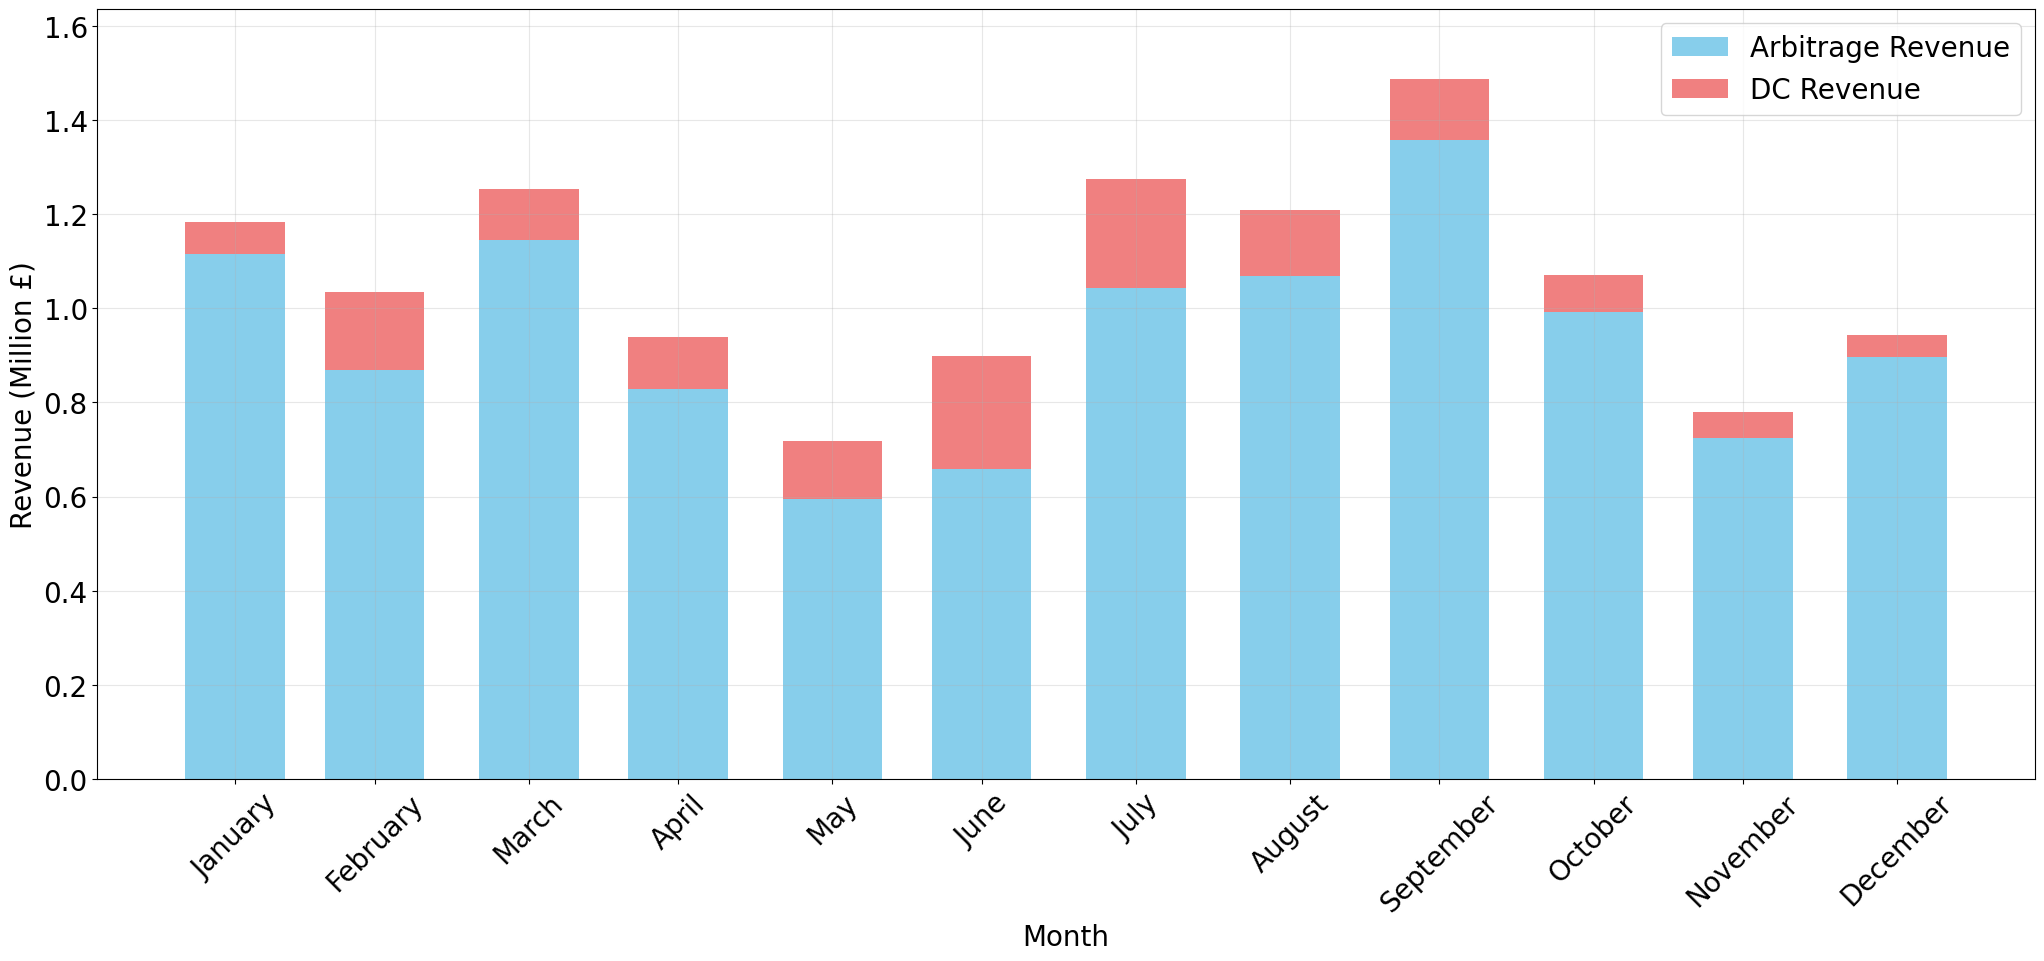

Monthly revenues plot has been saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Monthly_Revenues_Plot.png


In [7]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
data.set_index('Timestamp', inplace=True)

# Calculate monthly revenues
monthly_revenue = data.resample('ME').sum()

# Sum DCH and DCL revenues
monthly_revenue['DCH + DCL Revenue (£)'] = monthly_revenue['DCH Revenue (£)'] + monthly_revenue['DCL Revenue (£)']

# Convert revenues to millions of pounds
monthly_revenue['Arbitrage Revenue (M£)'] = monthly_revenue['Arbitrage Revenue (£)'] / 1e6
monthly_revenue['DCH + DCL Revenue (M£)'] = monthly_revenue['DCH + DCL Revenue (£)'] / 1e6

# Plot stacked bar chart for monthly Arbitrage and combined DCH + DCL revenues
plt.figure(figsize=(25, 10))

# Set the bar width
bar_width = 20

# Set colors for the bars
arbitrage_color = 'skyblue'
dch_dcl_color = 'lightcoral'

# Create stacked bar plot with combined DCH + DCL revenues and Arbitrage revenues
plt.bar(monthly_revenue.index, monthly_revenue['Arbitrage Revenue (M£)'], width=bar_width, label='Arbitrage Revenue', color=arbitrage_color)
plt.bar(monthly_revenue.index, monthly_revenue['DCH + DCL Revenue (M£)'], width=bar_width, 
        bottom=monthly_revenue['Arbitrage Revenue (M£)'], label='DC Revenue', color=dch_dcl_color)

# Customize the plot
plt.xlabel('Month', fontsize=20)
plt.ylabel('Revenue (Million £)', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(ticks=monthly_revenue.index, labels=monthly_revenue.index.strftime('%B'), fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.ylim(0, monthly_revenue[['Arbitrage Revenue (M£)', 'DCH + DCL Revenue (M£)']].sum(axis=1).max() * 1.1)
plt.grid(True,alpha=0.3)

# Save the plot as an image file in high quality and tight layout
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Monthly_Revenues_Plot.png'
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Monthly revenues plot has been saved to {output_plot_path}")


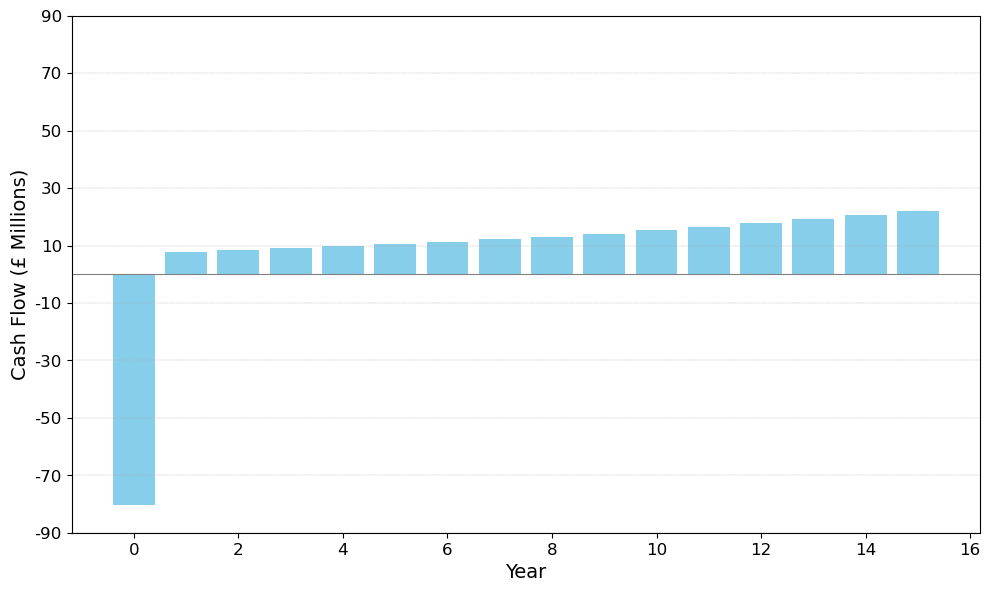

Annual cash flows plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Annual_Cash_Flows_Plot.png


In [8]:
# Load the previously saved annual cash flows
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Annual_Cash_Flows.xlsx'
cash_flows_df = pd.read_excel(file_path)

# Convert cash flows to millions
cash_flows_df['Cash Flow'] = cash_flows_df['Cash Flow'] / 1e6

# Plot the annual cash flows
plt.figure(figsize=(10, 6))
plt.bar(cash_flows_df['Year'], cash_flows_df['Cash Flow'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.8)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cash Flow (£ Millions)', fontsize=14)
plt.ylim(-90, 90)
plt.yticks(range(-90, 91, 20), fontsize=12)  # Set ticks at intervals of 10
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Annual_Cash_Flows_Plot.png'
plt.savefig(output_plot_path)
plt.show()

print(f"Annual cash flows plot saved to {output_plot_path}")


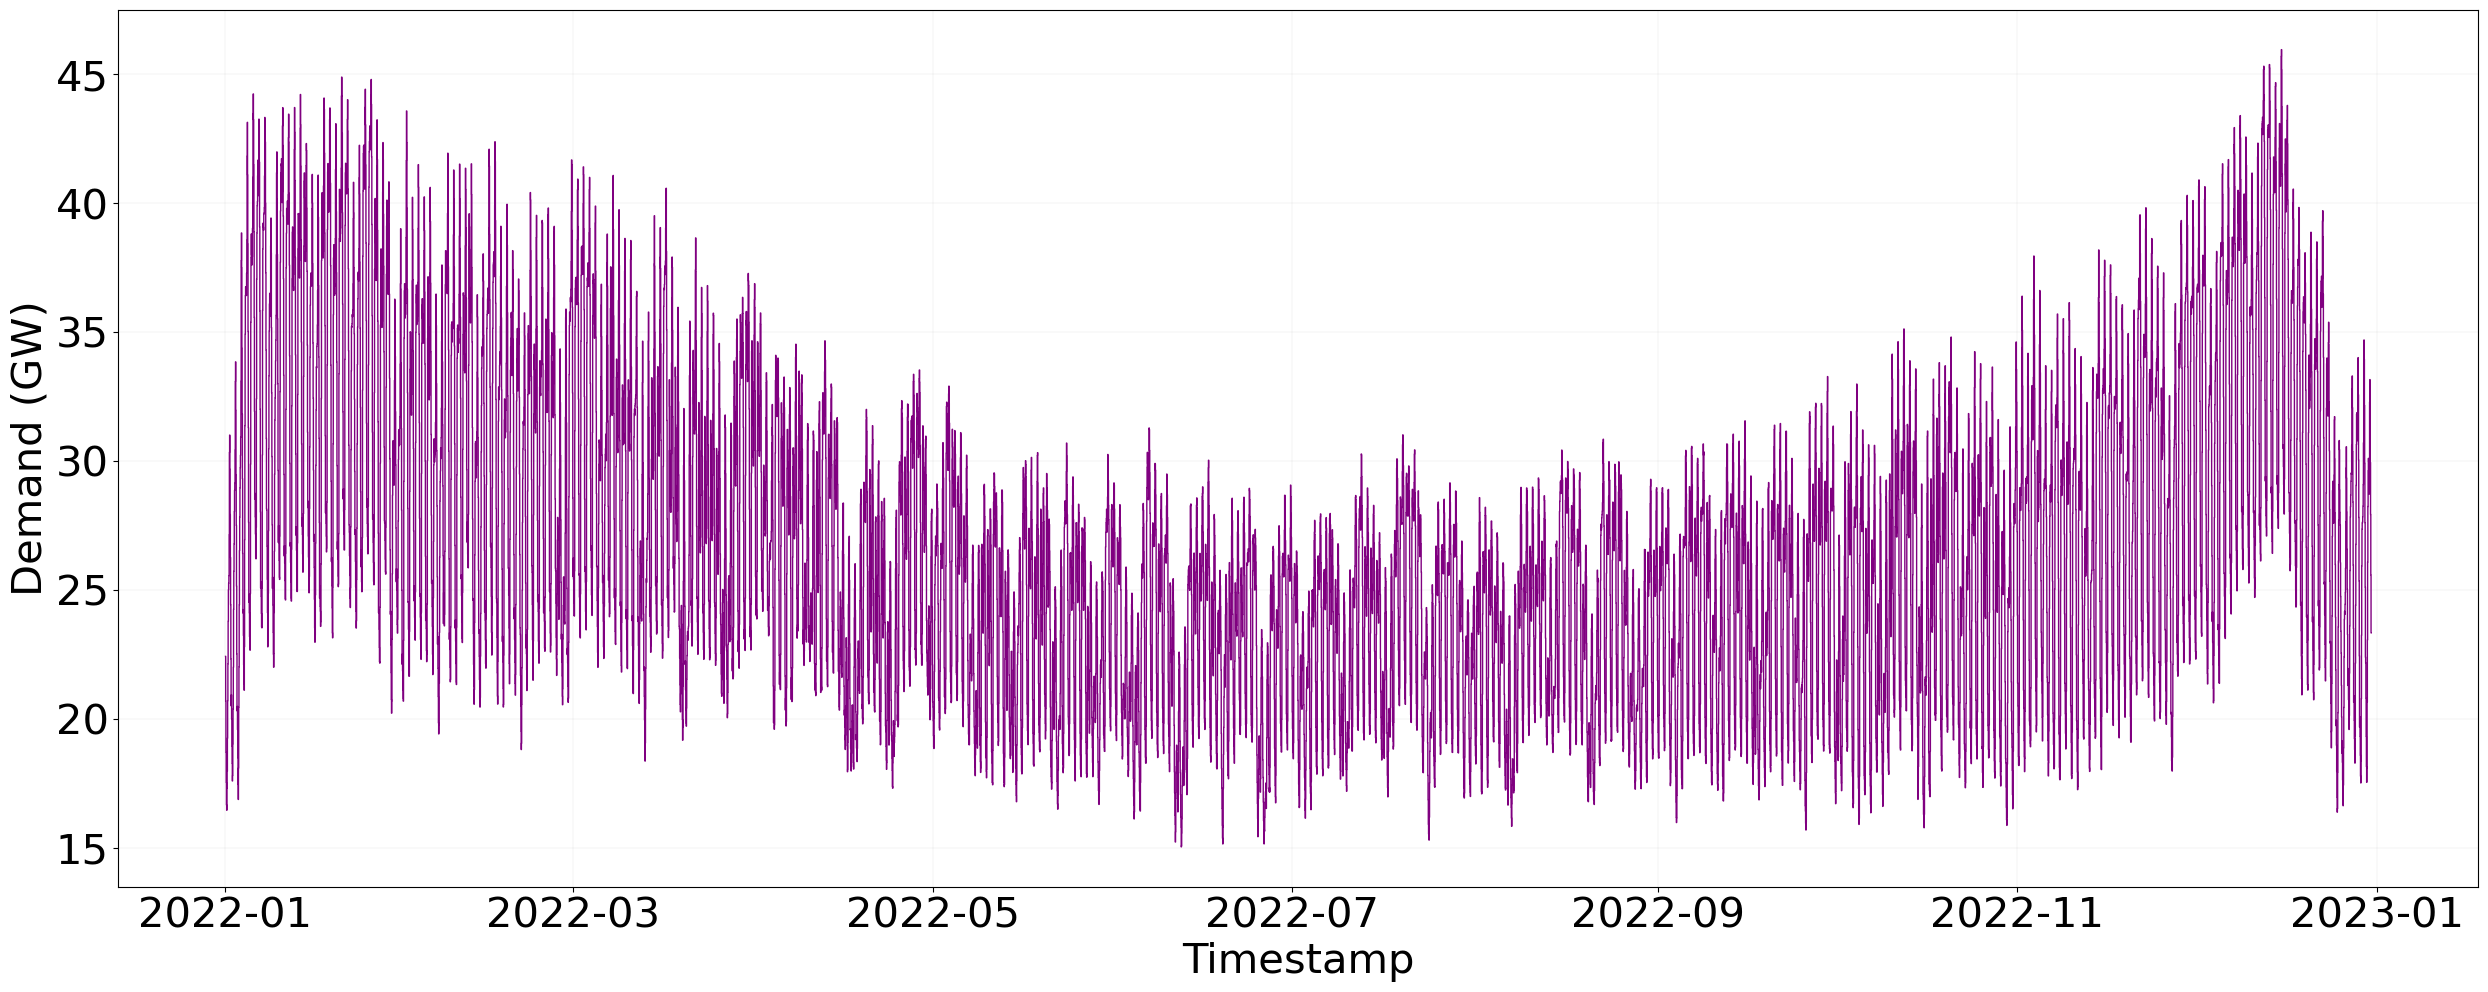

In [9]:
# Load the data from the specified Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Wind Demand/Demand_UK_2022_Final_for_plot_only.xlsx'
wind_data = pd.read_excel(file_path, index_col=0)

# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Convert index to datetime if not already
wind_data.index = pd.to_datetime(wind_data.index)

# Filter the data for the specified time range
filtered_data = wind_data.loc[start_date:end_date]

# Plot load demand over time
plt.figure(figsize=(25, 10))
plt.step(filtered_data.index, filtered_data['Load Demand (MW)']/1000, label='Load Demand', color='purple', where='mid', linewidth=1, linestyle='-')
plt.xlabel('Timestamp', fontsize=30)  # Adjusted font size
plt.ylabel('Demand (GW)', fontsize=30)  # Adjusted font size

# Increase the font size of the tick labels
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)

# Adjust layout to prevent cutting off y-axis labels
plt.tight_layout(pad=1.0)

# Save the plot
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/load_demand_plot.png', dpi=300)
plt.show()


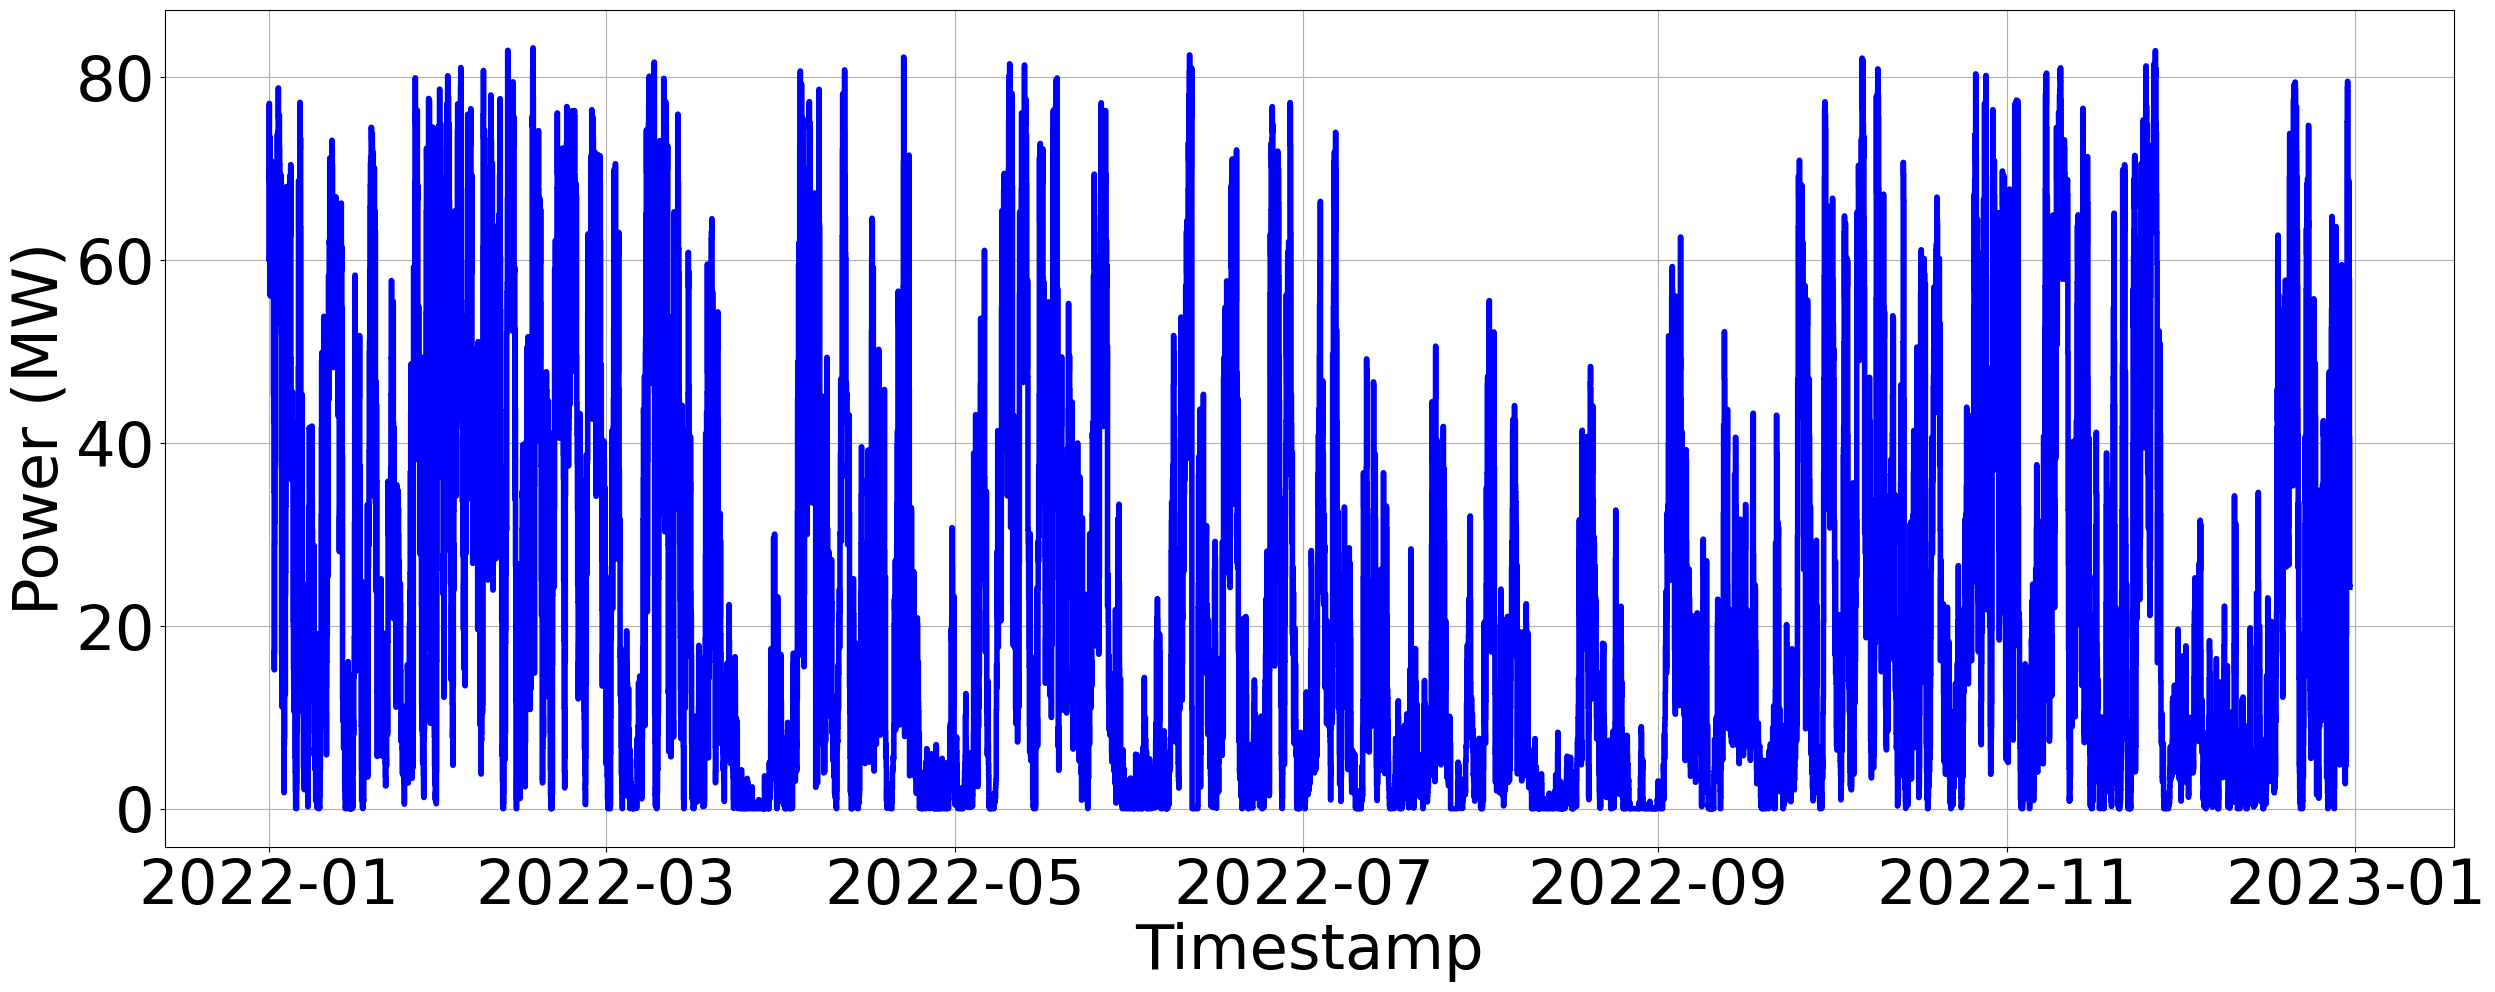

In [10]:
# Filter the data for the specified time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Ensure 'Timestamp' is in datetime format
wind_data.index = pd.to_datetime(wind_data.index)

filtered_wind_generation = wind_generation_profile.loc[start_date:end_date]

# Plot wind generation over time
plt.figure(figsize=(25, 10))
plt.step(filtered_wind_generation.index, filtered_wind_generation.values, label='Wind Generation', color='b', where='mid', linewidth=4, linestyle='-')
plt.xlabel('Timestamp', fontsize=45)
plt.ylabel('Power (MW)', fontsize=45)
plt.grid(True, linestyle='-', alpha=1, linewidth=0.8)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.tight_layout(pad=1.0)

# Save the plot
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/Wind_Generation_Plot.png'
plt.savefig(output_path, dpi=300)

# Show the plot
plt.show()


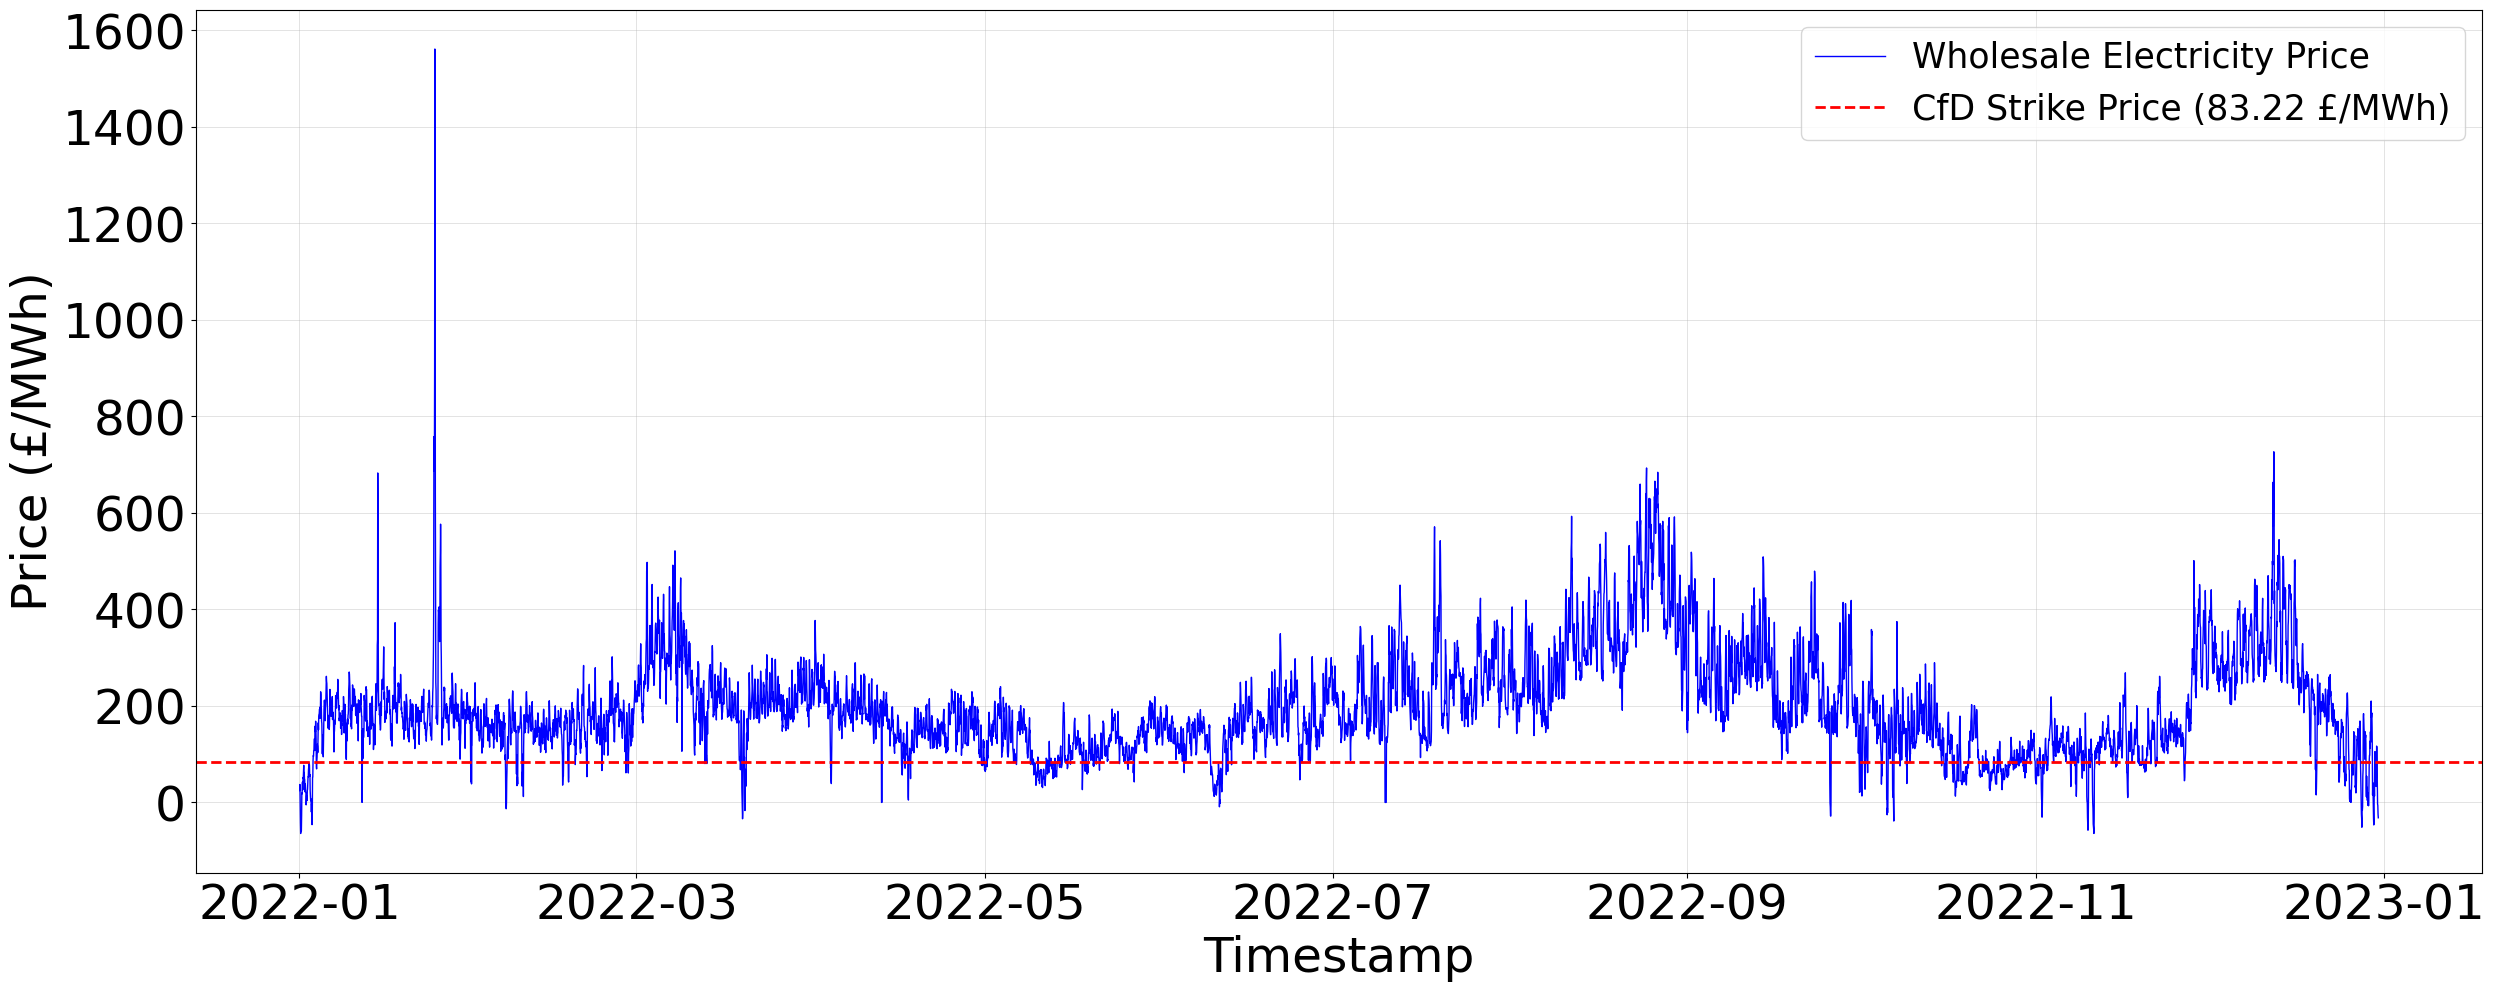

'/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/Market_Price_and_CfD_Price.png'

In [11]:
# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Filter the data for the specified time range
filtered_data = results_df.loc[start_date:end_date]
filtered_market_prices = market_prices.loc[start_date:end_date]

cfd_strike_price = 83.22

# Plot Market Price and CfD
plt.figure(figsize=(25, 10))
plt.plot(filtered_market_prices.index, filtered_market_prices, label='Wholesale Electricity Price', color='blue', linewidth=1, linestyle='-')
plt.axhline(y=cfd_strike_price, color='red', linestyle='--', label='CfD Strike Price (83.22 £/MWh)', linewidth=2)
plt.xlabel('Timestamp', fontsize=35)
plt.ylabel('Price (£/MWh)', fontsize=35)
plt.legend(fontsize=25)
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.tight_layout(pad=1.0)

# Save the plot
output_path_plot = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/Market_Price_and_CfD_Price.png'
plt.savefig(output_path_plot, dpi=300)
plt.show()

output_path_plot


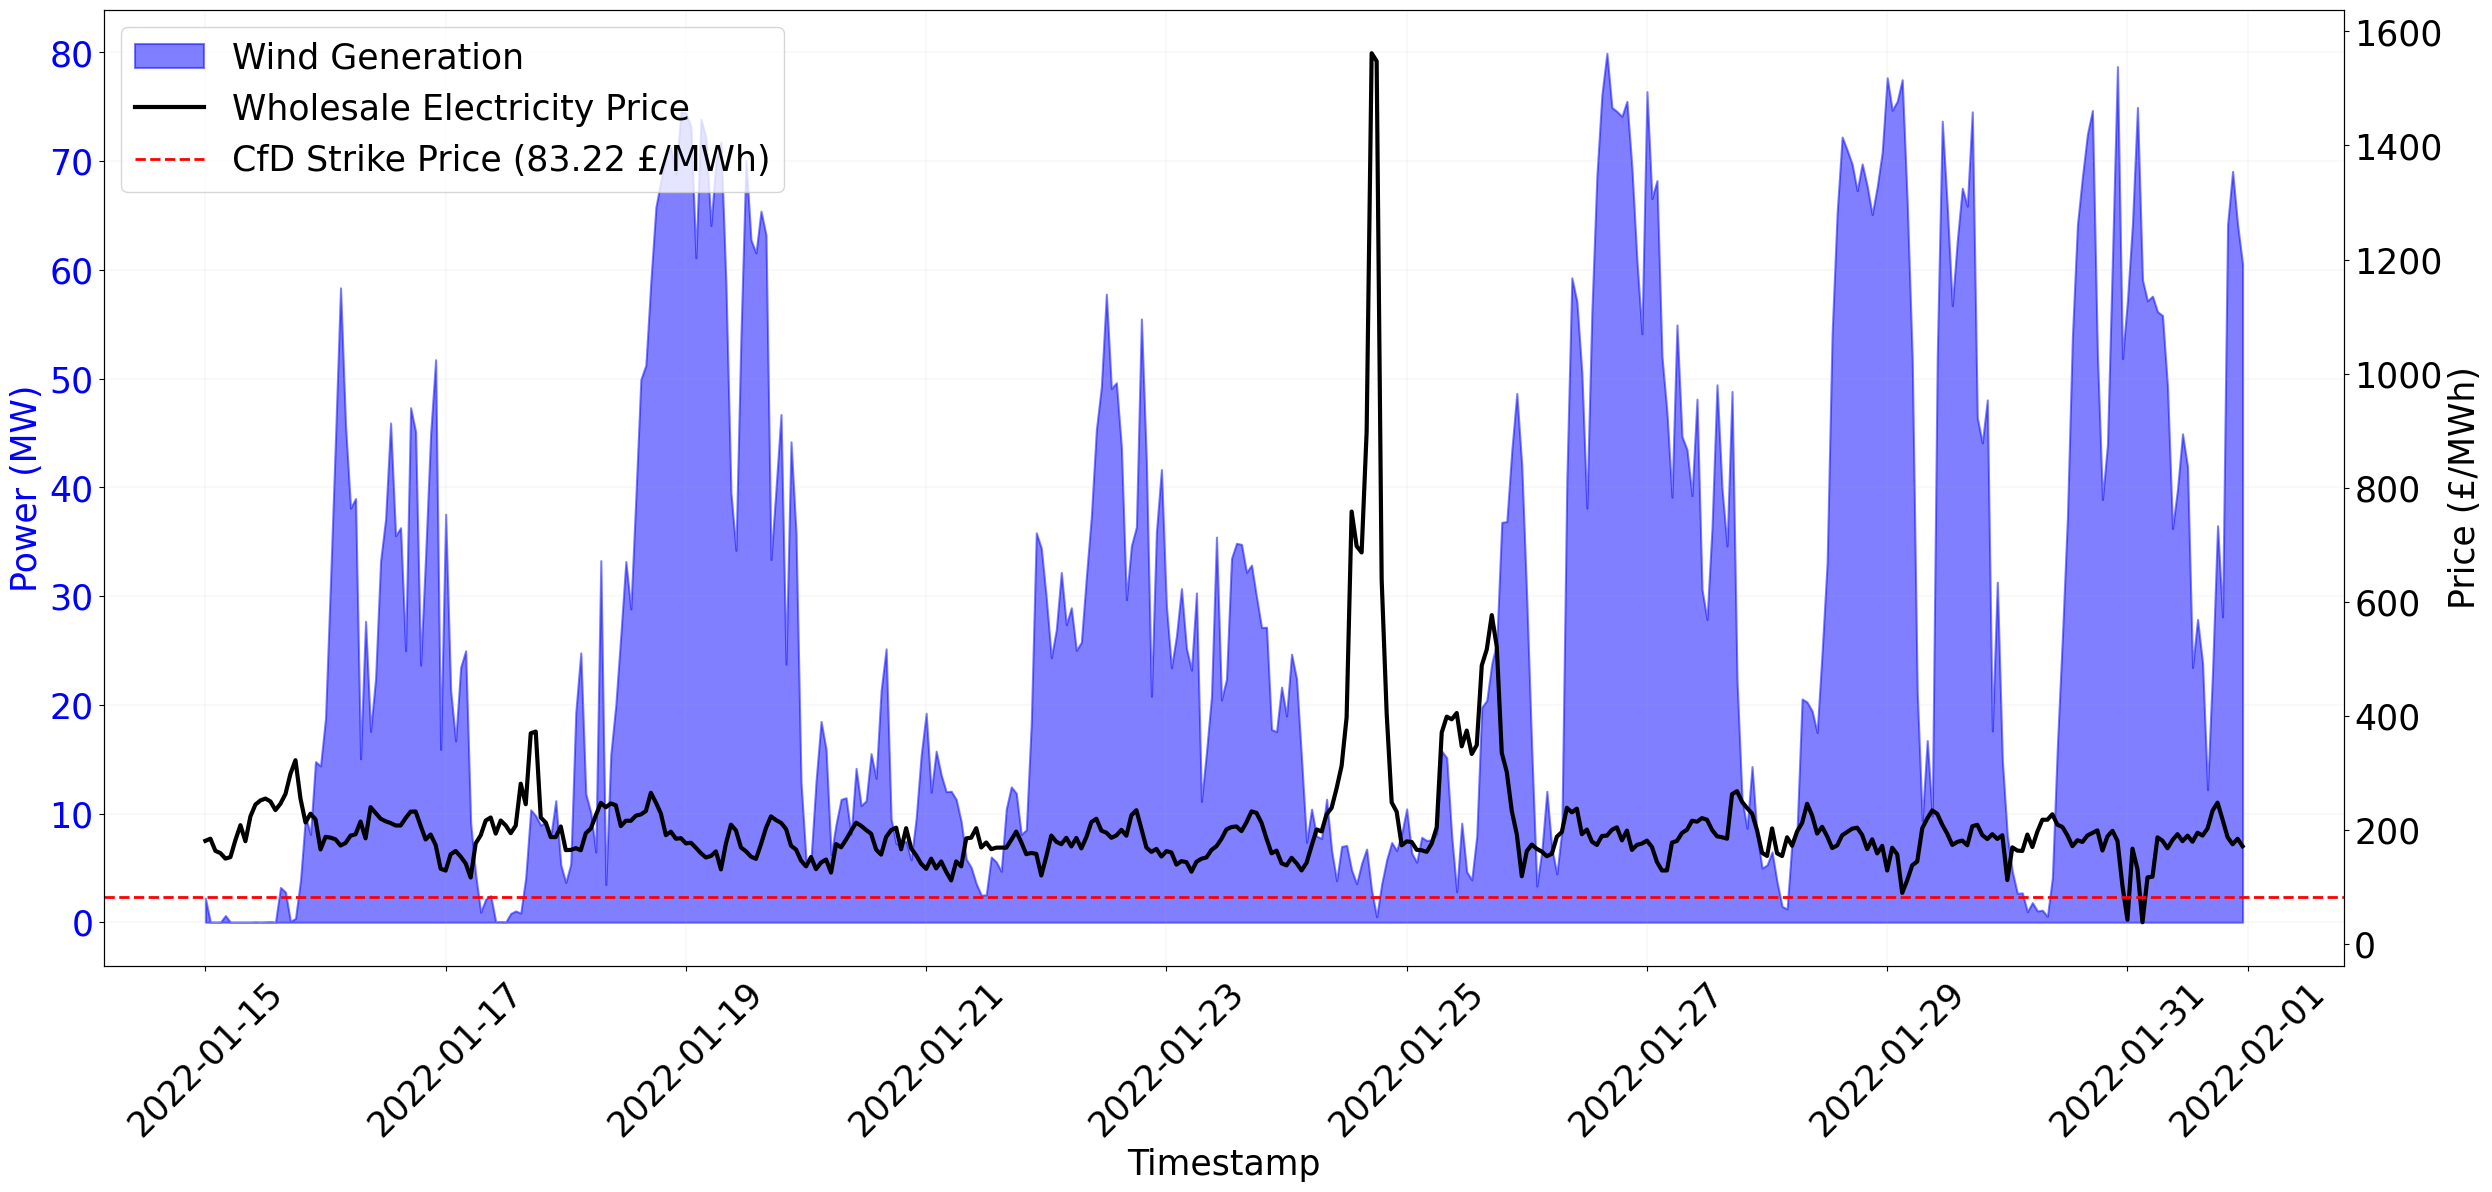

In [12]:
# Define the time range
start_date = '2022-01-15 00:00:00'
end_date = '2022-01-31 23:00:00'

# Ensure 'Timestamp' is in datetime format
wind_data.index = pd.to_datetime(wind_data.index)

# Filter the data for the specified time range
filtered_wind_generation = wind_generation_profile.loc[start_date:end_date]
filtered_market_prices = market_prices.loc[start_date:end_date]

# CfD strike price
cfd_strike_price = 83.22

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(25, 12))

# Plot wind generation as an area plot with a border on the first y-axis
ax1.fill_between(filtered_wind_generation.index, filtered_wind_generation.values, label='Wind Generation', color='b', alpha=0.5, edgecolor='blue', linewidth=1.5)
ax1.set_xlabel('Timestamp', fontsize=25)
ax1.set_ylabel('Power (MW)', fontsize=25, color='b')
ax1.tick_params(axis='y', labelcolor='b', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)
ax1.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Create a second y-axis for the market prices
ax2 = ax1.twinx()
ax2.plot(filtered_market_prices.index, filtered_market_prices, label='Wholesale Electricity Price', color='black', linewidth=3, linestyle='-')
ax2.axhline(y=cfd_strike_price, color='red', linestyle='--', label='CfD Strike Price (83.22 £/MWh)', linewidth=2)
ax2.set_ylabel('Price (£/MWh)', fontsize=25, color='black')
ax2.tick_params(axis='y', labelcolor='black', labelsize=25)

# Increase the font size of the tick labels for the second y-axis
ax2.tick_params(axis='x', labelsize=25)
ax2.tick_params(axis='y', labelsize=25)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=25)

plt.tight_layout(pad=1.0)

# Save the plot
output_path_combined = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/Wind_Generation_and_Market_Price_Plot.png'
plt.savefig(output_path_combined, dpi=300)

# Show the plot
plt.show()


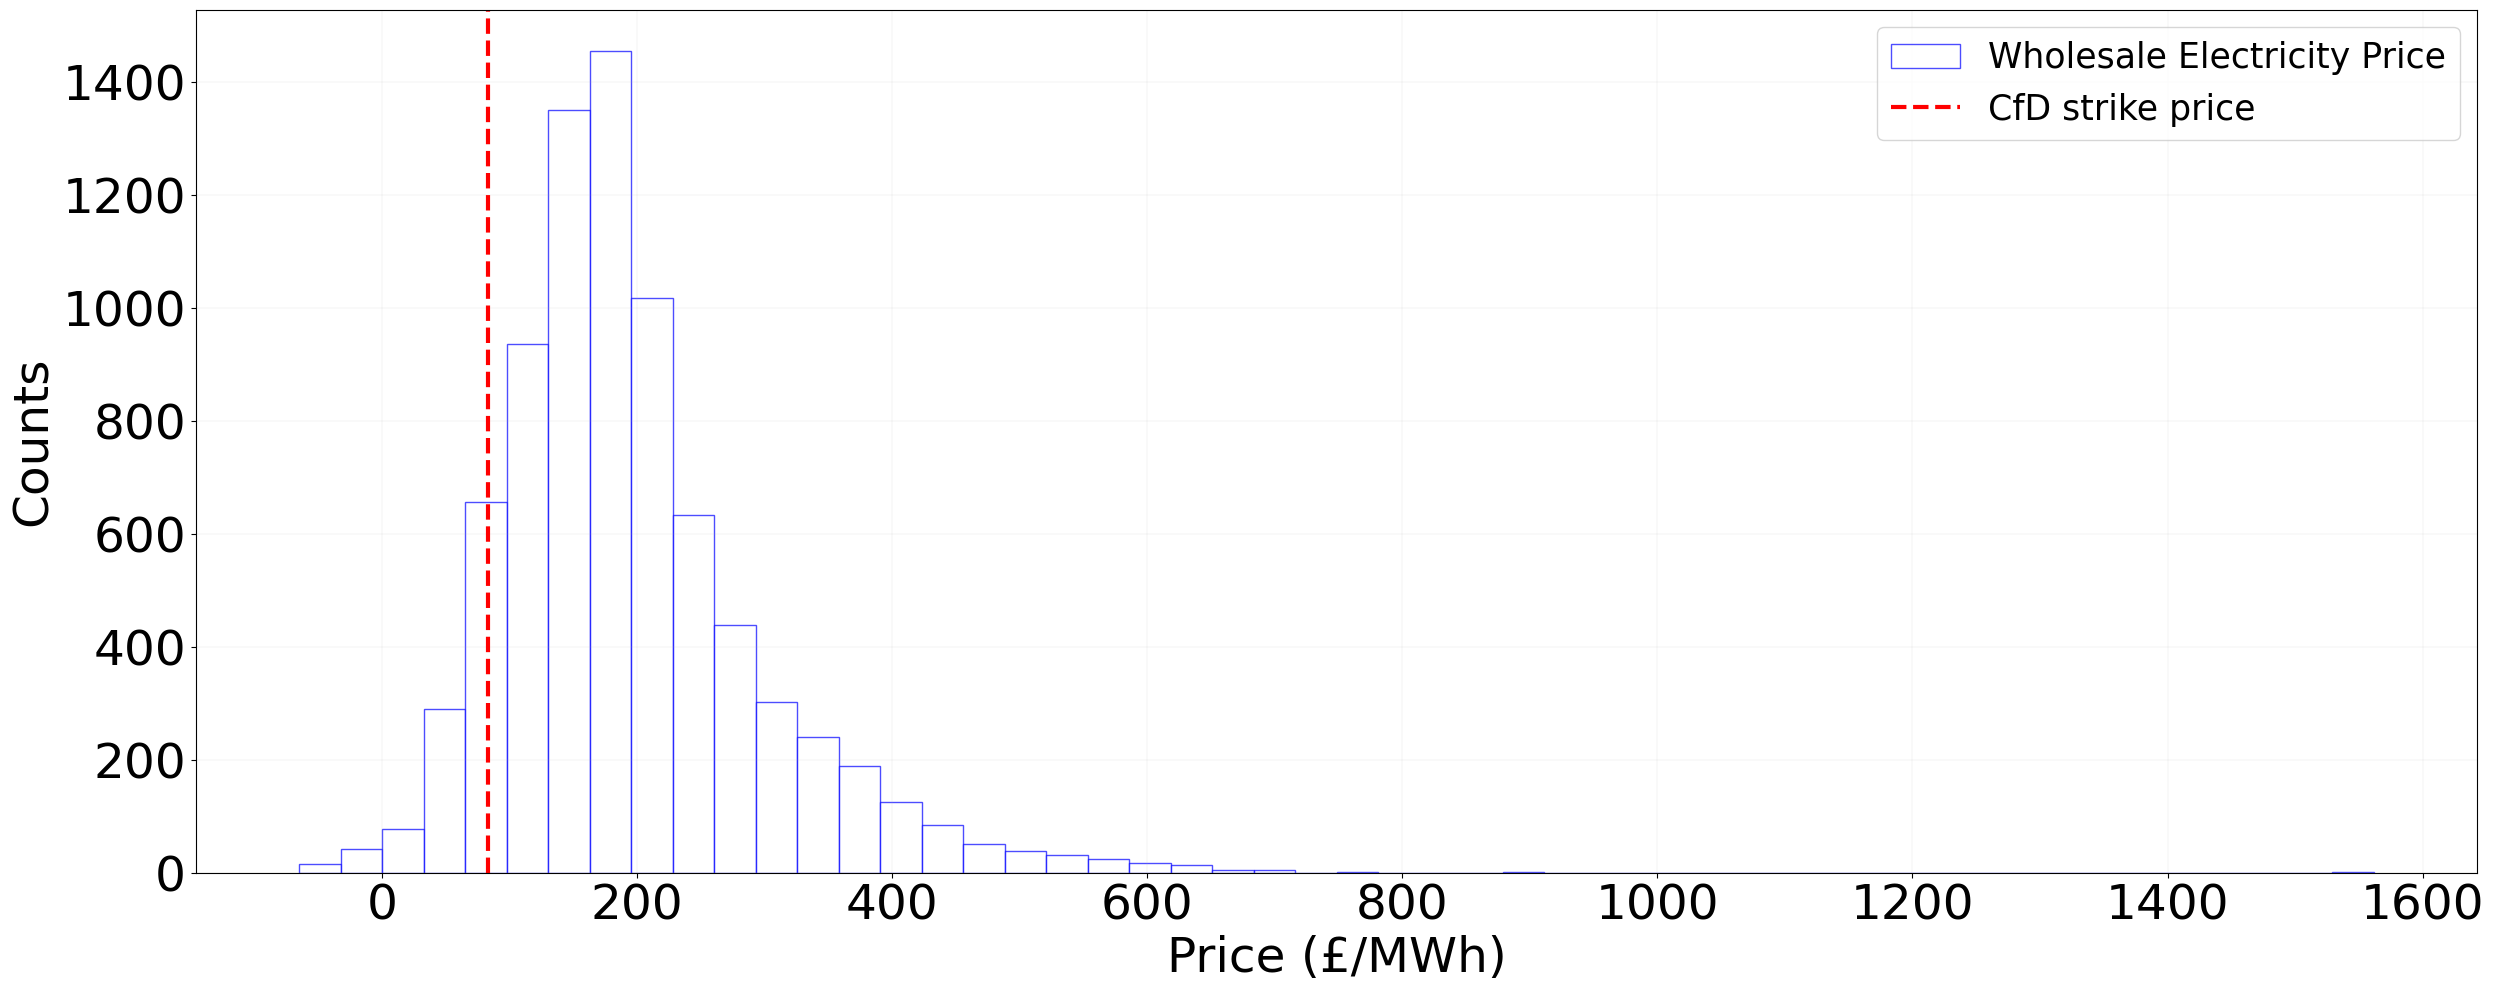

In [13]:
# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-01 23:00:00'

# Filter the data for the specified time range
filtered_market_prices = market_prices.loc[start_date:end_date]

# CfD strike price
cfd_strike_price = 83.22

# Plot histogram for Market Price and CfD
plt.figure(figsize=(25, 10))
plt.hist(filtered_market_prices, bins=50, alpha=0.7, label='Wholesale Electricity Price', color='white', edgecolor='blue')
plt.axvline(x=cfd_strike_price, color='red', linestyle='--', label='CfD strike price', linewidth=3)
plt.xlabel('Price (£/MWh)', fontsize=35)
plt.ylabel('Counts', fontsize=35)
plt.legend(fontsize=25)
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/market_price_histogram.png'
plt.savefig(output_plot_path, dpi=300)

# Display the plot
plt.show()


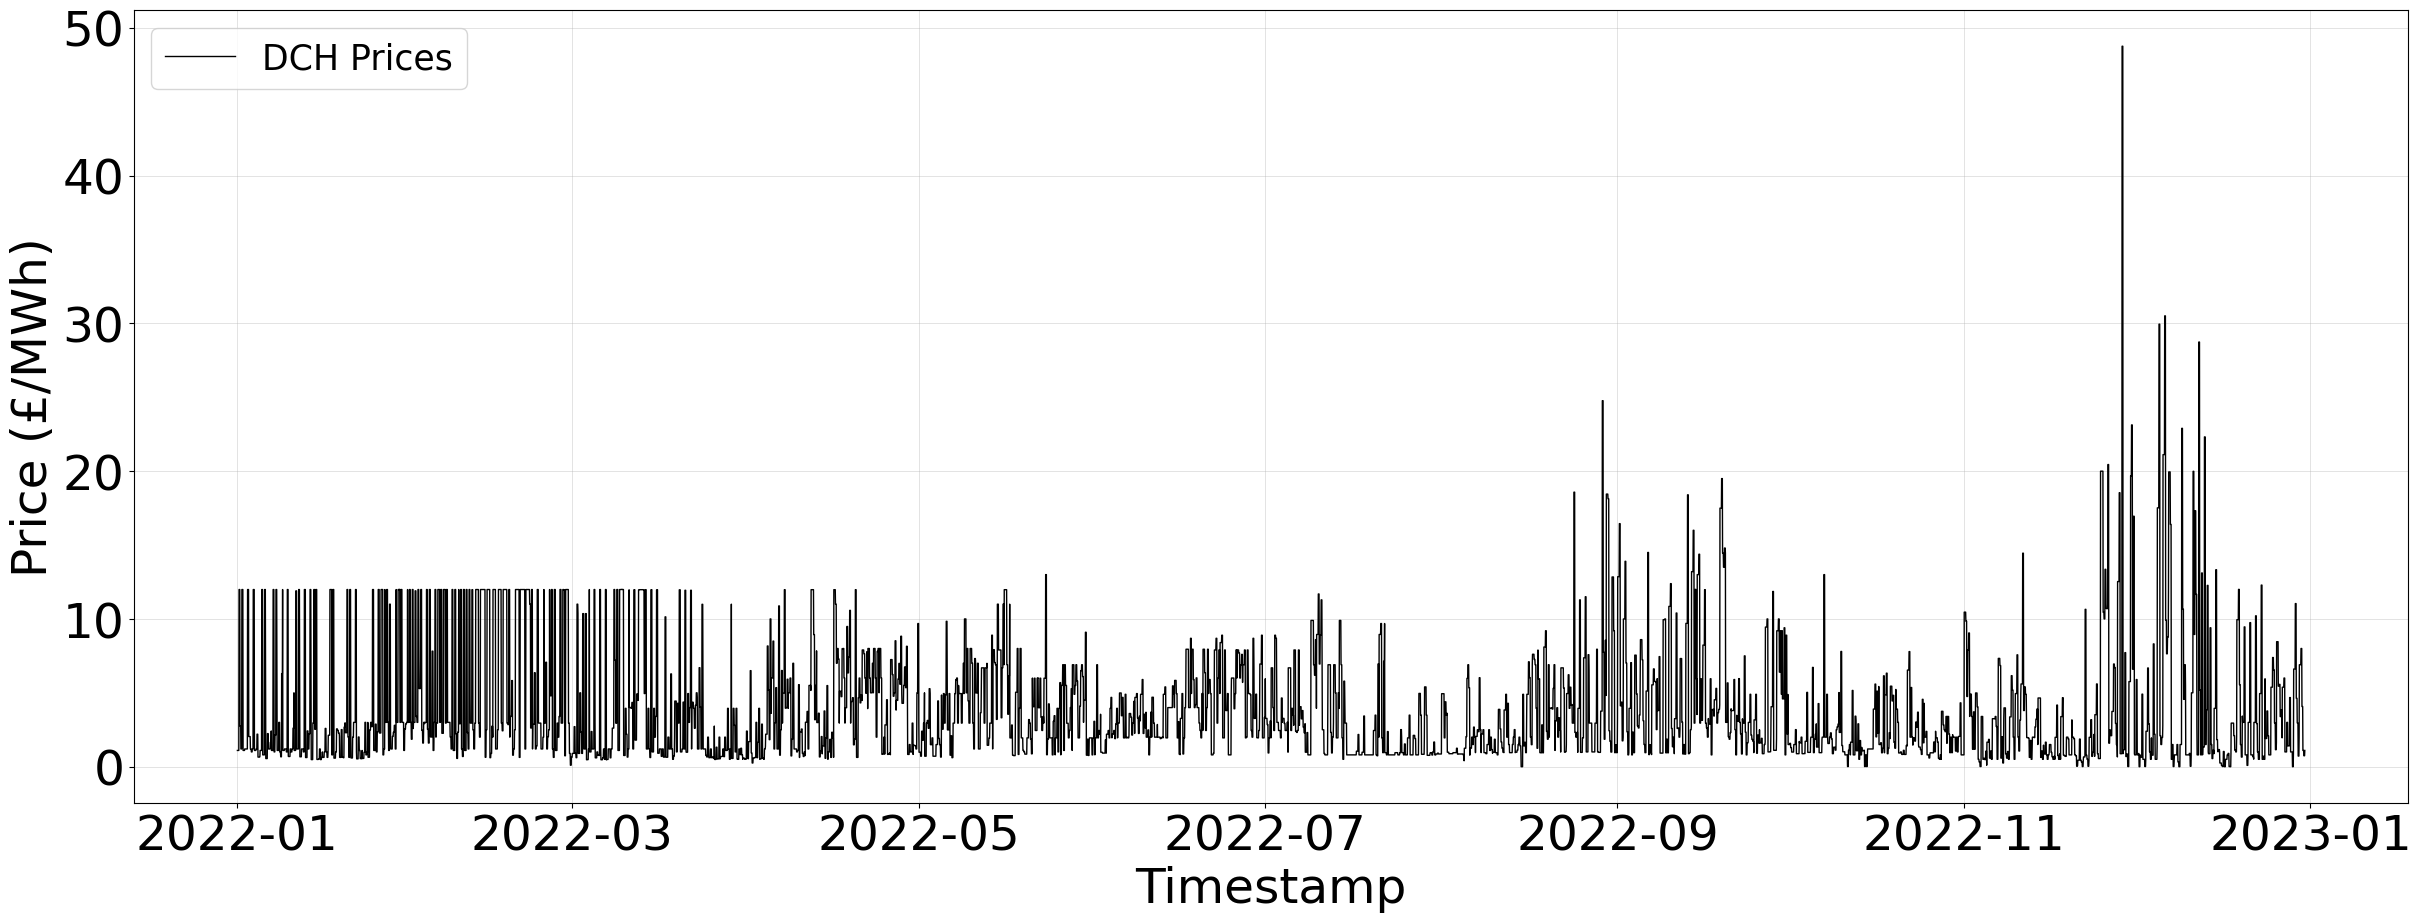

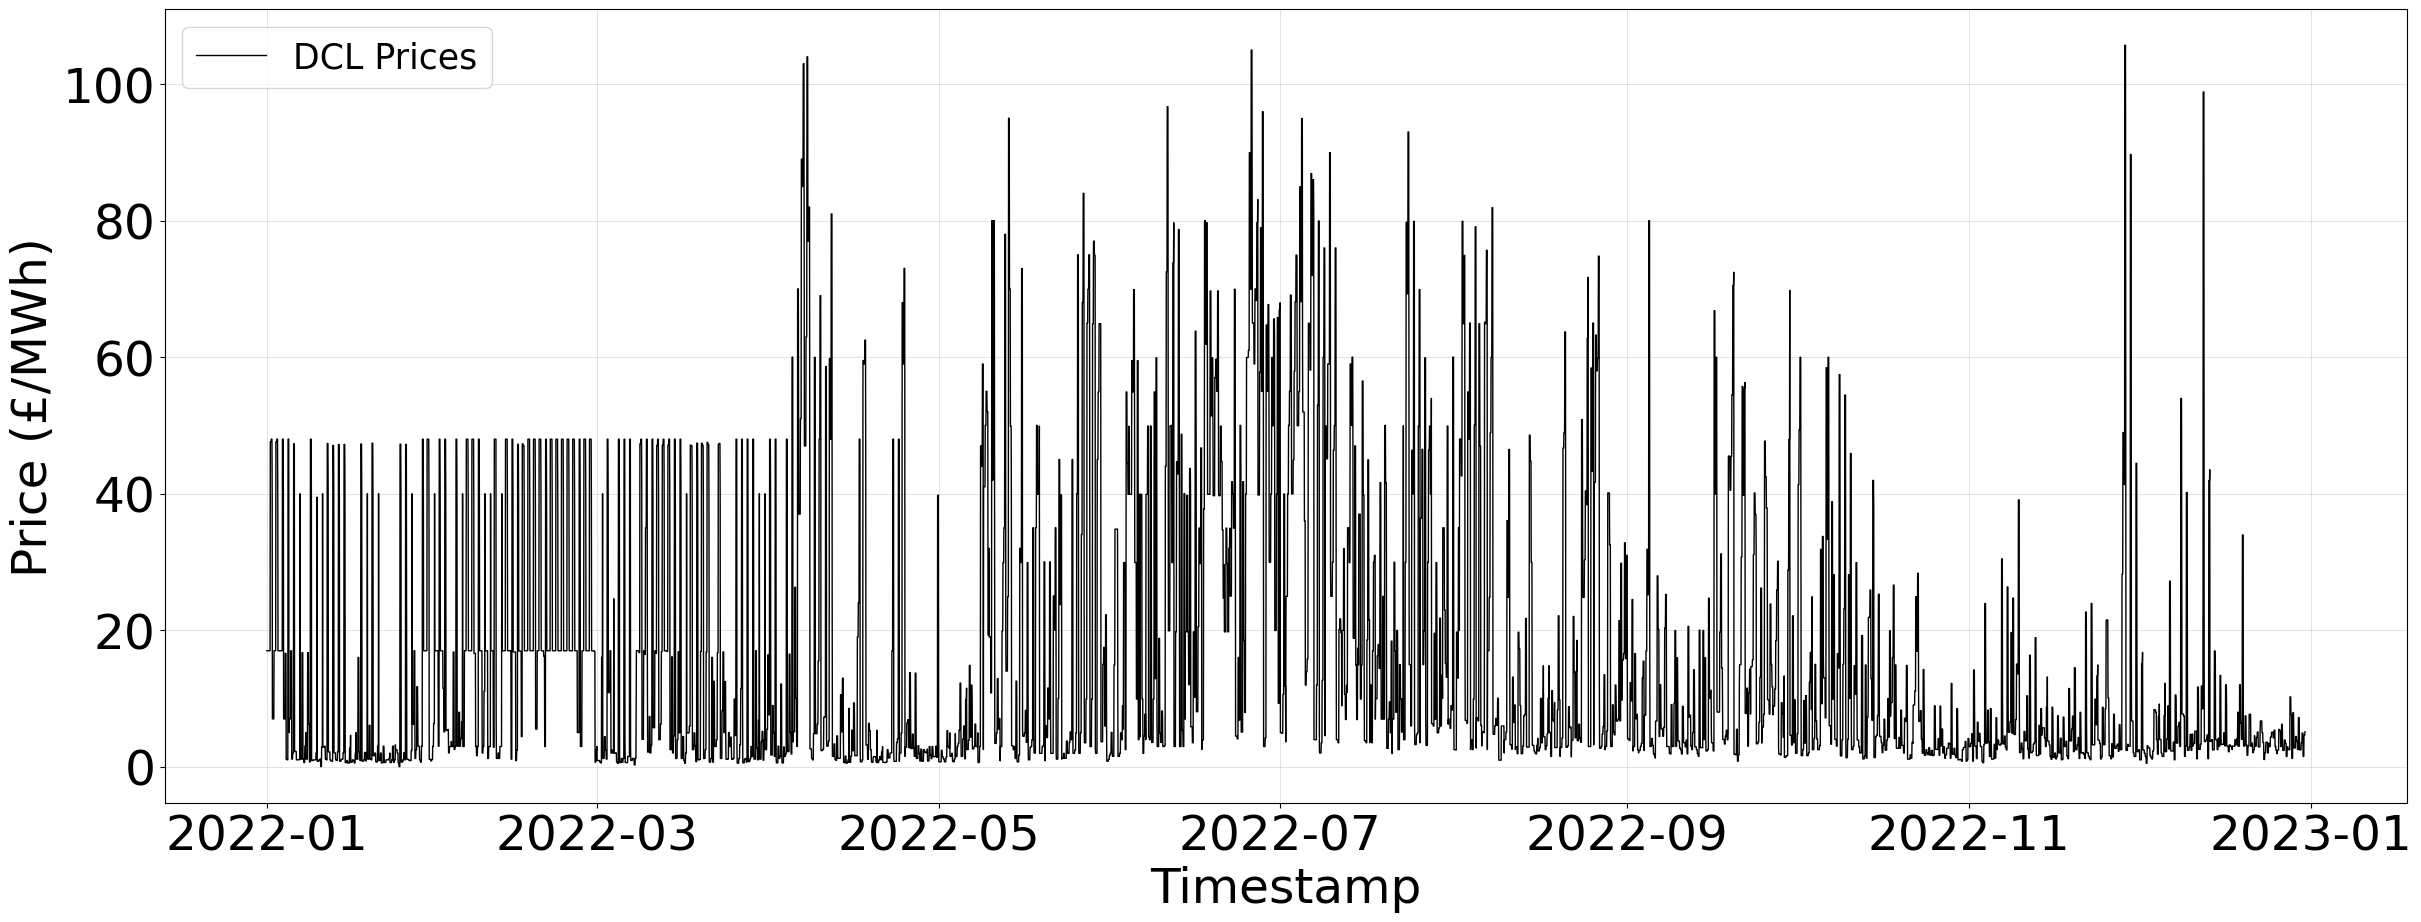

In [14]:
# Ensure 'Timestamp' is in datetime format
dch_prices.index = pd.to_datetime(dch_prices.index)
dcl_prices.index = pd.to_datetime(dcl_prices.index)

# Filter the data for the specified time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

filtered_dch_prices = dch_prices.loc[start_date:end_date]
filtered_dcl_prices = dcl_prices.loc[start_date:end_date]

# Set font sizes
plt.rcParams.update({'font.size': 35, 'axes.titlesize': 35, 'axes.labelsize': 35, 'xtick.labelsize': 35, 'ytick.labelsize': 35, 'legend.fontsize': 25})

# Plot DCH prices over time
plt.figure(figsize=(25, 10))
plt.plot(filtered_dch_prices.index, filtered_dch_prices.values, label='DCH Prices', color='k', linewidth=1, linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Price (£/MWh)')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.tight_layout(pad=1.0)

# Save the DCH plot
dch_output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/DCH_Prices_Plot.png'
plt.savefig(dch_output_path, dpi=300)

# Show the DCH plot
plt.show()

# Plot DCL prices over time
plt.figure(figsize=(25, 10))
plt.plot(filtered_dcl_prices.index, filtered_dcl_prices.values, label='DCL Prices', color='k', linewidth=1, linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Price (£/MWh)')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.tight_layout(pad=1.0)


# Save the DCL plot
dcl_output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Input Plots/DCL_Prices_Plot.png'
plt.savefig(dcl_output_path, dpi=300)

# Show the DCL plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery Charging Status Plot_Wholesale_Electricity_v2_peak.png


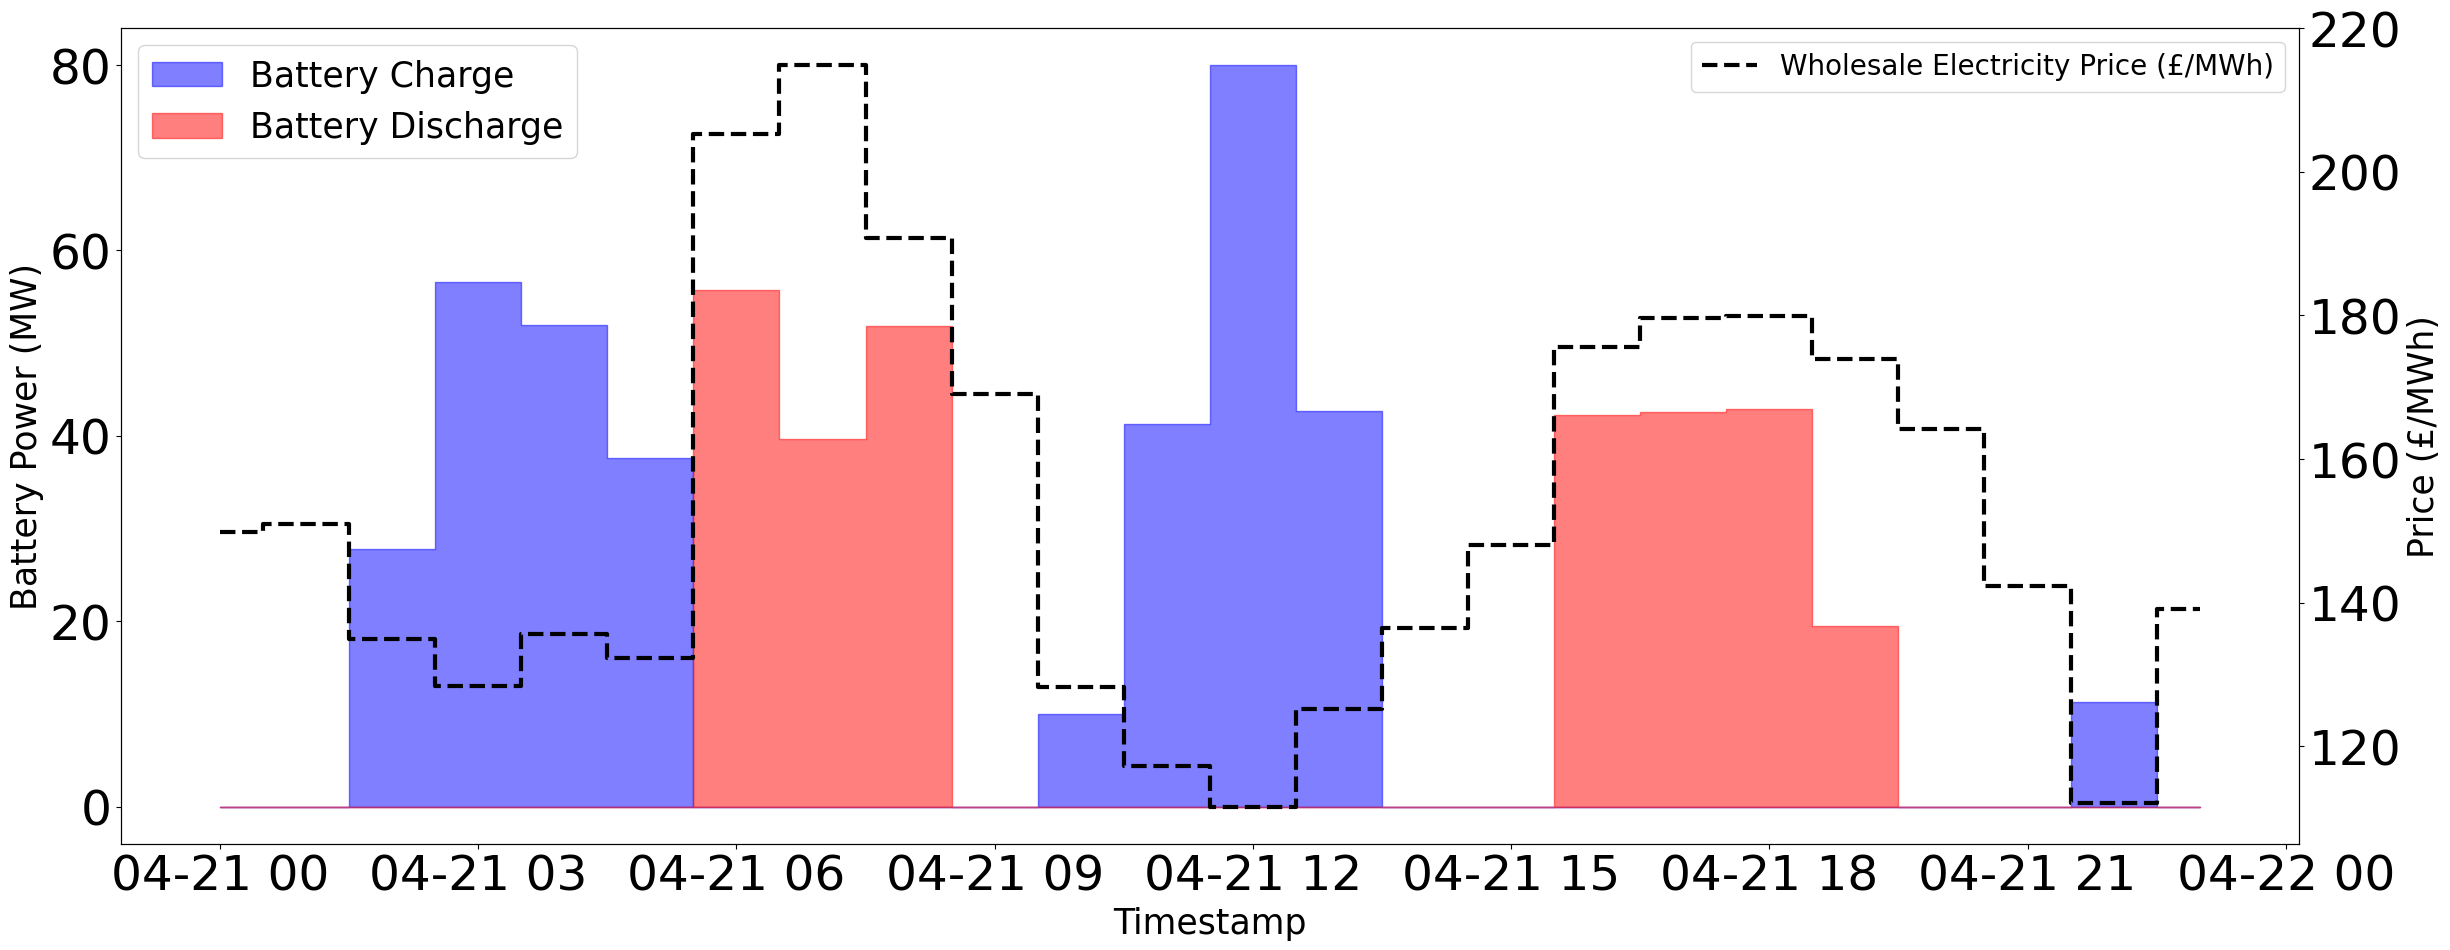

In [15]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-21 00:00:00'
end_date = '2022-04-21 23:00:00'

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]

# Extract relevant columns
timestamp = filtered_data['Timestamp']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
market_price = filtered_data['Market Price (£/MWh)']
dch_price = filtered_data['DCH Price (£/MWh)']
dcl_price = filtered_data['DCL Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Set font sizes
plt.rcParams.update({'font.size': 25})  # Global font size

# Plot battery charge and discharge as area plots on the left Y-axis
ax1.fill_between(timestamp, battery_store, label='Battery Charge', color='blue', step="mid", alpha=0.5)
ax1.fill_between(timestamp, battery_dispatch, label='Battery Discharge', color='red', step="mid", alpha=0.5)
ax1.set_xlabel('Timestamp', fontsize=25)
ax1.set_ylabel('Battery Power (MW)', fontsize=25)
ax1.legend(loc='upper left', fontsize=25)

# Create a second Y-axis for market, DCL, and DCH prices
ax2 = ax1.twinx()
ax2.step(timestamp, market_price, label='Wholesale Electricity Price (£/MWh)', color='black', linestyle='--', linewidth=3, where='mid')
#ax2.plot(timestamp, dch_price, label='', color='w', linestyle=':', linewidth=2)

ax2.set_ylabel('Price (£/MWh)', fontsize=25)
ax2.legend(loc='upper right', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery Charging Status Plot_Wholesale_Electricity_v2_peak.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery Charging Status Plot_Wholesale_Electricity_v2_hours.png


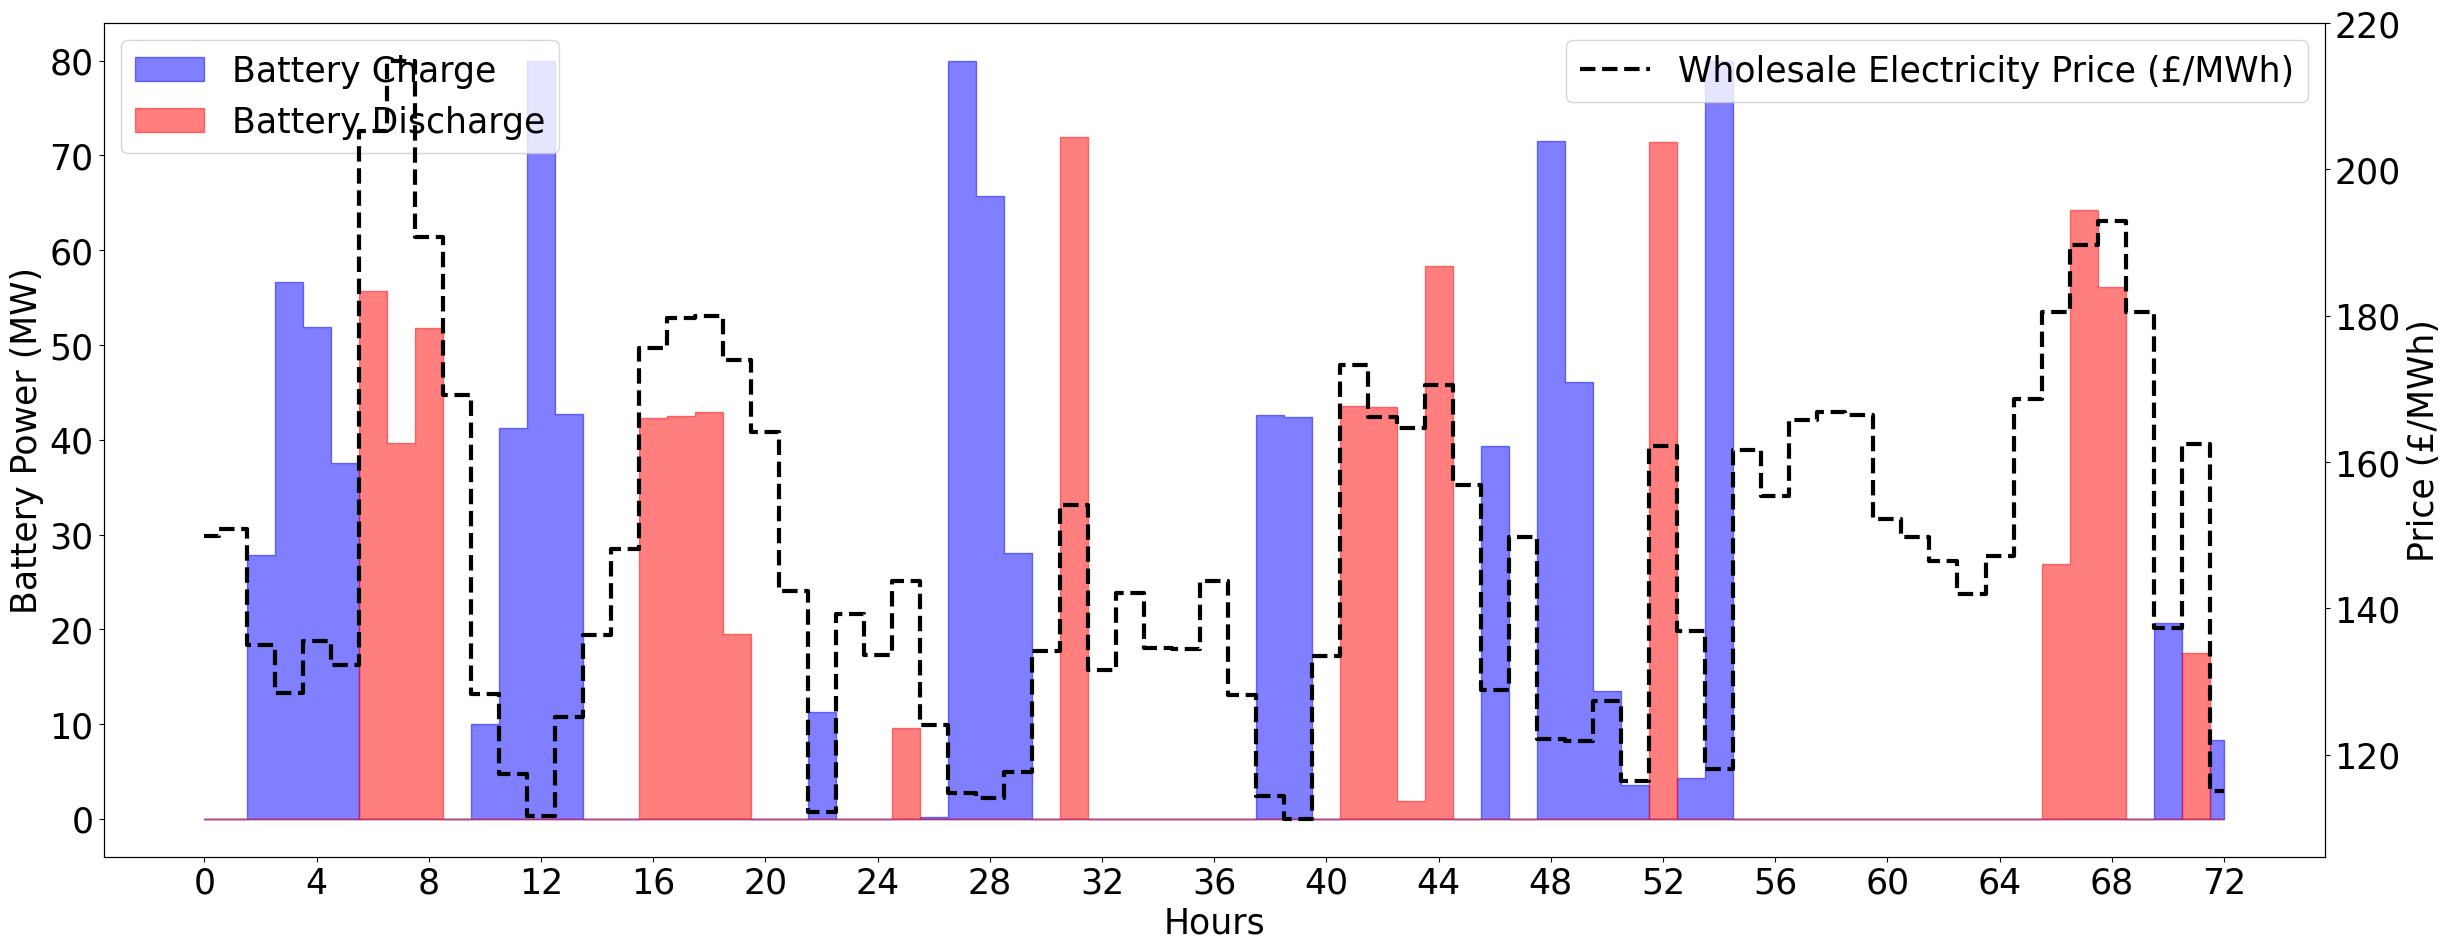

In [16]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = pd.to_datetime('2022-04-21 00:00:00')
end_date = pd.to_datetime('2022-04-24 00:00:00')

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)].copy()

# Calculate the number of hours from the start date for the x-axis
filtered_data.loc[:, 'Hours'] = (filtered_data['Timestamp'] - start_date).dt.total_seconds() / 3600

# Extract relevant columns
hours = filtered_data['Hours']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
market_price = filtered_data['Market Price (£/MWh)']
dch_price = filtered_data['DCH Price (£/MWh)']
dcl_price = filtered_data['DCL Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Set font sizes
plt.rcParams.update({'font.size': 25})  # Global font size

# Plot battery charge and discharge as area plots on the left Y-axis
ax1.fill_between(hours, battery_store, label='Battery Charge', color='blue', step="mid", alpha=0.5)
ax1.fill_between(hours, battery_dispatch, label='Battery Discharge', color='red', step="mid", alpha=0.5)
ax1.set_xlabel('Hours', fontsize=25)
ax1.set_ylabel('Battery Power (MW)', fontsize=25)
ax1.legend(loc='upper left', fontsize=25)

# Set x-axis range to four-hour intervals
hour_range = np.arange(0, hours.max() + 1, 4)
ax1.set_xticks(hour_range)
ax1.set_xticklabels([str(int(hr)) for hr in hour_range], fontsize=25)

# Adjust tick label size for the left y-axis
ax1.tick_params(axis='both', which='major', labelsize=25)

# Create a second Y-axis for market, DCL, and DCH prices
ax2 = ax1.twinx()
ax2.plot(hours, market_price, label='Wholesale Electricity Price (£/MWh)', color='black', linestyle='--', linewidth=3, drawstyle='steps-mid')

ax2.set_ylabel('Price (£/MWh)', fontsize=25)
ax2.legend(loc='upper right', fontsize=25)

# Adjust tick label size for the right y-axis
ax2.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery Charging Status Plot_Wholesale_Electricity_v2_hours.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC and Battery Charging Pattern_area_hours.png


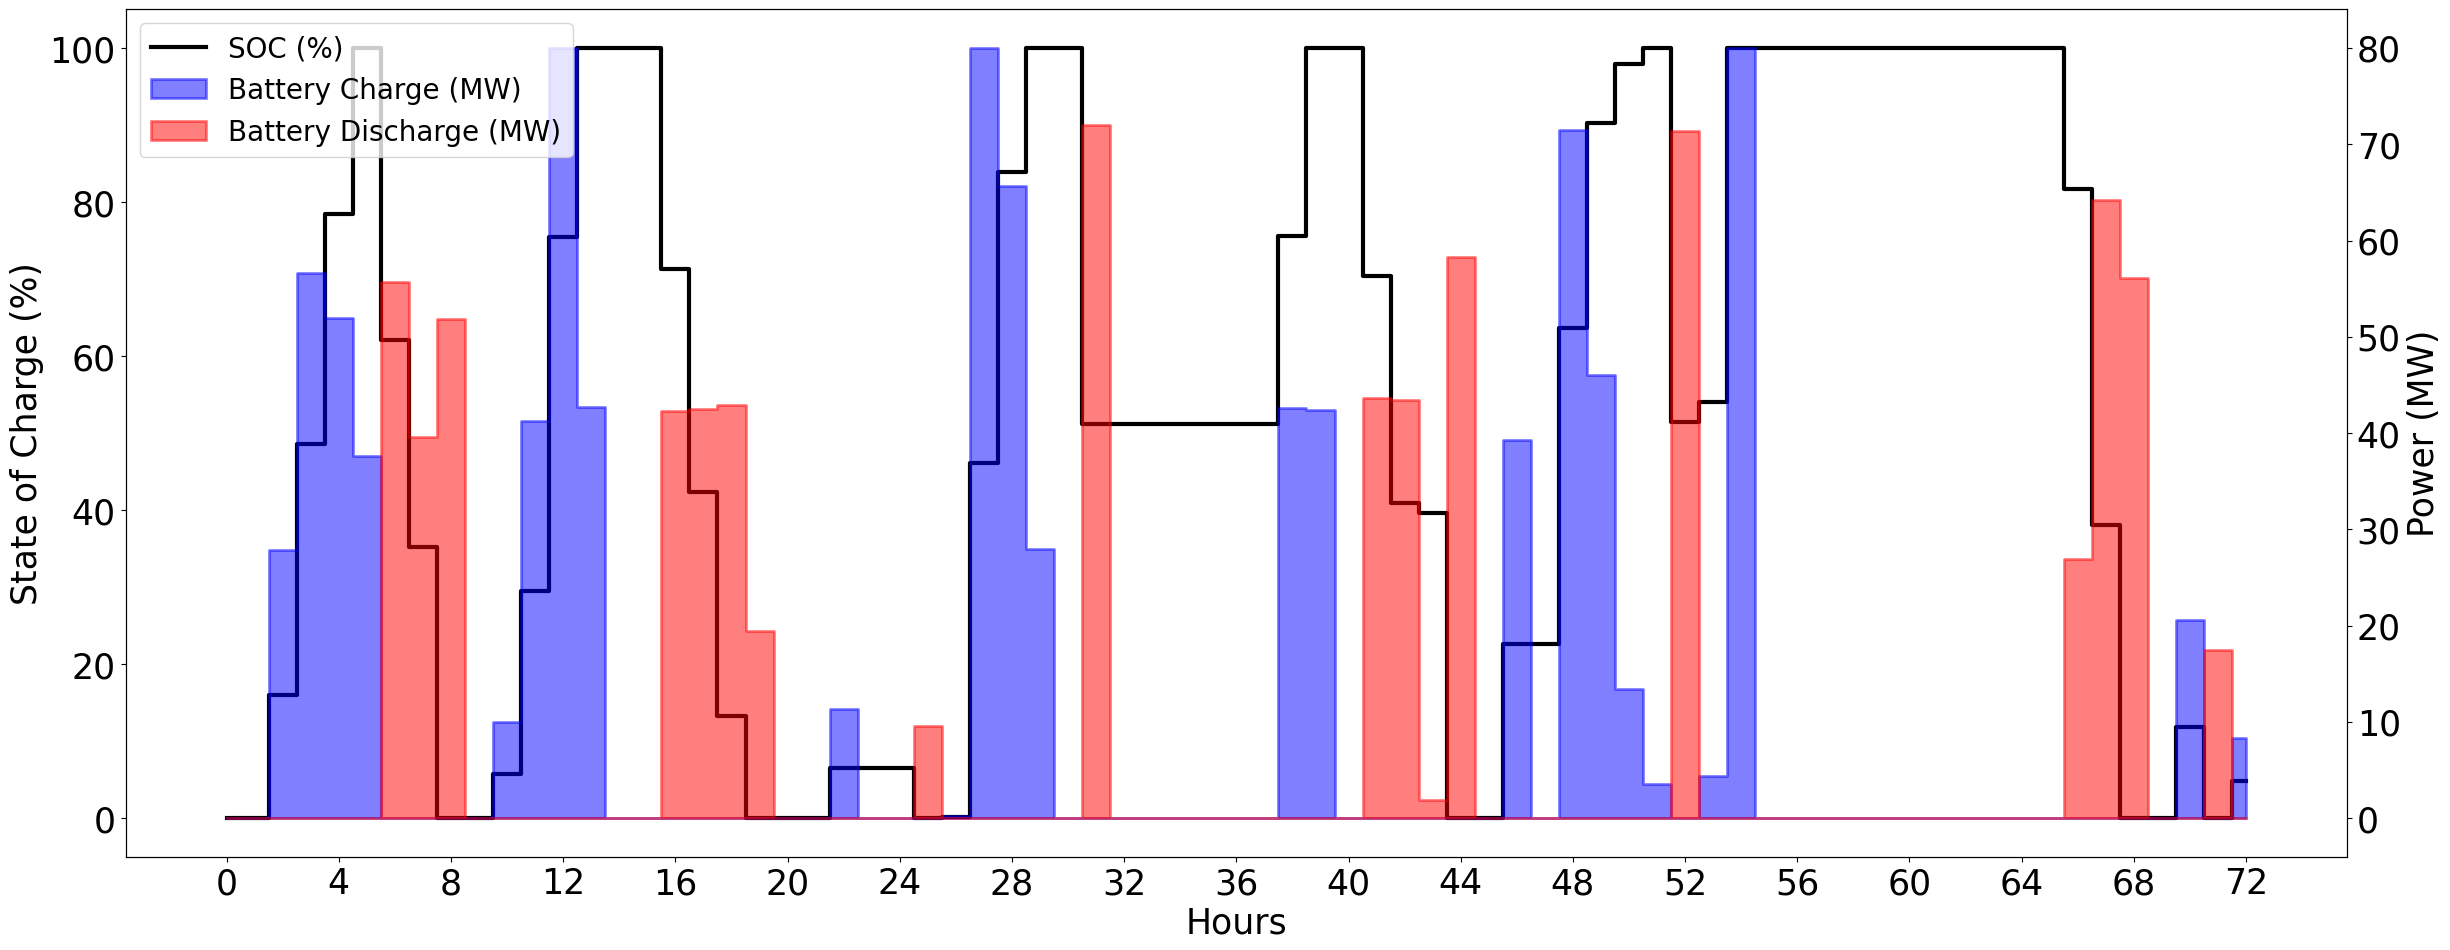

In [17]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = pd.to_datetime('2022-04-21 00:00:00')
end_date = pd.to_datetime('2022-04-24 00:00:00')

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)].copy()

# Calculate the number of hours from the start date for the x-axis
filtered_data.loc[:, 'Hours'] = (filtered_data['Timestamp'] - start_date).dt.total_seconds() / 3600

# Extract relevant columns
hours = filtered_data['Hours']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
soc_percentage = filtered_data['State of Charge (%)']
wind_generation = filtered_data['Wind Generation (MW)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot SOC% on the left Y-axis in step pattern
ax1.step(hours, soc_percentage, label='SOC (%)', color='k', linestyle='-', linewidth=3, where='mid')
ax1.set_xlabel('Hours', fontsize=25)
ax1.set_ylabel('State of Charge (%)', color='k', fontsize=25)
ax1.tick_params(axis='y', labelcolor='k', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)

# Set x-axis range to 4-hour intervals
hour_range = np.arange(0, hours.max() + 1, 4)
ax1.set_xticks(hour_range)
ax1.set_xticklabels([str(int(hr)) for hr in hour_range], fontsize=25)

# Create a second Y-axis for wind energy and battery charge/discharge
ax2 = ax1.twinx()
ax2.fill_between(hours, battery_store, label='Battery Charge (MW)', color='blue', linewidth=2, step="mid", alpha=0.5)
ax2.fill_between(hours, battery_dispatch, label='Battery Discharge (MW)', color='red', linewidth=2, step="mid", alpha=0.5)
ax2.set_ylabel('Power (MW)', fontsize=25)
ax2.tick_params(axis='y', labelsize=25)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC and Battery Charging Pattern_area_hours.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC_Battery_Charging_Price_Pattern_hours_price_soc.png


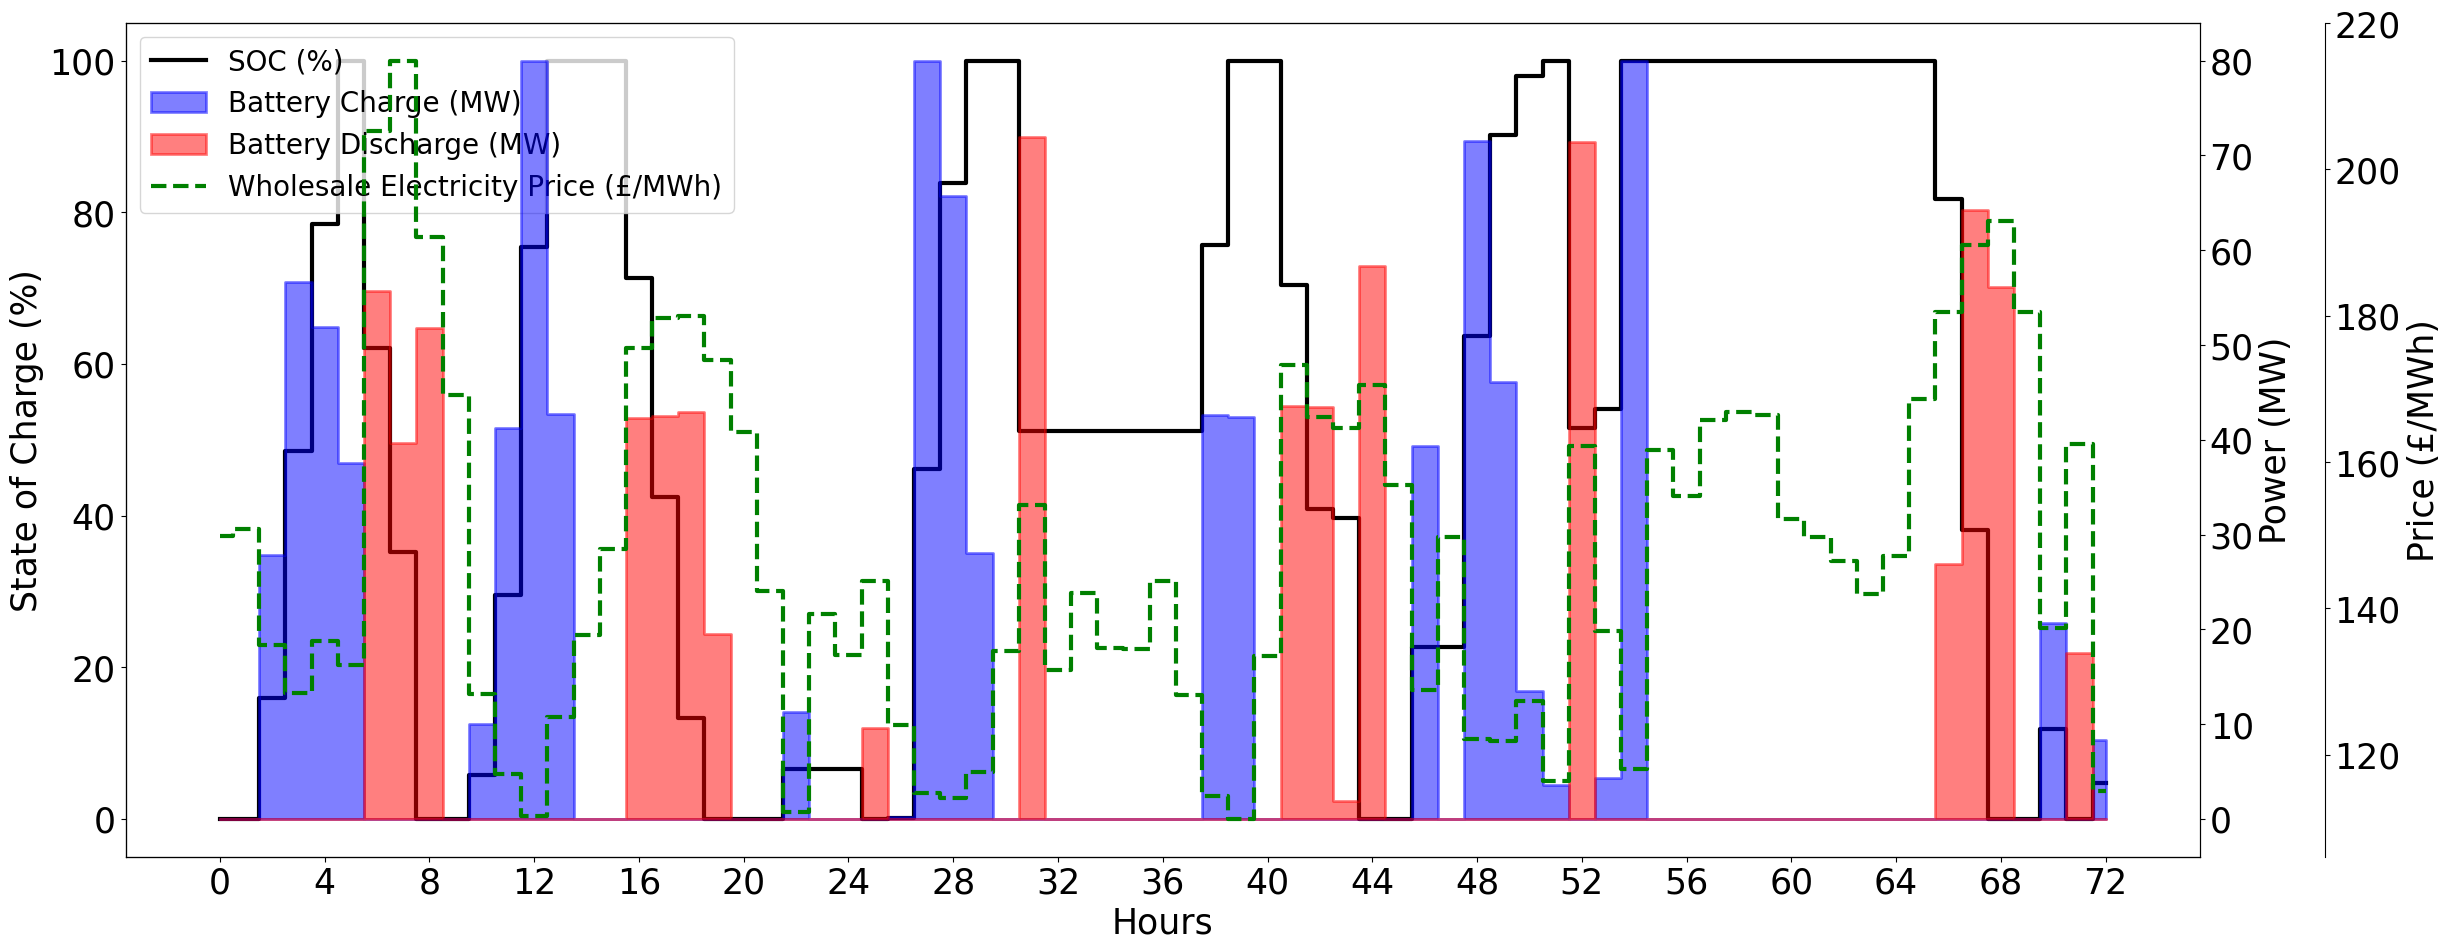

In [18]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = pd.to_datetime('2022-04-21 00:00:00')
end_date = pd.to_datetime('2022-04-24 00:00:00')

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)].copy()

# Calculate the number of hours from the start date for the x-axis
filtered_data.loc[:, 'Hours'] = (filtered_data['Timestamp'] - start_date).dt.total_seconds() / 3600

# Extract relevant columns
hours = filtered_data['Hours']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
soc_percentage = filtered_data['State of Charge (%)']
wind_generation = filtered_data['Wind Generation (MW)']
market_price = filtered_data['Market Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot SOC% on the left Y-axis in step pattern
ax1.step(hours, soc_percentage, label='SOC (%)', color='k', linestyle='-', linewidth=3, where='mid')
ax1.set_xlabel('Hours', fontsize=25)
ax1.set_ylabel('State of Charge (%)', color='k', fontsize=25)
ax1.tick_params(axis='y', labelcolor='k', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)

# Set x-axis range to 4-hour intervals
hour_range = np.arange(0, hours.max() + 1, 4)
ax1.set_xticks(hour_range)
ax1.set_xticklabels([str(int(hr)) for hr in hour_range], fontsize=25)

# Create a second Y-axis for battery charge/discharge
ax2 = ax1.twinx()
ax2.fill_between(hours, battery_store, label='Battery Charge (MW)', color='blue', linewidth=2, step="mid", alpha=0.5)
ax2.fill_between(hours, battery_dispatch, label='Battery Discharge (MW)', color='red', linewidth=2, step="mid", alpha=0.5)
ax2.set_ylabel('Power (MW)', fontsize=25)
ax2.tick_params(axis='y', labelsize=25)

# Create a third Y-axis for market price in step pattern
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 90))  # Offset the third axis further outward
ax3.step(hours, market_price, label='Wholesale Electricity Price (£/MWh)', color='g', linestyle='--', linewidth=3, where='mid')
ax3.set_ylabel('Price (£/MWh)', fontsize=25)
ax3.tick_params(axis='y', labelsize=25)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left', fontsize=20)

plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC_Battery_Charging_Price_Pattern_hours_price_soc.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC_Price_Pattern_hours_price_soc.png


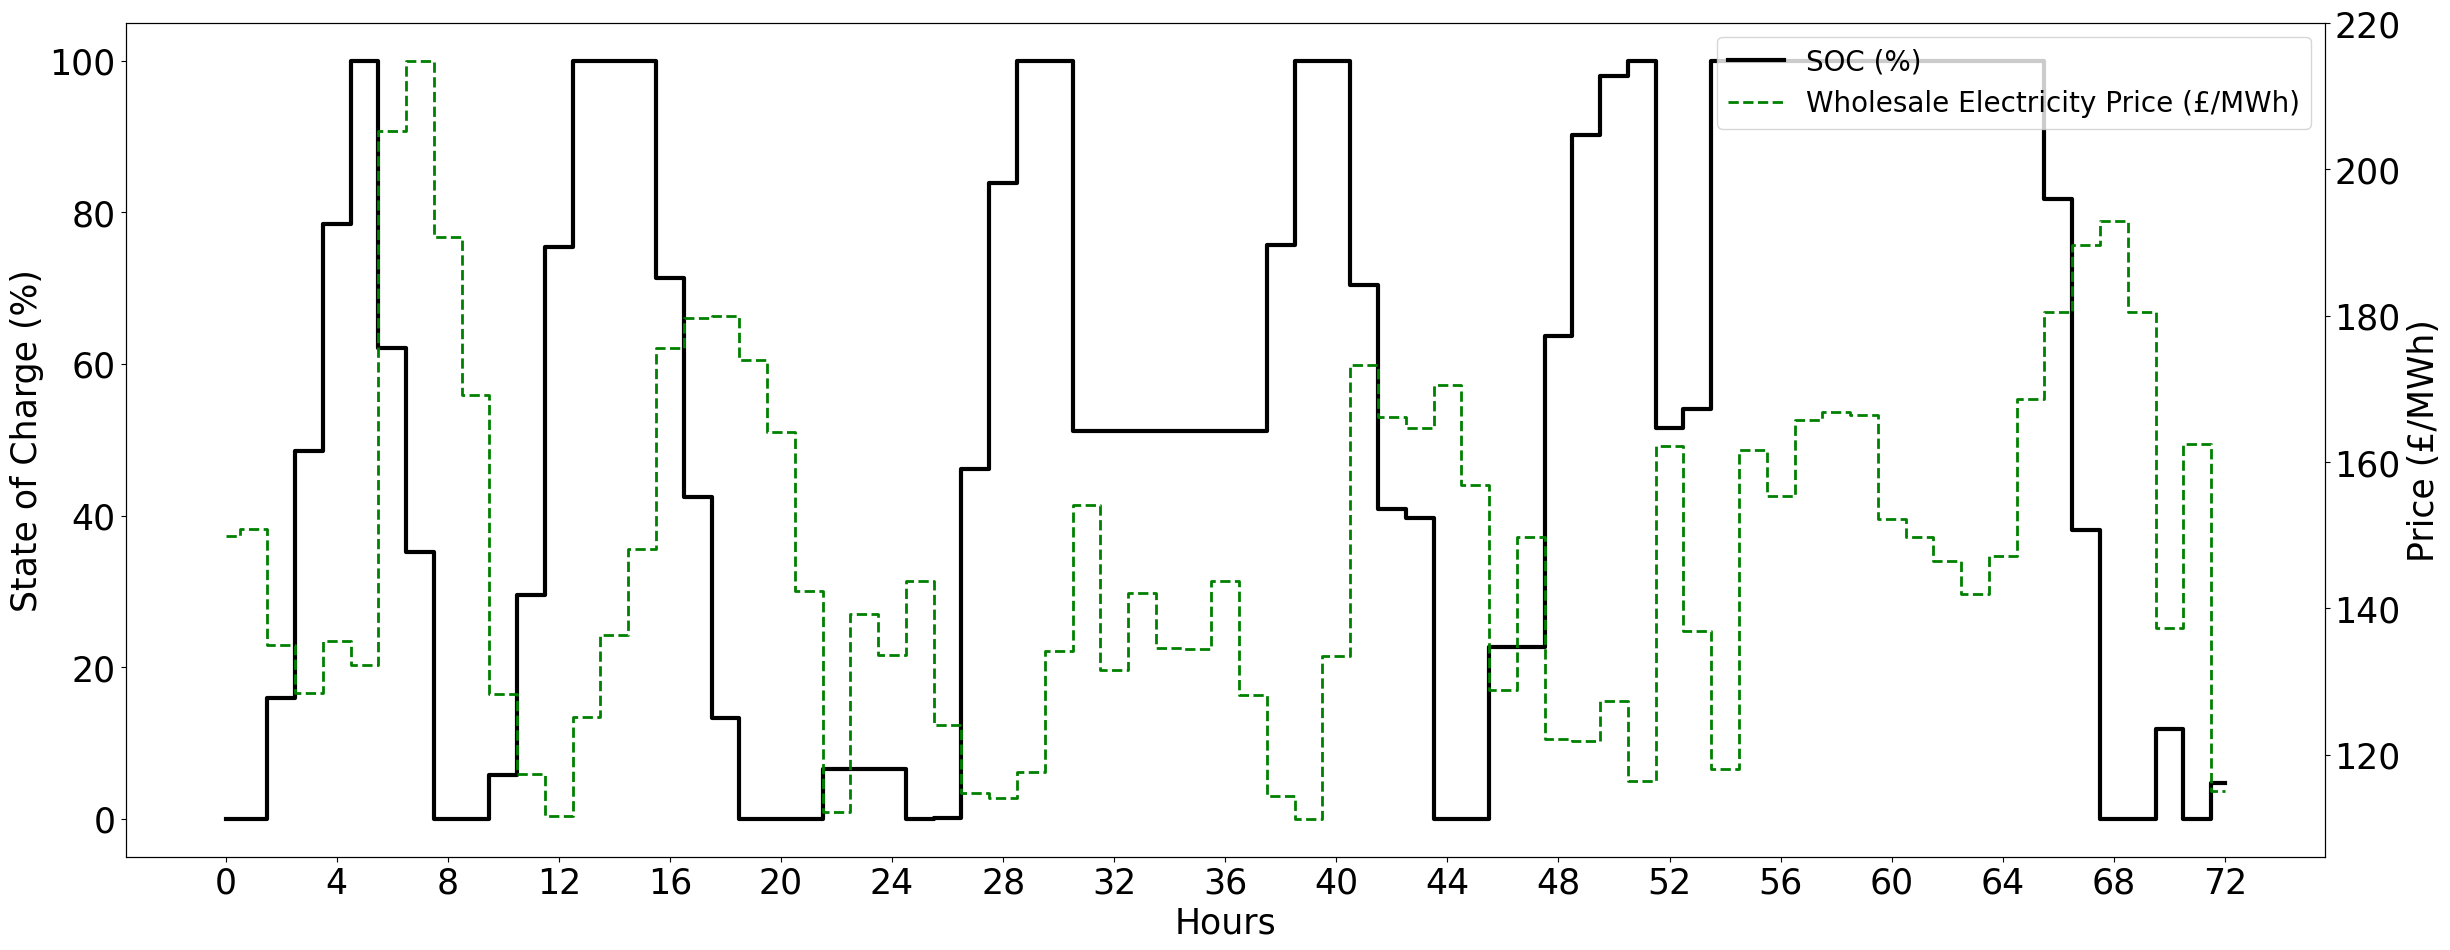

In [19]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = pd.to_datetime('2022-04-21 00:00:00')
end_date = pd.to_datetime('2022-04-24 00:00:00')

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)].copy()

# Calculate the number of hours from the start date for the x-axis
filtered_data.loc[:, 'Hours'] = (filtered_data['Timestamp'] - start_date).dt.total_seconds() / 3600

# Extract relevant columns
hours = filtered_data['Hours']
soc_percentage = filtered_data['State of Charge (%)']
market_price = filtered_data['Market Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot SOC% on the left Y-axis in step pattern
ax1.step(hours, soc_percentage, label='SOC (%)', color='k', linestyle='-', linewidth=3, where='mid')
ax1.set_xlabel('Hours', fontsize=25)
ax1.set_ylabel('State of Charge (%)', color='k', fontsize=25)
ax1.tick_params(axis='y', labelcolor='k', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)

# Set x-axis range to 4-hour intervals
hour_range = np.arange(0, hours.max() + 1, 4)
ax1.set_xticks(hour_range)
ax1.set_xticklabels([str(int(hr)) for hr in hour_range], fontsize=25)

# Plot market price on the right Y-axis in step pattern
ax2 = ax1.twinx()
ax2.step(hours, market_price, label='Wholesale Electricity Price (£/MWh)', color='g', linestyle='--', linewidth=2, where='mid')
ax2.set_ylabel('Price (£/MWh)', fontsize=25)
ax2.tick_params(axis='y', labelsize=25)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=20)

plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC_Price_Pattern_hours_price_soc.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC and Market Price Plot.png


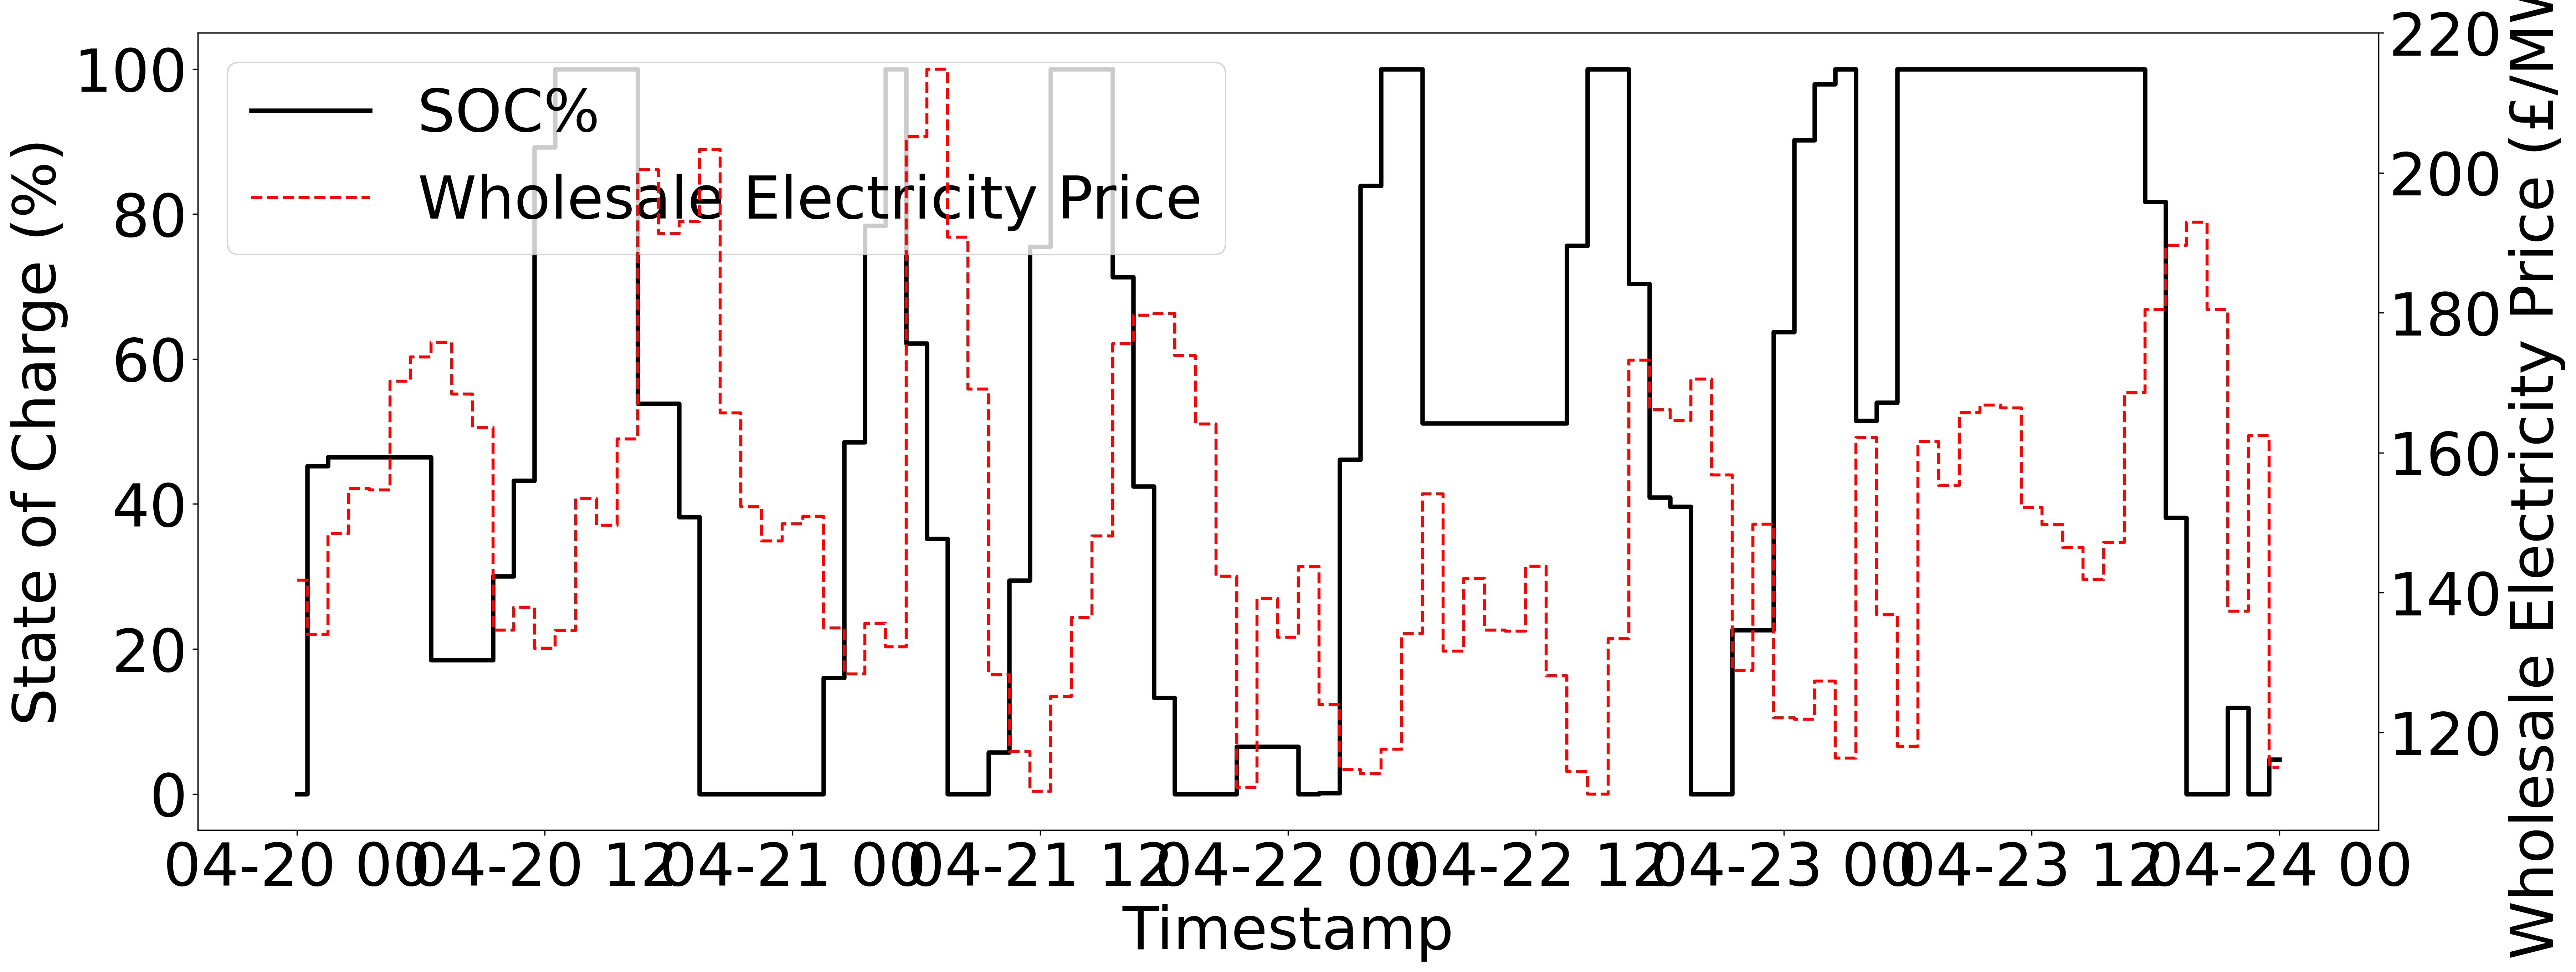

In [20]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
results_df = pd.read_excel(file_path, parse_dates=['Timestamp'])
results_df.set_index('Timestamp', inplace=True)

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
filtered_df = results_df.loc[start_date:end_date]

# Set font sizes
plt.rcParams.update({
    'font.size': 40,           # Global font size
    'axes.titlesize': 40,      # Title font size
    'axes.labelsize': 40,      # X and Y label size
    'xtick.labelsize': 40,     # X tick label size
    'ytick.labelsize': 40,     # Y tick label size
    'legend.fontsize': 40,     # Legend font size
})

# Plot SOC% and Market Price
fig, ax1 = plt.subplots(figsize=(25, 10), dpi=300)

ax1.step(filtered_df.index, filtered_df['State of Charge (%)'], where='mid', label='SOC%', linewidth=3, color='k')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('State of Charge (%)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()
ax2.step(filtered_df.index, filtered_df['Market Price (£/MWh)'], where='mid', label='Wholesale Electricity Price', linewidth=2, linestyle='--', color='r')
ax2.set_ylabel('Wholesale Electricity Price (£/MWh)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Add a single legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/SOC and Market Price Plot.png'
plt.savefig(output_plot_path, bbox_inches='tight', dpi=300, transparent=True)
print(f"Plot saved to {output_plot_path}")

# Show the plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery_Revenue_Streams_Two_Buses.png


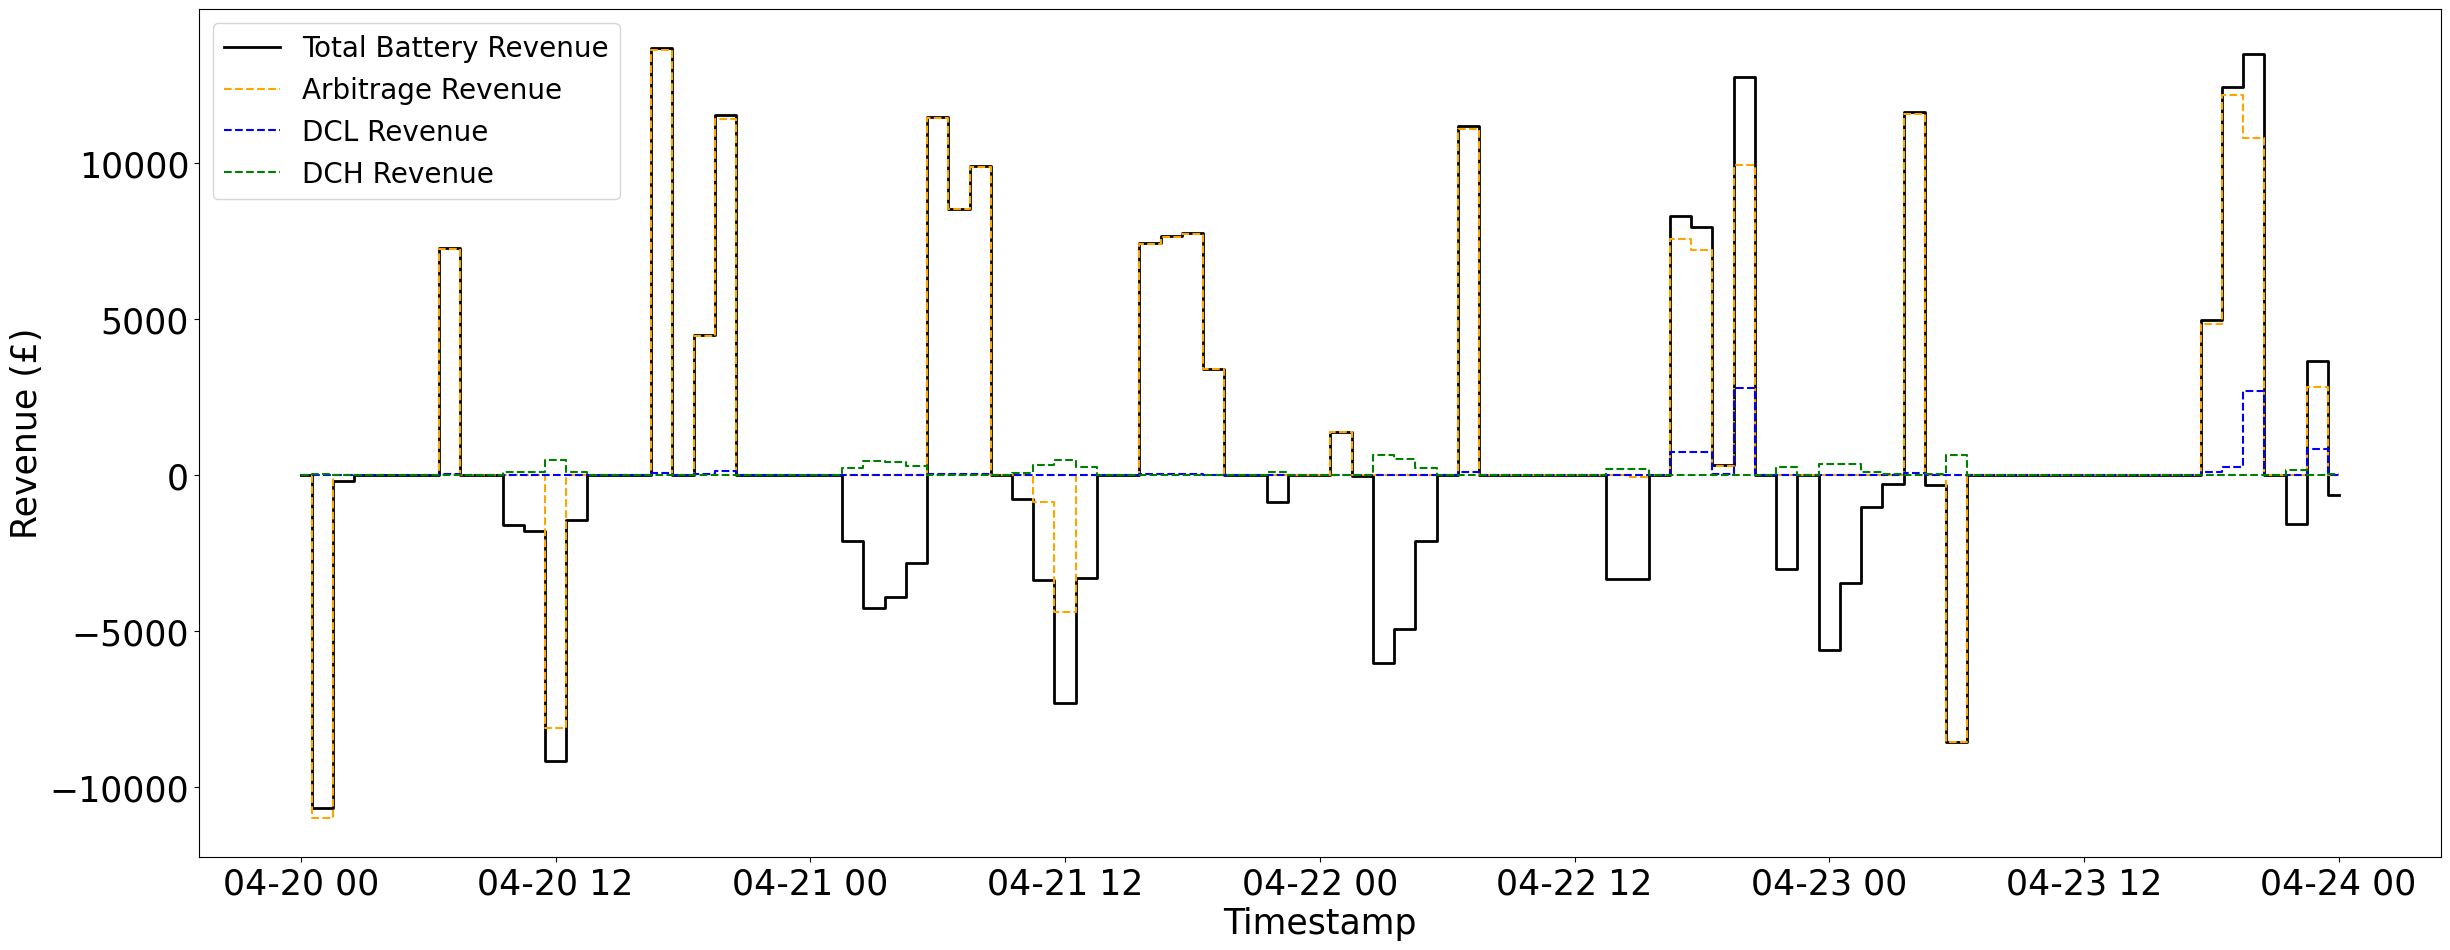

In [21]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
mask = (data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)
filtered_data = data.loc[mask]

# Set font sizes
plt.rcParams.update({
    'font.size': 25,         # General font size
    'axes.labelsize': 25,    # X and Y label font size
    'xtick.labelsize': 25,   # X tick label font size
    'ytick.labelsize': 25,   # Y tick label font size
    'legend.fontsize': 20,   # Legend font size
})

# Plot the revenues
plt.figure(figsize=(25, 10))

plt.step(filtered_data['Timestamp'], filtered_data['Battery Revenue (£)'], where='mid', linestyle='-', linewidth=2, label='Total Battery Revenue', color='k')
plt.step(filtered_data['Timestamp'], filtered_data['Arbitrage Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='Arbitrage Revenue', color='orange')
plt.step(filtered_data['Timestamp'], filtered_data['DCL Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='DCL Revenue', color='b')
plt.step(filtered_data['Timestamp'], filtered_data['DCH Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='DCH Revenue', color='g')

plt.xlabel('Timestamp')
plt.ylabel('Revenue (£)')
plt.legend()
plt.grid(False)
plt.tight_layout(pad=1.0)

# Save the plot
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Battery_Revenue_Streams_Two_Buses.png'
plt.savefig(output_image_path)
print(f"Plot saved to {output_image_path}")

# Show the plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Project_Revenue_Two_Buses.png


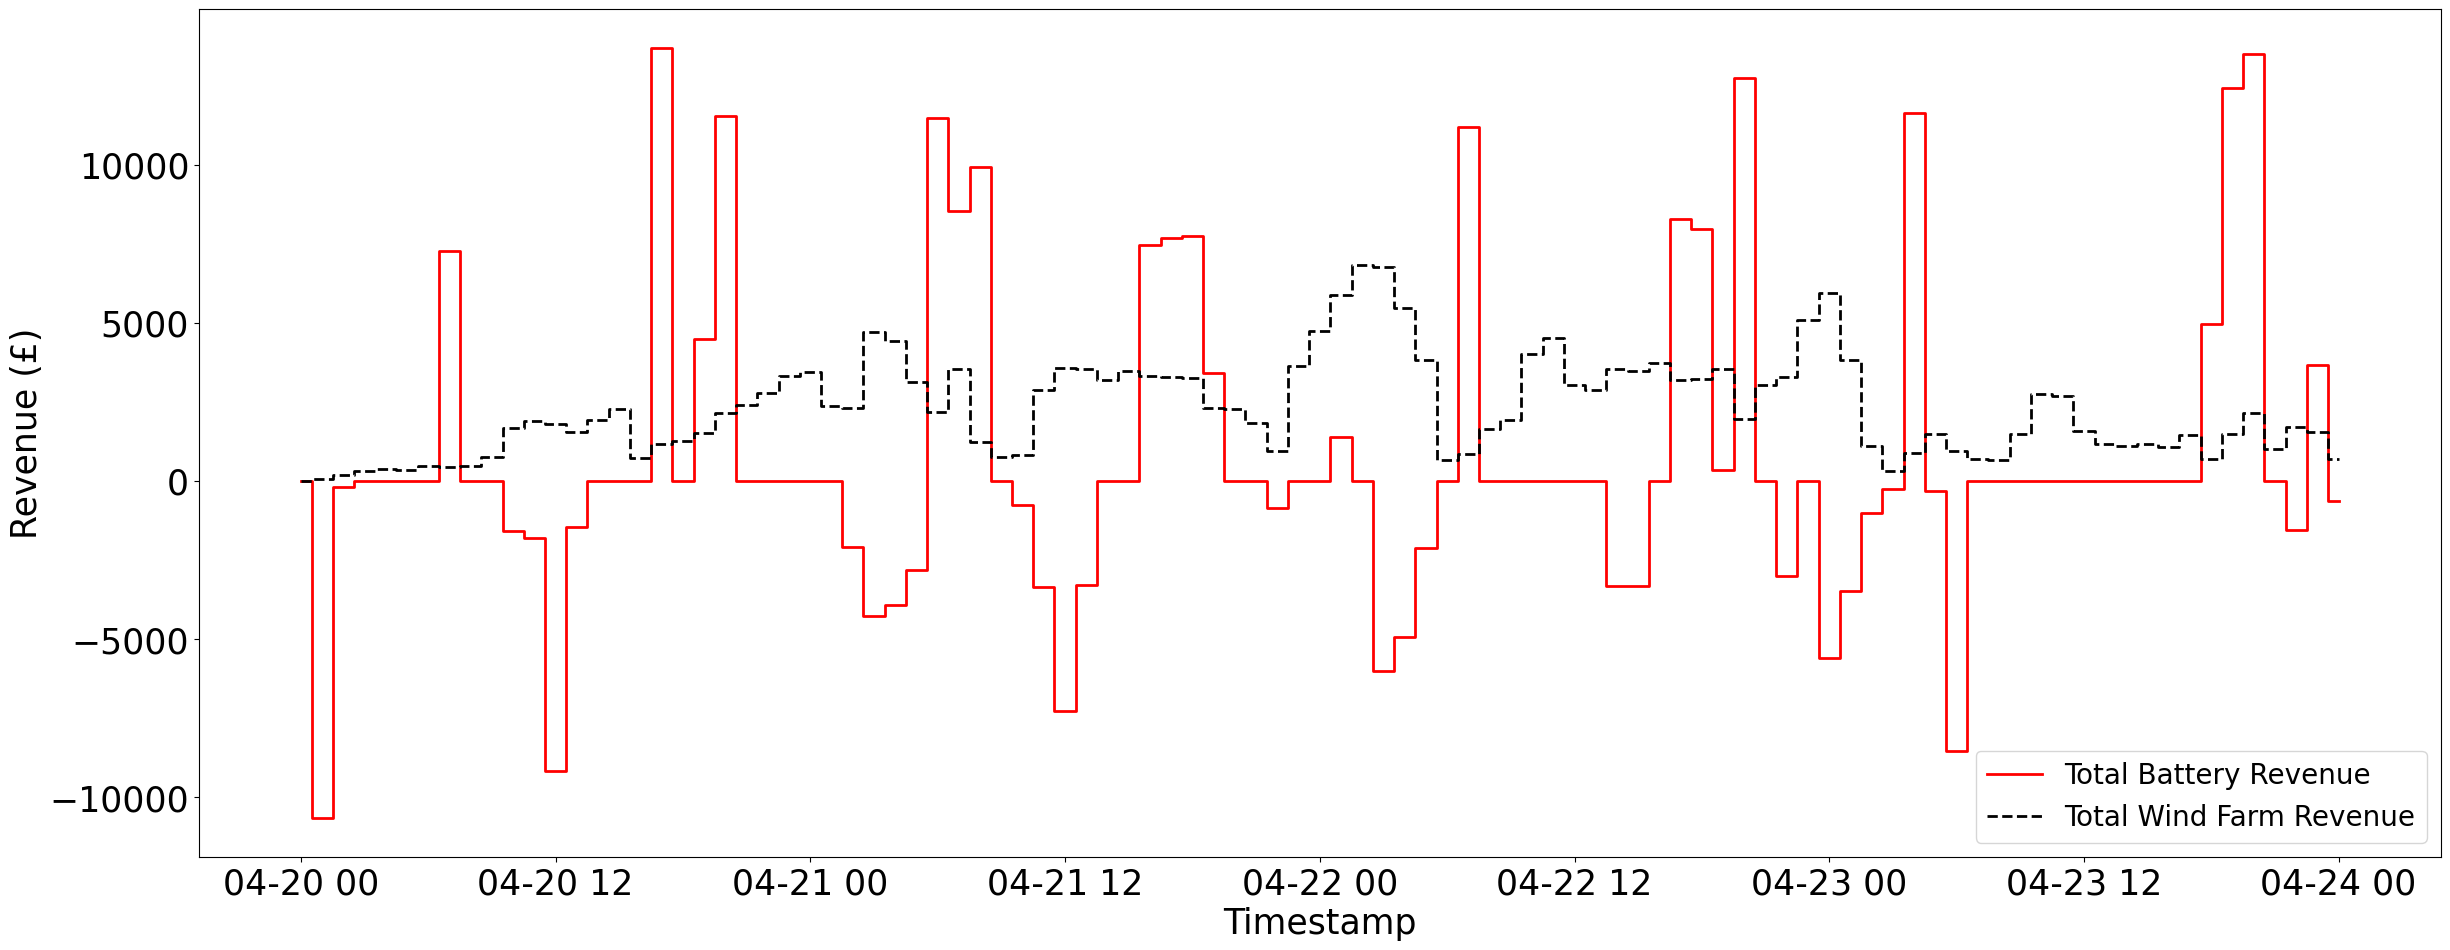

In [22]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Optimization_Results_with_Revenue_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
mask = (data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)
filtered_data = data.loc[mask]

# Set font sizes
plt.rcParams.update({'font.size': 25})
label_fontsize = 25
legend_fontsize = 20
tick_fontsize = 25

# Plot the revenues
plt.figure(figsize=(25, 10))

plt.step(filtered_data['Timestamp'], filtered_data['Battery Revenue (£)'], where='mid', linestyle='-', linewidth=2, label='Total Battery Revenue', color='r')
plt.step(filtered_data['Timestamp'], filtered_data['CFD Revenue (£)'], where='mid', linestyle='--', linewidth=2, label='Total Wind Farm Revenue', color='k')

plt.xlabel('Timestamp', fontsize=label_fontsize)
plt.ylabel('Revenue (£)', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.tight_layout()
plt.tight_layout(pad=1.0)

# Save the plot
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Project_Revenue_Two_Buses.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show the plot
plt.show()


In [23]:
# Base parameters
base_capex = 1004099
base_opex = 22261
base_price_escalation = 0.10
base_discount_rate = 0.07
base_lifetime = 15
base_duration = 2
base_market_prices = market_prices  # You need to have market_prices defined earlier
base_efficiency_store = 0.92
base_efficiency_dispatch = 0.92
base_battery_capacity_mw = network.storage_units.loc["battery", "p_nom_opt"] 
base_degradation_rate = 0.0155   
base_cfd_strike_price = 83.22  
base_grid_capacity = 82  # Added Grid Capacity base value

# Function to run the optimization and calculate financial metrics
def run_optimization(capex, opex, price_escalation, discount_rate, lifetime, duration, market_prices, efficiency_store, efficiency_dispatch, battery_capacity_mw, degradation_rate, cfd_strike_price, grid_capacity):
    # Initialize the network
    network = pypsa.Network()
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,
                p_set=wind_generation_profile.values,
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom=battery_capacity_mw,
                max_hours=duration,
                marginal_cost=0.01,
                capital_cost=capex,
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=efficiency_store,
                efficiency_dispatch=efficiency_dispatch)

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
            "Backup Generator",
            bus="grid_bus",
            p_nom_extendable=True,
            marginal_cost=market_prices.values,
            capital_cost=1100000)

    network.add("Link",
            "wind_to_grid",
            bus0="wind_bus",
            bus1="grid_bus",
            efficiency=0.95,
            p_nom=grid_capacity)  # Updated parameter

    network.add("Link",
            "grid_to_wind",
            bus0="grid_bus",
            bus1="wind_bus",
            efficiency=0.95,
            p_nom=grid_capacity)  # Updated parameter

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]
    grid_to_wind = network.links_t.p0.loc[:, "grid_to_wind"]

    # Calculate revenues
    arbitrage_cost = grid_to_wind * market_prices
    wind_to_battery_cost = (battery_store - grid_to_wind) * cfd_strike_price
    arbitrage_revenue = (battery_dispatch * market_prices) - arbitrage_cost
    dcl_revenue = battery_dispatch * dcl_prices
    dch_revenue = battery_store * dch_prices
    battery_revenue = (arbitrage_revenue + dcl_revenue + dch_revenue - wind_to_battery_cost).sum()

    # Project parameters
    annual_battery_revenue = battery_revenue

    # Total CAPEX
    total_capex = battery_size_mw * capex

    # Calculate annual battery revenues with cumulative degradation and escalation
    annual_battery_revenues = []
    degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(int(lifetime)):
        degradation_multiplier *= (1 - degradation_rate)  # Apply cumulative degradation
        escalated_revenue = annual_battery_revenue * degradation_multiplier * (1 + price_escalation) ** year
        annual_battery_revenues.append(escalated_revenue)

    annual_opex = [
        (opex * battery_size_mw * (1 + price_escalation) ** year)
        for year in range(int(lifetime))
    ]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100

    # Payback Period Calculation
    cumulative_cash_flow = 0
    payback_period = None
    for year, cash_flow in enumerate(annual_cash_flows):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0 and payback_period is None:
            payback_period = year

    # Total Charging Costs
    total_arbitrage_cost = arbitrage_cost.sum() * lifetime
    total_wind_to_battery_cost = wind_to_battery_cost.sum() * lifetime

    # Discounted total charging costs
    discounted_arbitrage_cost = total_arbitrage_cost / ((1 + discount_rate) ** lifetime)
    discounted_wind_to_battery_cost = total_wind_to_battery_cost / ((1 + discount_rate) ** lifetime)

    # Sum total discounted charging costs
    total_discounted_charging_costs = discounted_arbitrage_cost + discounted_wind_to_battery_cost

    # Total discounted costs including charging costs
    total_discounted_costs_with_charging = total_capex + total_discounted_charging_costs + sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    # Calculate cumulative degradation multiplier over the battery lifetime
    cumulative_degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(lifetime):
        cumulative_degradation_multiplier *= (1 - degradation_rate)

    # Total energy dispatched over the lifetime (MWh) using cumulative degradation multiplier
    total_energy_dispatched = battery_dispatch.sum() * lifetime * cumulative_degradation_multiplier

    # Updated LCOS calculation with charging costs included
    lcos_with_charging = total_discounted_costs_with_charging / total_energy_dispatched

    return {
        "NPV": npv,
        "IRR": irr,
        "LCOS": lcos_with_charging,
        "Payback Period": payback_period,
        "Total CAPEX": total_capex,
        "Total Discounted Charging Costs": total_discounted_charging_costs,
        "Total Discounted Costs Including Charging": total_discounted_costs_with_charging,
        "Total Energy Dispatched (MWh)": total_energy_dispatched,
    }

# Parameters for sensitivity analysis
parameters = {
    "capex_per_mw": base_capex,
    "opex_per_mw_per_year": base_opex,
    "price_escalation_rate": base_price_escalation,
    "discount_rate": base_discount_rate,
    "battery_lifetime": base_lifetime,
    "battery_duration": base_duration,
    "market_price": base_market_prices,
    "round_trip_efficiency": base_efficiency_store * base_efficiency_dispatch,
    "battery_capacity_mw": base_battery_capacity_mw,
    "degradation_rate": base_degradation_rate,
    "cfd_strike_price": base_cfd_strike_price,
    "grid_capacity": base_grid_capacity  # Added Grid Capacity
}

# Results storage
results = []

# Run sensitivity analysis
for param in parameters.keys():
    for change in [1.1, 0.90]:
        modified_parameters = parameters.copy()
        modified_value = parameters[param] * change
        
        # Ensure battery_lifetime remains an integer
        if param == "battery_lifetime":
            modified_value = int(modified_value)
        
        modified_parameters[param] = modified_value
        
        # Adjust efficiency parameters if round_trip_efficiency is changed
        if param == "round_trip_efficiency":
            modified_parameters["efficiency_store"] = np.sqrt(modified_value)
            modified_parameters["efficiency_dispatch"] = np.sqrt(modified_value)
        else:
            modified_parameters["efficiency_store"] = base_efficiency_store
            modified_parameters["efficiency_dispatch"] = base_efficiency_dispatch

        results_dict = run_optimization(
            modified_parameters["capex_per_mw"],
            modified_parameters["opex_per_mw_per_year"],
            modified_parameters["price_escalation_rate"],
            modified_parameters["discount_rate"],
            modified_parameters["battery_lifetime"],
            modified_parameters["battery_duration"],
            modified_parameters["market_price"],
            modified_parameters["efficiency_store"],
            modified_parameters["efficiency_dispatch"],
            modified_parameters["battery_capacity_mw"],
            modified_parameters["degradation_rate"],
            modified_parameters["cfd_strike_price"],
            modified_parameters["grid_capacity"]  # Added Grid Capacity parameter
        )
        
        # Add the parameter and change information to results_dict
        results_dict.update({
            'parameter': param,
            'change': change,
        })

        results.append(results_dict)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx'
results_df.to_excel(output_path, index=False)

print("Sensitivity analysis results saved to", output_path)


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 121.68it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yze8y4_y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yze8y4_y.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 123.34it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-vv58olax.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-vv58olax.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.18 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.18 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 118.34it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-a8j1dazw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-a8j1dazw.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.16 seconds (0.19 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.16 seconds (0.19 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 124.51it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_fcz2hnx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_fcz2hnx.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


   8   1.97091039e+11  1.97089220e+11  3.55e-14 1.59e-09  2.08e+01     0s


INFO:gurobipy:   8   1.97091039e+11  1.97089220e+11  3.55e-14 1.59e-09  2.08e+01     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.16 seconds (0.23 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.16 seconds (0.23 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 126.84it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ilos5_h0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ilos5_h0.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.15 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.15 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.18 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.18 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.70it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-lrcsp7p5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-lrcsp7p5.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.15 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.15 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.17 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.17 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.04it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8beia1_n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8beia1_n.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.15 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.15 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.18 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.18 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 125.88it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-jfrl27xg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-jfrl27xg.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.18 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.18 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.39it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5dzslj2x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5dzslj2x.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 125.52it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-k30z1zxd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-k30z1zxd.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 126.99it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-r89sykh7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-r89sykh7.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xa8edb338


INFO:gurobipy:Model fingerprint: 0xa8edb338


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215835e+11 -3.47510544e+12  9.21e+00 2.55e+02  7.77e+07     0s


INFO:gurobipy:   0   1.97215835e+11 -3.47510544e+12  9.21e+00 2.55e+02  7.77e+07     0s


   1   1.97177500e+11 -5.62553481e+11  7.11e-15 3.49e-09  8.71e+06     0s


INFO:gurobipy:   1   1.97177500e+11 -5.62553481e+11  7.11e-15 3.49e-09  8.71e+06     0s


   2   1.97113742e+11  1.84431307e+11  1.78e-14 1.68e-09  1.45e+05     0s


INFO:gurobipy:   2   1.97113742e+11  1.84431307e+11  1.78e-14 1.68e-09  1.45e+05     0s


   3   1.97112723e+11  1.96922202e+11  2.84e-14 5.90e-11  2.18e+03     0s


INFO:gurobipy:   3   1.97112723e+11  1.96922202e+11  2.84e-14 5.90e-11  2.18e+03     0s


   4   1.97105768e+11  1.97050003e+11  3.20e-14 8.94e-10  6.39e+02     0s


INFO:gurobipy:   4   1.97105768e+11  1.97050003e+11  3.20e-14 8.94e-10  6.39e+02     0s


   5   1.97098809e+11  1.97076779e+11  2.66e-14 4.71e-12  2.52e+02     0s


INFO:gurobipy:   5   1.97098809e+11  1.97076779e+11  2.66e-14 4.71e-12  2.52e+02     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   18426    1.9708971e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   18426    1.9708971e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18426 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 18426 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970897069e+11


INFO:gurobipy:Optimal objective  1.970897069e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.39it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-hwamu6uw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-hwamu6uw.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x672268be


INFO:gurobipy:Model fingerprint: 0x672268be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215646e+11 -3.27227559e+12  8.95e+00 2.55e+02  7.44e+07     0s


INFO:gurobipy:   0   1.97215646e+11 -3.27227559e+12  8.95e+00 2.55e+02  7.44e+07     0s


   1   1.97179008e+11 -5.47367299e+11  7.11e-15 3.71e-09  8.53e+06     0s


INFO:gurobipy:   1   1.97179008e+11 -5.47367299e+11  7.11e-15 3.71e-09  8.53e+06     0s


   2   1.97113761e+11  1.84948548e+11  2.38e-14 1.88e-09  1.39e+05     0s


INFO:gurobipy:   2   1.97113761e+11  1.84948548e+11  2.38e-14 1.88e-09  1.39e+05     0s


   3   1.97112745e+11  1.96937784e+11  2.13e-14 1.86e-09  2.01e+03     0s


INFO:gurobipy:   3   1.97112745e+11  1.96937784e+11  2.13e-14 1.86e-09  2.01e+03     0s


   4   1.97105945e+11  1.97056157e+11  2.66e-14 9.31e-10  5.71e+02     0s


INFO:gurobipy:   4   1.97105945e+11  1.97056157e+11  2.66e-14 9.31e-10  5.71e+02     0s


   5   1.97098803e+11  1.97079390e+11  1.90e-14 1.76e-10  2.22e+02     0s


INFO:gurobipy:   5   1.97098803e+11  1.97079390e+11  1.90e-14 1.76e-10  2.22e+02     0s


   6   1.97094167e+11  1.97086481e+11  1.52e-14 1.82e-12  8.81e+01     0s


INFO:gurobipy:   6   1.97094167e+11  1.97086481e+11  1.52e-14 1.82e-12  8.81e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17777    1.9709048e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17777    1.9709048e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17777 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17777 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970904805e+11


INFO:gurobipy:Optimal objective  1.970904805e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 124.98it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-l2xyr8rr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-l2xyr8rr.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x58c34695


INFO:gurobipy:Model fingerprint: 0x58c34695


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.06803824e+11 -3.36418402e+12  9.08e+00 2.81e+02  7.61e+07     0s


INFO:gurobipy:   0   2.06803824e+11 -3.36418402e+12  9.08e+00 2.81e+02  7.61e+07     0s


   1   2.06765873e+11 -5.45611324e+11  8.88e-15 3.73e-09  8.62e+06     0s


INFO:gurobipy:   1   2.06765873e+11 -5.45611324e+11  8.88e-15 3.73e-09  8.62e+06     0s


   2   2.06701413e+11  1.94222606e+11  1.52e-14 1.58e-09  1.43e+05     0s


INFO:gurobipy:   2   2.06701413e+11  1.94222606e+11  1.52e-14 1.58e-09  1.43e+05     0s


   3   2.06700334e+11  2.06502013e+11  2.84e-14 1.86e-09  2.27e+03     0s


INFO:gurobipy:   3   2.06700334e+11  2.06502013e+11  2.84e-14 1.86e-09  2.27e+03     0s


   4   2.06692547e+11  2.06634927e+11  2.49e-14 8.84e-10  6.60e+02     0s


INFO:gurobipy:   4   2.06692547e+11  2.06634927e+11  2.49e-14 8.84e-10  6.60e+02     0s


   5   2.06684998e+11  2.06661978e+11  1.78e-14 4.28e-10  2.64e+02     0s


INFO:gurobipy:   5   2.06684998e+11  2.06661978e+11  1.78e-14 4.28e-10  2.64e+02     0s


   6   2.06679802e+11  2.06670597e+11  2.22e-14 3.27e-12  1.05e+02     0s


INFO:gurobipy:   6   2.06679802e+11  2.06670597e+11  2.22e-14 3.27e-12  1.05e+02     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.17 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.17 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   18011    2.0667544e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   18011    2.0667544e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18011 iterations and 0.20 seconds (0.30 work units)


INFO:gurobipy:Solved in 18011 iterations and 0.20 seconds (0.30 work units)


Optimal objective  2.066754426e+11


INFO:gurobipy:Optimal objective  2.066754426e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 2.07e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 126.76it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-q957rqfb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-q957rqfb.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x2e77f620


INFO:gurobipy:Model fingerprint: 0x2e77f620


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.87627659e+11 -3.38319701e+12  9.08e+00 2.30e+02  7.61e+07     0s


INFO:gurobipy:   0   1.87627659e+11 -3.38319701e+12  9.08e+00 2.30e+02  7.61e+07     0s


   1   1.87590547e+11 -5.64752413e+11  7.11e-15 4.56e-09  8.62e+06     0s


INFO:gurobipy:   1   1.87590547e+11 -5.64752413e+11  7.11e-15 4.56e-09  8.62e+06     0s


   2   1.87526090e+11  1.75047637e+11  1.42e-14 1.76e-09  1.43e+05     0s


INFO:gurobipy:   2   1.87526090e+11  1.75047637e+11  1.42e-14 1.76e-09  1.43e+05     0s


   3   1.87525129e+11  1.87356862e+11  3.20e-14 1.86e-09  1.93e+03     0s


INFO:gurobipy:   3   1.87525129e+11  1.87356862e+11  3.20e-14 1.86e-09  1.93e+03     0s


   4   1.87518932e+11  1.87471016e+11  2.13e-14 1.86e-09  5.49e+02     0s


INFO:gurobipy:   4   1.87518932e+11  1.87471016e+11  2.13e-14 1.86e-09  5.49e+02     0s


   5   1.87512540e+11  1.87493471e+11  1.60e-14 4.28e-10  2.19e+02     0s


INFO:gurobipy:   5   1.87512540e+11  1.87493471e+11  1.60e-14 4.28e-10  2.19e+02     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   18117    1.8750471e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   18117    1.8750471e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18117 iterations and 0.18 seconds (0.30 work units)


INFO:gurobipy:Solved in 18117 iterations and 0.18 seconds (0.30 work units)


Optimal objective  1.875047096e+11


INFO:gurobipy:Optimal objective  1.875047096e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.88e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 123.01it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-m1mixw2p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-m1mixw2p.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xad52bed1


INFO:gurobipy:Model fingerprint: 0xad52bed1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97204258e+11 -3.30938434e+12  9.08e+00 2.53e+02  7.47e+07     0s


INFO:gurobipy:   0   1.97204258e+11 -3.30938434e+12  9.08e+00 2.53e+02  7.47e+07     0s


   1   1.97166766e+11 -5.39499178e+11  8.88e-15 4.01e-09  8.44e+06     0s


INFO:gurobipy:   1   1.97166766e+11 -5.39499178e+11  8.88e-15 4.01e-09  8.44e+06     0s


   2   1.97106643e+11  1.86075805e+11  1.42e-14 1.66e-09  1.26e+05     0s


INFO:gurobipy:   2   1.97106643e+11  1.86075805e+11  1.42e-14 1.66e-09  1.26e+05     0s


   3   1.97105901e+11  1.96955929e+11  3.73e-14 1.86e-09  1.72e+03     0s


INFO:gurobipy:   3   1.97105901e+11  1.96955929e+11  3.73e-14 1.86e-09  1.72e+03     0s


   4   1.97100535e+11  1.97034506e+11  3.02e-14 9.31e-10  7.57e+02     0s


INFO:gurobipy:   4   1.97100535e+11  1.97034506e+11  3.02e-14 9.31e-10  7.57e+02     0s


   5   1.97096447e+11  1.97065670e+11  3.38e-14 9.31e-10  3.53e+02     0s


INFO:gurobipy:   5   1.97096447e+11  1.97065670e+11  3.38e-14 9.31e-10  3.53e+02     0s


   6   1.97093140e+11  1.97079139e+11  2.49e-14 9.31e-10  1.60e+02     0s


INFO:gurobipy:   6   1.97093140e+11  1.97079139e+11  2.49e-14 9.31e-10  1.60e+02     0s


   7   1.97090795e+11  1.97084797e+11  4.26e-14 1.86e-09  6.87e+01     0s


INFO:gurobipy:   7   1.97090795e+11  1.97084797e+11  4.26e-14 1.86e-09  6.87e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.17 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.17 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19707    1.9708852e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   19707    1.9708852e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19707 iterations and 0.21 seconds (0.31 work units)


INFO:gurobipy:Solved in 19707 iterations and 0.21 seconds (0.31 work units)


Optimal objective  1.970885234e+11


INFO:gurobipy:Optimal objective  1.970885234e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 125.31it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-g9oljplf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-g9oljplf.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x04ae092d


INFO:gurobipy:Model fingerprint: 0x04ae092d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97228802e+11 -3.44504324e+12  9.08e+00 2.55e+02  7.76e+07     0s


INFO:gurobipy:   0   1.97228802e+11 -3.44504324e+12  9.08e+00 2.55e+02  7.76e+07     0s


   1   1.97190931e+11 -5.71433369e+11  7.11e-15 3.63e-09  8.81e+06     0s


INFO:gurobipy:   1   1.97190931e+11 -5.71433369e+11  7.11e-15 3.63e-09  8.81e+06     0s


   2   1.97121898e+11  1.82991068e+11  1.67e-14 1.58e-09  1.62e+05     0s


INFO:gurobipy:   2   1.97121898e+11  1.82991068e+11  1.67e-14 1.58e-09  1.62e+05     0s


   3   1.97120289e+11  1.96865280e+11  1.95e-14 1.86e-09  2.92e+03     0s


INFO:gurobipy:   3   1.97120289e+11  1.96865280e+11  1.95e-14 1.86e-09  2.92e+03     0s


   4   1.97110716e+11  1.97055366e+11  1.42e-14 9.31e-10  6.34e+02     0s


INFO:gurobipy:   4   1.97110716e+11  1.97055366e+11  1.42e-14 9.31e-10  6.34e+02     0s


   5   1.97100912e+11  1.97080243e+11  2.13e-14 1.86e-09  2.37e+02     0s


INFO:gurobipy:   5   1.97100912e+11  1.97080243e+11  2.13e-14 1.86e-09  2.37e+02     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.16 seconds (0.20 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   16938    1.9709139e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   16938    1.9709139e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16938 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 16938 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970913917e+11


INFO:gurobipy:Optimal objective  1.970913917e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 126.24it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-oj5eugjn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-oj5eugjn.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x9af2f49e


INFO:gurobipy:Model fingerprint: 0x9af2f49e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17483 columns


INFO:gurobipy:Presolve removed 139776 rows and 17483 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 17473 rows, 43670 columns, 69880 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43670 columns, 69880 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97218169e+11 -3.63034416e+12  9.40e+00 2.55e+02  8.02e+07     0s


INFO:gurobipy:   0   1.97218169e+11 -3.63034416e+12  9.40e+00 2.55e+02  8.02e+07     0s


   1   1.97177978e+11 -5.77585463e+11  7.11e-15 3.89e-09  8.87e+06     0s


INFO:gurobipy:   1   1.97177978e+11 -5.77585463e+11  7.11e-15 3.89e-09  8.87e+06     0s


   2   1.97115508e+11  1.84560829e+11  1.60e-14 1.97e-09  1.44e+05     0s


INFO:gurobipy:   2   1.97115508e+11  1.84560829e+11  1.60e-14 1.97e-09  1.44e+05     0s


   3   1.97114135e+11  1.96918047e+11  3.20e-14 1.12e-10  2.25e+03     0s


INFO:gurobipy:   3   1.97114135e+11  1.96918047e+11  3.20e-14 1.12e-10  2.25e+03     0s


   4   1.97106396e+11  1.97053292e+11  3.38e-14 2.49e-11  6.08e+02     0s


INFO:gurobipy:   4   1.97106396e+11  1.97053292e+11  3.38e-14 2.49e-11  6.08e+02     0s


   5   1.97098876e+11  1.97077025e+11  2.31e-14 8.47e-12  2.50e+02     0s


INFO:gurobipy:   5   1.97098876e+11  1.97077025e+11  2.31e-14 8.47e-12  2.50e+02     0s


   6   1.97094177e+11  1.97084262e+11  1.60e-14 3.34e-12  1.14e+02     0s


INFO:gurobipy:   6   1.97094177e+11  1.97084262e+11  1.60e-14 3.34e-12  1.14e+02     0s


   7   1.97092008e+11  1.97087214e+11  2.13e-14 1.82e-12  5.49e+01     0s


INFO:gurobipy:   7   1.97092008e+11  1.97087214e+11  2.13e-14 1.82e-12  5.49e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.20 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.20 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19712    1.9708966e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   19712    1.9708966e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19712 iterations and 0.23 seconds (0.30 work units)


INFO:gurobipy:Solved in 19712 iterations and 0.23 seconds (0.30 work units)


Optimal objective  1.970896630e+11


INFO:gurobipy:Optimal objective  1.970896630e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 104.77it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-sgs_5kl4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-sgs_5kl4.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0x38aa3f2b


INFO:gurobipy:Model fingerprint: 0x38aa3f2b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139785 rows and 17787 columns


INFO:gurobipy:Presolve removed 139785 rows and 17787 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17464 rows, 43366 columns, 69558 nonzeros


INFO:gurobipy:Presolved: 17464 rows, 43366 columns, 69558 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.746e+04


INFO:gurobipy: AA' NZ     : 1.746e+04


 Factor NZ  : 2.182e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.182e+05 (roughly 26 MB of memory)


 Factor Ops : 3.307e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.307e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97212902e+11 -3.10368052e+12  1.07e+01 2.55e+02  7.95e+07     0s


INFO:gurobipy:   0   1.97212902e+11 -3.10368052e+12  1.07e+01 2.55e+02  7.95e+07     0s


   1   1.97179370e+11 -6.82659077e+11  7.11e-15 4.00e-09  1.01e+07     0s


INFO:gurobipy:   1   1.97179370e+11 -6.82659077e+11  7.11e-15 4.00e-09  1.01e+07     0s


   2   1.97120909e+11  1.85295255e+11  8.88e-15 1.89e-09  1.36e+05     0s


INFO:gurobipy:   2   1.97120909e+11  1.85295255e+11  8.88e-15 1.89e-09  1.36e+05     0s


   3   1.97120284e+11  1.96943276e+11  1.78e-14 8.94e-10  2.04e+03     0s


INFO:gurobipy:   3   1.97120284e+11  1.96943276e+11  1.78e-14 8.94e-10  2.04e+03     0s


   4   1.97113515e+11  1.97066077e+11  1.60e-14 8.94e-10  5.47e+02     0s


INFO:gurobipy:   4   1.97113515e+11  1.97066077e+11  1.60e-14 8.94e-10  5.47e+02     0s


   5   1.97106891e+11  1.97089468e+11  1.07e-14 7.28e-10  2.01e+02     0s


INFO:gurobipy:   5   1.97106891e+11  1.97089468e+11  1.07e-14 7.28e-10  2.01e+02     0s


   6   1.97103230e+11  1.97095474e+11  1.95e-14 9.31e-10  8.94e+01     0s


INFO:gurobipy:   6   1.97103230e+11  1.97095474e+11  1.95e-14 9.31e-10  8.94e+01     0s


   7   1.97101625e+11  1.97097408e+11  2.02e-14 1.10e-12  4.86e+01     0s


INFO:gurobipy:   7   1.97101625e+11  1.97097408e+11  2.02e-14 1.10e-12  4.86e+01     0s


   8   1.97100443e+11  1.97098278e+11  2.05e-14 1.24e-09  2.50e+01     0s


INFO:gurobipy:   8   1.97100443e+11  1.97098278e+11  2.05e-14 1.24e-09  2.50e+01     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.19 seconds (0.23 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.19 seconds (0.23 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19101    1.9709890e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   19101    1.9709890e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19101 iterations and 0.22 seconds (0.31 work units)


INFO:gurobipy:Solved in 19101 iterations and 0.22 seconds (0.31 work units)


Optimal objective  1.970989034e+11


INFO:gurobipy:Optimal objective  1.970989034e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 124.71it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_4q1as5x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-_4q1as5x.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 125.35it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-kspuefx4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-kspuefx4.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.16 seconds (0.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 122.35it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-d7laxa47.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-d7laxa47.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.18 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.18 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.20 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.20 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 117.37it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-c5v2ue9s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-c5v2ue9s.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd718989c


INFO:gurobipy:Model fingerprint: 0xd718989c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17527 columns


INFO:gurobipy:Presolve removed 139776 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43626 columns, 69836 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


INFO:gurobipy:   0   1.97215741e+11 -3.37369051e+12  9.08e+00 2.55e+02  7.61e+07     0s


   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


INFO:gurobipy:   1   1.97178210e+11 -5.55181868e+11  7.11e-15 3.68e-09  8.62e+06     0s


   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


INFO:gurobipy:   2   1.97113752e+11  1.84635121e+11  1.42e-14 1.93e-09  1.43e+05     0s


   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


INFO:gurobipy:   3   1.97112734e+11  1.96929420e+11  3.38e-14 1.86e-09  2.10e+03     0s


   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


INFO:gurobipy:   4   1.97105750e+11  1.97052956e+11  2.66e-14 1.86e-09  6.05e+02     0s


   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


INFO:gurobipy:   5   1.97098762e+11  1.97077710e+11  1.95e-14 1.86e-09  2.41e+02     0s


   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


INFO:gurobipy:   6   1.97094066e+11  1.97085623e+11  3.02e-14 9.31e-10  9.68e+01     0s


   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:   7   1.97092149e+11  1.97088050e+11  5.08e-14 1.86e-09  4.70e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.17 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.17 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   17978    1.9709008e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17978 iterations and 0.20 seconds (0.30 work units)


INFO:gurobipy:Solved in 17978 iterations and 0.20 seconds (0.30 work units)


Optimal objective  1.970900761e+11


INFO:gurobipy:Optimal objective  1.970900761e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.34it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-vxejf85y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-vxejf85y.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xd4bac159


INFO:gurobipy:Model fingerprint: 0xd4bac159


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139785 rows and 17527 columns


INFO:gurobipy:Presolve removed 139785 rows and 17527 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17464 rows, 43626 columns, 69818 nonzeros


INFO:gurobipy:Presolved: 17464 rows, 43626 columns, 69818 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.746e+04


INFO:gurobipy: AA' NZ     : 1.746e+04


 Factor NZ  : 2.182e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.182e+05 (roughly 26 MB of memory)


 Factor Ops : 3.307e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.307e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97217009e+11 -3.47801430e+12  9.22e+00 2.55e+02  7.78e+07     0s


INFO:gurobipy:   0   1.97217009e+11 -3.47801430e+12  9.22e+00 2.55e+02  7.78e+07     0s


   1   1.97178352e+11 -5.71779404e+11  8.88e-15 3.80e-09  8.81e+06     0s


INFO:gurobipy:   1   1.97178352e+11 -5.71779404e+11  8.88e-15 3.80e-09  8.81e+06     0s


   2   1.97114853e+11  1.83523399e+11  1.24e-14 1.25e-09  1.56e+05     0s


INFO:gurobipy:   2   1.97114853e+11  1.83523399e+11  1.24e-14 1.25e-09  1.56e+05     0s


   3   1.97113913e+11  1.96915499e+11  1.78e-14 1.86e-09  2.27e+03     0s


INFO:gurobipy:   3   1.97113913e+11  1.96915499e+11  1.78e-14 1.86e-09  2.27e+03     0s


   4   1.97106277e+11  1.97055854e+11  1.78e-14 8.75e-12  5.78e+02     0s


INFO:gurobipy:   4   1.97106277e+11  1.97055854e+11  1.78e-14 8.75e-12  5.78e+02     0s


   5   1.97098584e+11  1.97077535e+11  2.31e-14 7.02e-10  2.41e+02     0s


INFO:gurobipy:   5   1.97098584e+11  1.97077535e+11  2.31e-14 7.02e-10  2.41e+02     0s


   6   1.97094500e+11  1.97085825e+11  2.84e-14 1.82e-12  9.94e+01     0s


INFO:gurobipy:   6   1.97094500e+11  1.97085825e+11  2.84e-14 1.82e-12  9.94e+01     0s


   7   1.97092108e+11  1.97088197e+11  2.13e-14 4.34e-11  4.48e+01     0s


INFO:gurobipy:   7   1.97092108e+11  1.97088197e+11  2.13e-14 4.34e-11  4.48e+01     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19463    1.9708996e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   19463    1.9708996e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19463 iterations and 0.19 seconds (0.31 work units)


INFO:gurobipy:Solved in 19463 iterations and 0.19 seconds (0.31 work units)


Optimal objective  1.970899608e+11


INFO:gurobipy:Optimal objective  1.970899608e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 127.66it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-kgkexb5f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-kgkexb5f.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157249 rows, 61153 columns, 244609 nonzeros


INFO:gurobipy:obj: 157249 rows, 61153 columns, 244609 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


INFO:gurobipy:Optimize a model with 157249 rows, 61153 columns and 244609 nonzeros


Model fingerprint: 0xa0579fa3


INFO:gurobipy:Model fingerprint: 0xa0579fa3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 139776 rows and 17518 columns


INFO:gurobipy:Presolve removed 139776 rows and 17518 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 17473 rows, 43635 columns, 69845 nonzeros


INFO:gurobipy:Presolved: 17473 rows, 43635 columns, 69845 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.747e+04


INFO:gurobipy: AA' NZ     : 1.747e+04


 Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 2.183e+05 (roughly 26 MB of memory)


 Factor Ops : 3.309e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.309e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97215436e+11 -3.24507636e+12  1.04e+01 2.55e+02  7.97e+07     0s


INFO:gurobipy:   0   1.97215436e+11 -3.24507636e+12  1.04e+01 2.55e+02  7.97e+07     0s


   1   1.97178775e+11 -6.48869472e+11  7.11e-15 5.05e-09  9.69e+06     0s


INFO:gurobipy:   1   1.97178775e+11 -6.48869472e+11  7.11e-15 5.05e-09  9.69e+06     0s


   2   1.97121748e+11  1.86259481e+11  1.58e-14 2.79e-09  1.24e+05     0s


INFO:gurobipy:   2   1.97121748e+11  1.86259481e+11  1.58e-14 2.79e-09  1.24e+05     0s


   3   1.97120842e+11  1.96945445e+11  4.44e-14 1.86e-09  2.01e+03     0s


INFO:gurobipy:   3   1.97120842e+11  1.96945445e+11  4.44e-14 1.86e-09  2.01e+03     0s


   4   1.97113484e+11  1.97066965e+11  4.84e-14 9.31e-10  5.33e+02     0s


INFO:gurobipy:   4   1.97113484e+11  1.97066965e+11  4.84e-14 9.31e-10  5.33e+02     0s


   5   1.97108619e+11  1.97078290e+11  3.42e-14 9.31e-10  3.48e+02     0s


INFO:gurobipy:   5   1.97108619e+11  1.97078290e+11  3.42e-14 9.31e-10  3.48e+02     0s


   6   1.97104035e+11  1.97088235e+11  2.60e-14 9.31e-10  1.81e+02     0s


INFO:gurobipy:   6   1.97104035e+11  1.97088235e+11  2.60e-14 9.31e-10  1.81e+02     0s


   7   1.97102159e+11  1.97092633e+11  2.24e-14 9.31e-10  1.09e+02     0s


INFO:gurobipy:   7   1.97102159e+11  1.97092633e+11  2.24e-14 9.31e-10  1.09e+02     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.16 seconds (0.22 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19926    1.9709887e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:   19926    1.9709887e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19926 iterations and 0.19 seconds (0.30 work units)


INFO:gurobipy:Solved in 19926 iterations and 0.19 seconds (0.30 work units)


Optimal objective  1.970988659e+11


INFO:gurobipy:Optimal objective  1.970988659e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61153 primals, 157249 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Sensitivity analysis results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx


In [24]:
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact.xlsx'
results_df = pd.read_excel(output_path)

# Rename the parameters in the 'parameter' column
parameter_rename = {
    'capex_per_mw': 'Capex',
    'opex_per_mw_per_year': 'Opex',
    'price_escalation_rate': 'Price Escalation Rate',
    'discount_rate': 'Discount Rate',
    'battery_lifetime': 'Battery Lifetime',
    'battery_duration': 'Battery Duration',
    'market_price': 'Wholesale Electricity Price',
    'round_trip_efficiency': 'Round Trip Efficiency',
    'degradation_rate': 'Degradation Rate',
    'cfd_strike_price': 'CFD Strike Price',
    'grid_capacity': 'Grid Capacity'  # Renaming Grid Capacity
}
results_df['parameter'] = results_df['parameter'].replace(parameter_rename)

# Base values for comparison
base_npv = 34060737.036375105
base_irr = 12.012826599026383
base_lcos = 187.9326145562965

# Calculate the changes
results_df['NPV Change (%)'] = (results_df['NPV'] - base_npv) / base_npv * 100
results_df['IRR Change (%)'] = (results_df['IRR'] - base_irr) / base_irr * 100
results_df['LCOS Change (%)'] = (results_df['LCOS'] - base_lcos) / base_lcos * 100

# Save the updated results to a new Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx'
results_df.to_excel(output_path, index=False)

print("Updated sensitivity analysis results saved to", output_path)




Updated sensitivity analysis results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx


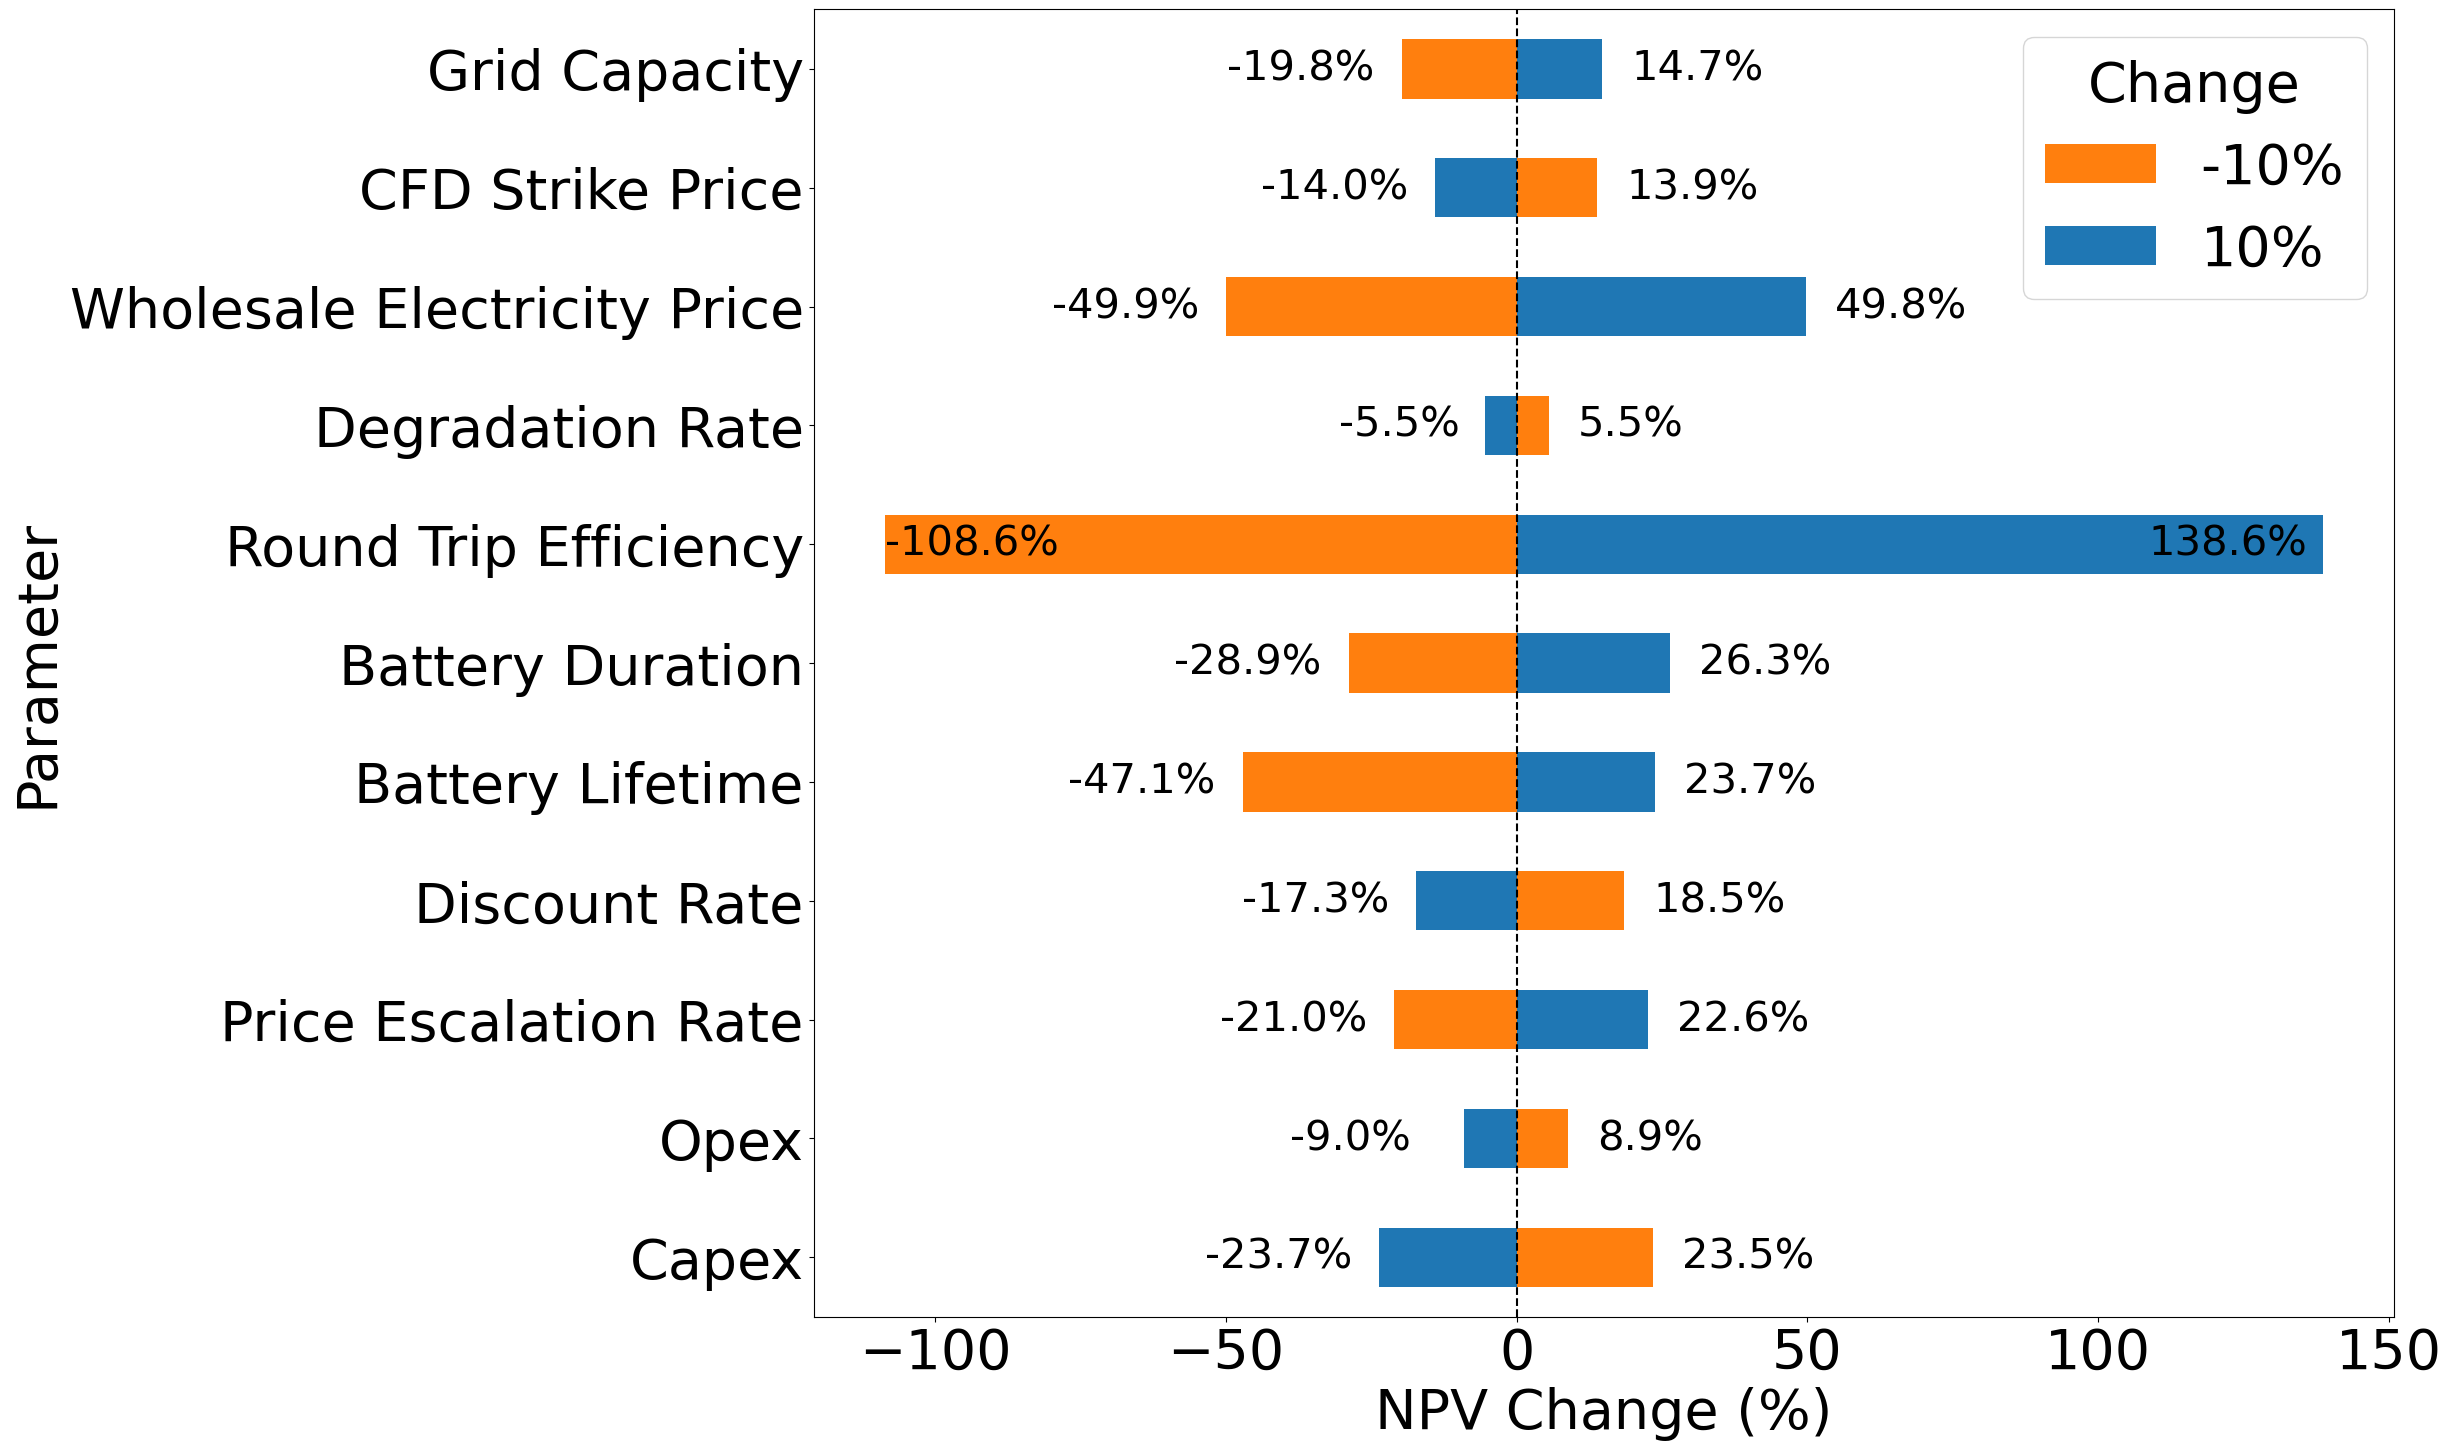

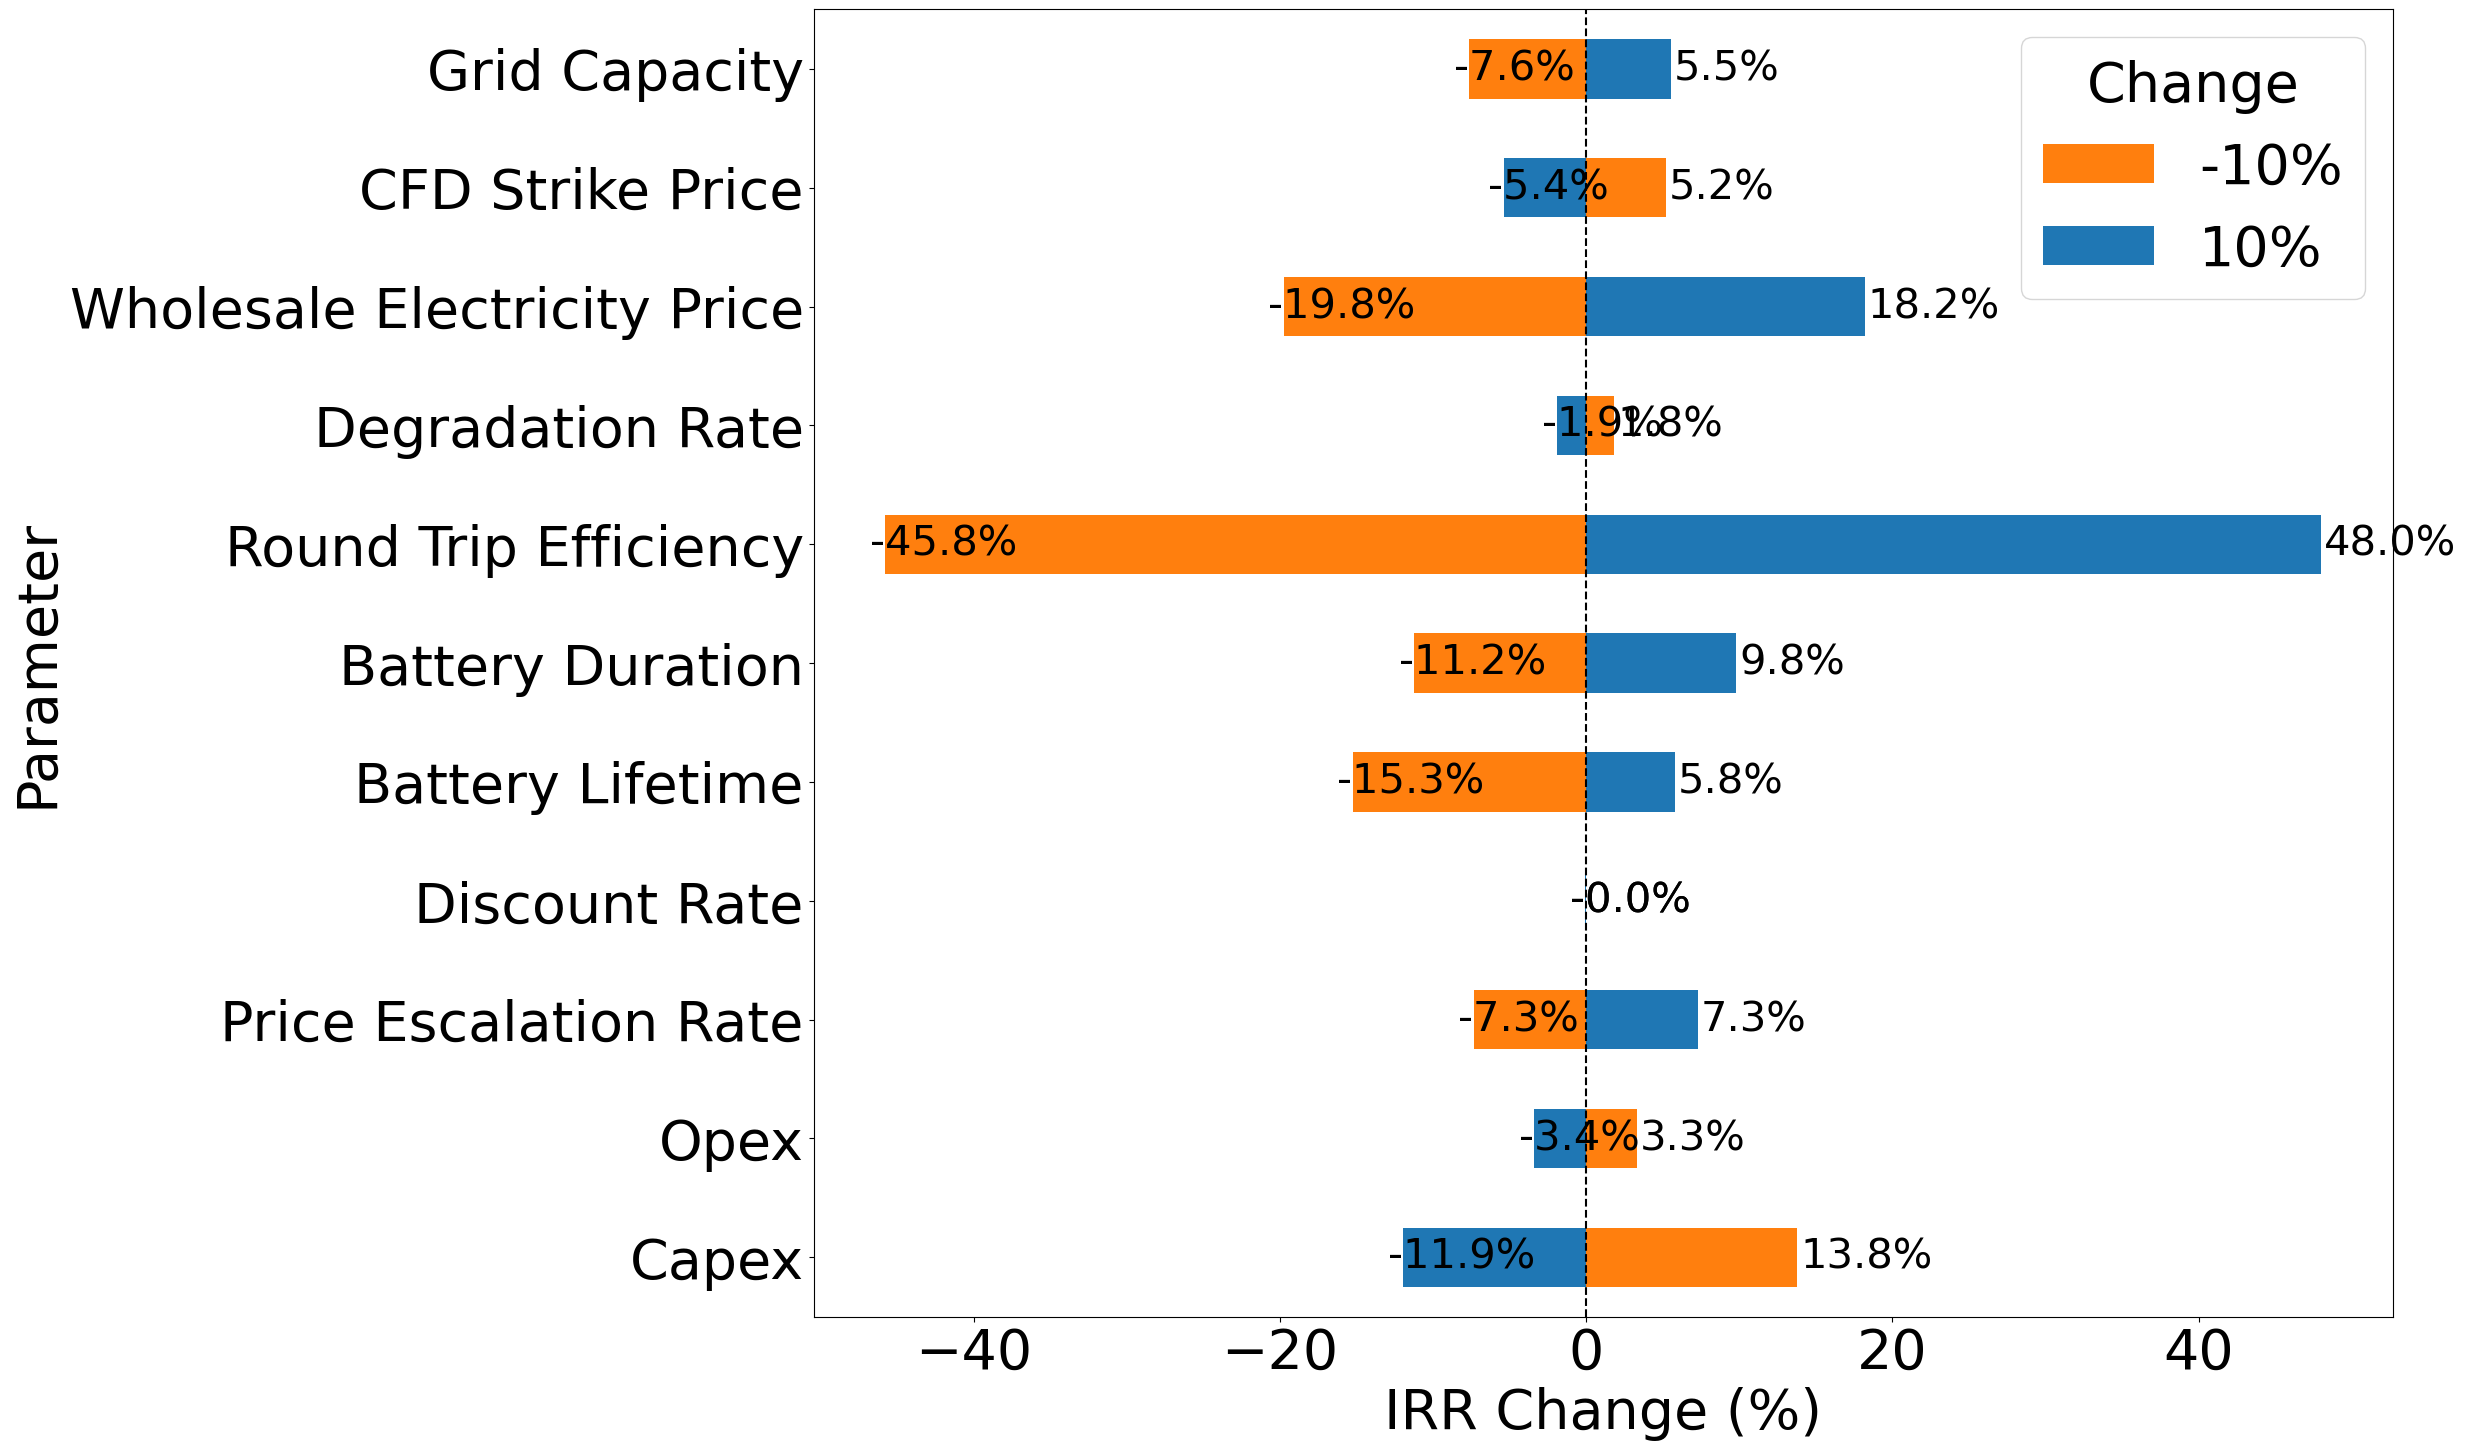

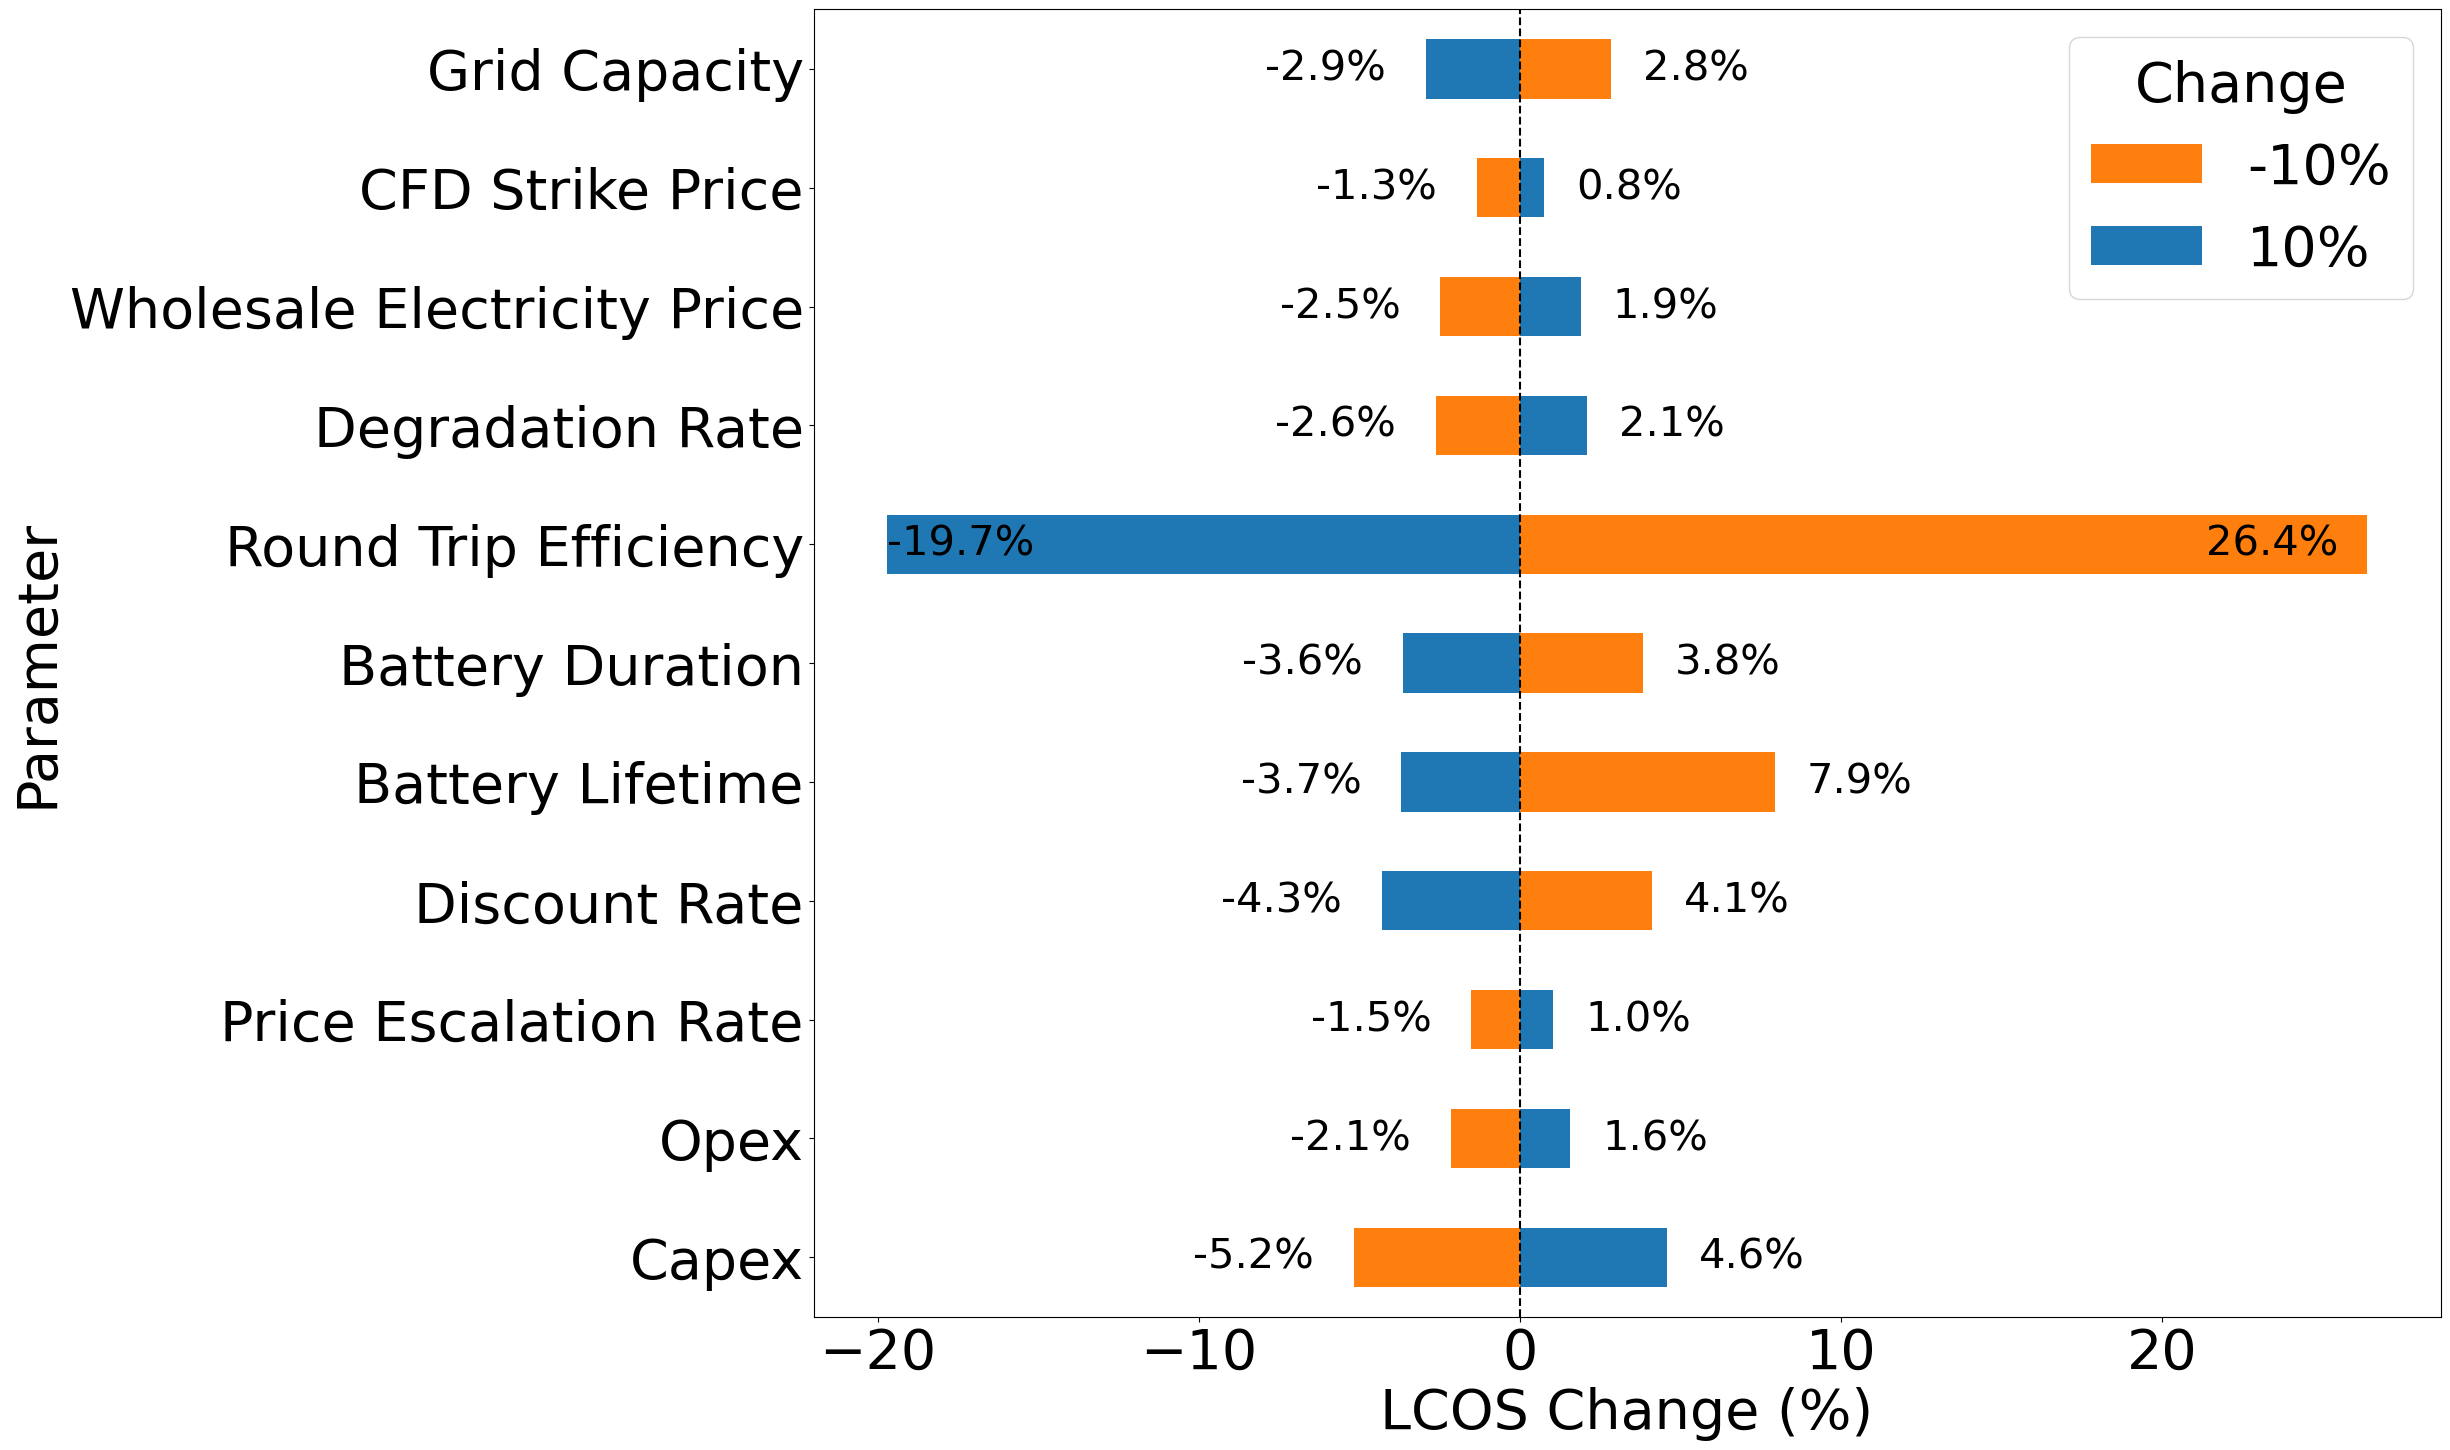

In [25]:
# Assuming results_df has been loaded from your file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Sensitivity_Analysis_Parameter_Impact_tornado.xlsx'
results_df = pd.read_excel(file_path)

# Parameters to consider in the plot
parameters = [
    'Capex',
    'Opex',
    'Price Escalation Rate',
    'Discount Rate',
    'Battery Lifetime',
    'Battery Duration',
    'Round Trip Efficiency',
    'Degradation Rate',
    'Wholesale Electricity Price',
    'CFD Strike Price',
    'Grid Capacity'
]

# Define colors
colors = ['#ff7f0e','#1f77b4']  # Blue and Orange

# Function to add annotations to the bars with specific offsets for each plot
def annotate_bars(ax, df, plot_type):
    for i, param in enumerate(df.index):
        for j, change in enumerate(df.columns):
            value = df.loc[param, change]
            # Customize the offset for each parameter individually per plot type
            if plot_type == 'NPV':
                if param == 'Capex':
                    offset = 5 if value > 0 else -30
                elif param == 'Opex':
                    offset = 5 if value > 0 else -30
                elif param == 'Price Escalation Rate':
                    offset = 5 if value > 0 else -30
                elif param == 'Discount Rate':
                    offset = 5 if value > 0 else -30
                elif param == 'Battery Lifetime':
                    offset = 5 if value > 0 else -30
                elif param == 'Battery Duration':
                    offset = 5 if value > 0 else -30
                elif param == 'Round Trip Efficiency':
                    offset = -30 if value > 0 else 0
                elif param == 'Degradation Rate':
                    offset = 5 if value > 0 else -25
                elif param == 'Wholesale Electricity Price':
                    offset = 5 if value > 0 else -30
                elif param == 'CFD Strike Price':
                    offset = 5 if value > 0 else -30
                elif param == 'Grid Capacity':
                    offset = 5 if value > 0 else -30
            elif plot_type == 'IRR':
                if param == 'Capex':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Opex':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Price Escalation Rate':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Discount Rate':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Battery Lifetime':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Battery Duration':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Round Trip Efficiency':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Degradation Rate':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Wholesale Electricity Price':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'CFD Strike Price':
                    offset = 0.2 if value > 0 else -1.0
                elif param == 'Grid Capacity':
                    offset = 0.2 if value > 0 else -1.0
            elif plot_type == 'LCOS':
                if param == 'Capex':
                    offset = 1 if value > 0 else -5
                elif param == 'Opex':
                    offset = 1 if value > 0 else -5
                elif param == 'Price Escalation Rate':
                    offset = 1 if value > 0 else -5
                elif param == 'Discount Rate':
                    offset = 1 if value > 0 else -5
                elif param == 'Battery Lifetime':
                    offset = 1 if value > 0 else -5
                elif param == 'Battery Duration':
                    offset = 1 if value > 0 else -5
                elif param == 'Round Trip Efficiency':
                    offset = -5 if value > 0 else 0
                elif param == 'Degradation Rate':
                    offset = 1 if value > 0 else -5
                elif param == 'Wholesale Electricity Price':
                    offset = 1 if value > 0 else -5
                elif param == 'CFD Strike Price':
                    offset = 1 if value > 0 else -5
                elif param == 'Grid Capacity':
                    offset = 1 if value > 0 else -5
            
            ax.text(value + offset, i, f'{value:.1f}%', ha='left' if value > 3 else 'left', 
                    va='center', fontsize=30, color='black')

# NPV Change Tornado Plot
fig, ax = plt.subplots(figsize=(25, 15))
npv_changes = results_df.pivot(index='parameter', columns='change', values='NPV Change (%)').loc[parameters]
npv_changes.plot(kind='barh', ax=ax, color=colors, stacked=True)
annotate_bars(ax, npv_changes, plot_type='NPV')  # Add annotations
ax.set_xlabel('NPV Change (%)', fontsize=40)
ax.set_ylabel('Parameter', fontsize=40)
ax.legend(['-10%', '10%'], title='Change', fontsize=40, title_fontsize=40)
ax.axvline(x=0, color='black', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=40)
plt.tight_layout(pad=1.0)
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/NPV_Change_Tornado_Plot.png', transparent=True)
plt.show()

# IRR Change Tornado Plot
fig, ax = plt.subplots(figsize=(25, 15))
irr_changes = results_df.pivot(index='parameter', columns='change', values='IRR Change (%)').loc[parameters]
irr_changes.plot(kind='barh', ax=ax, color=colors, stacked=True)
annotate_bars(ax, irr_changes, plot_type='IRR')  # Add annotations
ax.set_xlabel('IRR Change (%)', fontsize=40)
ax.set_ylabel('Parameter', fontsize=40)
ax.legend(['-10%', '10%'], title='Change', fontsize=40, title_fontsize=40)
ax.axvline(x=0, color='black', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=40)
plt.tight_layout(pad=1.0)
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/IRR_Change_Tornado_Plot.png', transparent=True)
plt.show()

# LCOS Change Tornado Plot
fig, ax = plt.subplots(figsize=(25, 15))
lcos_changes = results_df.pivot(index='parameter', columns='change', values='LCOS Change (%)').loc[parameters]
lcos_changes.plot(kind='barh', ax=ax, color=colors, stacked=True)
annotate_bars(ax, lcos_changes, plot_type='LCOS')  # Add annotations
ax.set_xlabel('LCOS Change (%)', fontsize=40)
ax.set_ylabel('Parameter', fontsize=40)
ax.legend(['-10%', '10%'], title='Change', fontsize=40, title_fontsize=40)
ax.axvline(x=0, color='black', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=40)
plt.tight_layout(pad=1.0)
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/LCOS_Change_Tornado_Plot.png', transparent=True)
plt.show()


In [26]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Base values for parameters
base_capex_per_mw = 1004099
base_opex_per_mw_per_year = 22261
base_discount_rate = 0.07
base_price_escalation_rate = 0.10
base_max_hours = 2
base_cfd_strike_price = 83.22
base_degradation_rate = 0.0155 

# Scenario definitions
scenarios = [
    {'battery_lifetime': 15, 'efficiency_dispatch': 0.92, 'efficiency_store': 0.92},
    {'battery_lifetime': 15, 'efficiency_dispatch': 0.9, 'efficiency_store': 0.9},
    {'battery_lifetime': 15, 'efficiency_dispatch': 0.88, 'efficiency_store': 0.88},
    {'battery_lifetime': 15, 'efficiency_dispatch': 0.86, 'efficiency_store': 0.86},
    {'battery_lifetime': 15, 'efficiency_dispatch': 0.84, 'efficiency_store': 0.84},
    {'battery_lifetime': 20, 'efficiency_dispatch': 0.92, 'efficiency_store': 0.92},
    {'battery_lifetime': 20, 'efficiency_dispatch': 0.9, 'efficiency_store': 0.9},
    {'battery_lifetime': 20, 'efficiency_dispatch': 0.88, 'efficiency_store': 0.88},
    {'battery_lifetime': 20, 'efficiency_dispatch': 0.86, 'efficiency_store': 0.86},
    {'battery_lifetime': 20, 'efficiency_dispatch': 0.84, 'efficiency_store': 0.84},
    {'battery_lifetime': 25, 'efficiency_dispatch': 0.92, 'efficiency_store': 0.92},
    {'battery_lifetime': 25, 'efficiency_dispatch': 0.9, 'efficiency_store': 0.9},
    {'battery_lifetime': 25, 'efficiency_dispatch': 0.88, 'efficiency_store': 0.88},
    {'battery_lifetime': 25, 'efficiency_dispatch': 0.86, 'efficiency_store': 0.86},
    {'battery_lifetime': 25, 'efficiency_dispatch': 0.84, 'efficiency_store': 0.84},
    {'battery_lifetime': 30, 'efficiency_dispatch': 0.92, 'efficiency_store': 0.92},
    {'battery_lifetime': 30, 'efficiency_dispatch': 0.9, 'efficiency_store': 0.9},
    {'battery_lifetime': 30, 'efficiency_dispatch': 0.88, 'efficiency_store': 0.88},
    {'battery_lifetime': 30, 'efficiency_dispatch': 0.86, 'efficiency_store': 0.86},
    {'battery_lifetime': 30, 'efficiency_dispatch': 0.84, 'efficiency_store': 0.84},
    {'battery_lifetime': 35, 'efficiency_dispatch': 0.92, 'efficiency_store': 0.92},
    {'battery_lifetime': 35, 'efficiency_dispatch': 0.9, 'efficiency_store': 0.9},
    {'battery_lifetime': 35, 'efficiency_dispatch': 0.88, 'efficiency_store': 0.88},
    {'battery_lifetime': 35, 'efficiency_dispatch': 0.86, 'efficiency_store': 0.86},
    {'battery_lifetime': 35, 'efficiency_dispatch': 0.84, 'efficiency_store': 0.84}
]

# Add the fixed parameters to each scenario
for scenario in scenarios:
    scenario.update({
        'capex_per_mw': base_capex_per_mw,
        'opex_per_mw_per_year': base_opex_per_mw_per_year,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'degradation_rate': base_degradation_rate,
        'cfd_strike_price': base_cfd_strike_price,
        'market_price_factor': 1.0,
        'dch_prices_factor': 1.0,
        'dcl_prices_factor': 1.0
    })

results = []

for i, scenario in enumerate(scenarios, 1):
    print(f"Running scenario {i}...")

    # Adjust prices based on the scenario factors
    adjusted_market_prices = market_prices
    adjusted_dch_prices = dch_prices
    adjusted_dcl_prices = dcl_prices

    # Calculate round trip efficiency
    round_trip_efficiency = scenario['efficiency_store'] * scenario['efficiency_dispatch']

    # Initialize the network
    network = pypsa.Network()

    # Add time steps to the network
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,  # Generator nominal power (MW)
                p_set=wind_generation_profile.values,  # Set power output directly
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                max_hours=scenario['max_hours'],  # Maximum storage time in hours
                marginal_cost=0.01,  # Storage marginal cost
                capital_cost=scenario['capex_per_mw'],  # CAPEX from scenario
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=scenario['efficiency_store'],
                efficiency_dispatch=scenario['efficiency_dispatch'])

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
                "Backup Generator",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=adjusted_market_prices.values,
                capital_cost=1100000)

    network.add("Link",
                "wind_to_grid",
                bus0="wind_bus",
                bus1="grid_bus",
                efficiency=0.95,
                p_nom=82)

    network.add("Link",
                "grid_to_wind",
                bus0="grid_bus",
                bus1="wind_bus",
                efficiency=0.95,
                p_nom=82)

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows using p_dispatch and p_store
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]
    wind_generation = network.generators_t.p["wind_turbine"]
    backup_generation = network.generators_t.p["Backup Generator"]
    load_demand = network.loads_t.p["grid_demand"]
    soc = network.storage_units_t["state_of_charge"]["battery"]
    soc_percentage = soc / battery_capacity_mwh * 100
    wind_to_grid = network.links_t.p0.loc[:, "wind_to_grid"]
    grid_to_wind = network.links_t.p0.loc[:, "grid_to_wind"]

    # Calculate total energy
    total_battery_dispatch = battery_dispatch.sum()
    total_battery_store = battery_store.sum()
    total_wind_to_grid = wind_to_grid.sum()
    total_grid_to_wind = grid_to_wind.sum()

    # Calculate revenues
    cfd_strike_price = scenario['cfd_strike_price']

    # Calculate CFD Revenue (No Arbitrage Cost, as the wind and battery are on the same bus)
    data = pd.DataFrame({
        'Timestamp': wind_data.index,
        'Market Price (£/MWh)': adjusted_market_prices,
        'DCH Price (£/MWh)': adjusted_dch_prices,
        'DCL Price (£/MWh)': adjusted_dcl_prices,
        'Battery Dispatch (MW)': battery_dispatch,
        'Battery Store (MW)': battery_store,
        'Wind Generation (MW)': wind_generation,
        'Colocated to Grid (MWh)': wind_to_grid,
        'Grid to Colocated (MWh)': grid_to_wind, 
        'Backup Generation (MW)': backup_generation,
        'Load Demand (MW)': load_demand,
        'State of Charge (MWh)': soc,
        'State of Charge (%)': soc_percentage
    })

    data['Arbitrage Cost (£)'] = data['Grid to Colocated (MWh)'] * data['Market Price (£/MWh)']
    data['Wind to Battery Cost (£)'] = (data['Battery Store (MW)'] - data['Grid to Colocated (MWh)']) * cfd_strike_price
    
    data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price
    data['Arbitrage Revenue (£)'] = (data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']) - data['Arbitrage Cost (£)']
    data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
    data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']
 
    # Calculate the total revenue from the battery
    data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)'] - data['Wind to Battery Cost (£)']
    data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['Battery Revenue (£)']
    
    # Calculate financial metrics
    annual_battery_revenue = data['Battery Revenue (£)'].sum()
    discount_rate = scenario['discount_rate']
    battery_lifetime = scenario['battery_lifetime']
    capex_per_mw = scenario['capex_per_mw']
    opex_per_mw_per_year = scenario['opex_per_mw_per_year']
    price_escalation_rate = scenario['price_escalation_rate']

    # Total CAPEX
    total_capex = battery_size_mw * capex_per_mw

    # Calculate annual battery revenues with cumulative degradation and escalation
    annual_battery_revenues = []
    degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        degradation_multiplier *= (1 - scenario['degradation_rate'])  # Apply cumulative degradation
        escalated_revenue = annual_battery_revenue * degradation_multiplier * (1 + price_escalation_rate) ** year
        annual_battery_revenues.append(escalated_revenue)

    annual_opex = [
        (opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year)
        for year in range(battery_lifetime)
    ]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage
    
    # Payback Period Calculation
    cumulative_cash_flow = 0
    payback_period = None
    for year, cash_flow in enumerate(annual_cash_flows):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0 and payback_period is None:
            payback_period = year
    
    # Total Charging Costs
    total_arbitrage_cost = data['Arbitrage Cost (£)'].sum() * battery_lifetime
    total_wind_to_battery_cost = data['Wind to Battery Cost (£)'].sum() * battery_lifetime

    # Discounted total charging costs
    discounted_arbitrage_cost = total_arbitrage_cost / ((1 + discount_rate) ** battery_lifetime)
    discounted_wind_to_battery_cost = total_wind_to_battery_cost / ((1 + discount_rate) ** battery_lifetime)

    # Sum total discounted charging costs
    total_discounted_charging_costs = discounted_arbitrage_cost + discounted_wind_to_battery_cost

    # Total discounted costs including charging costs
    total_discounted_costs_with_charging = total_capex + total_discounted_charging_costs + sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    ## Calculate cumulative degradation multiplier over the battery lifetime
    cumulative_degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        cumulative_degradation_multiplier *= (1 - scenario['degradation_rate'])

    # Total energy dispatched over the lifetime (MWh) using cumulative degradation multiplier
    total_energy_dispatched = total_battery_dispatch * battery_lifetime * cumulative_degradation_multiplier

    # Updated LCOS calculation with charging costs included
    lcos_with_charging = total_discounted_costs_with_charging / total_energy_dispatched

    # Store results
    results.append({
        'Scenario': i,
        'Battery Size (MW)': battery_size_mw,
        'Battery Capacity (MWh)': battery_capacity_mwh,
        'Total Battery Dispatch (MWh)': total_battery_dispatch,
        'Total Battery Store (MWh)': total_battery_store,
        'Round Trip Efficiency': round_trip_efficiency,
        'NPV (£)': npv,
        'IRR (%)': irr,
        'LCOS (£/MWh)': lcos_with_charging,
        'Payback Period (years)': payback_period,
        'Battery Lifetime (years)': battery_lifetime,
        'Discount Rate': discount_rate,
        'Price Escalation Rate': price_escalation_rate,
        'Max Hours': scenario['max_hours'],
        'CAPEX (£/MW)': capex_per_mw,
        'OPEX (£/MW/year)': opex_per_mw_per_year,
        'CFD Strike Price (£/MWh)': cfd_strike_price,
        'Market Price Factor': scenario['market_price_factor'],
        'DCH Prices Factor': scenario['dch_prices_factor'],
        'DCL Prices Factor': scenario['dcl_prices_factor'],
        'Total Battery Revenue (£)': annual_battery_revenue,
        'Total Project Revenue (£)': data['Total Project Revenue (£)'].sum()
    })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Save results to an Excel file
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Results_3D.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Scenario analysis results saved to {output_path}")


Running scenario 1...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.22it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-bj0amizh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-bj0amizh.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.54 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.54 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 2...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.89it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-lwxd0v2q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-lwxd0v2q.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xdfb8ef42


INFO:gurobipy:Model fingerprint: 0xdfb8ef42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


INFO:gurobipy:   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


INFO:gurobipy:   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


INFO:gurobipy:   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


INFO:gurobipy:   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


INFO:gurobipy:   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


INFO:gurobipy:   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


INFO:gurobipy:   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


INFO:gurobipy:   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


INFO:gurobipy:   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


INFO:gurobipy:   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


INFO:gurobipy:  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


INFO:gurobipy:  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


INFO:gurobipy:  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


INFO:gurobipy:  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


INFO:gurobipy:  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


INFO:gurobipy:  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


INFO:gurobipy:  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


INFO:gurobipy:  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


INFO:gurobipy:  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


INFO:gurobipy:  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


INFO:gurobipy:  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


INFO:gurobipy:  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


INFO:gurobipy:  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


INFO:gurobipy:  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:


Barrier solved model in 24 iterations and 0.49 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 0.49 seconds (0.89 work units)


Optimal objective 1.97170994e+11


INFO:gurobipy:Optimal objective 1.97170994e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4069 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4069 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      23 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      23 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4095 iterations and 0.57 seconds (0.97 work units)


INFO:gurobipy:Solved in 4095 iterations and 0.57 seconds (0.97 work units)


Optimal objective  1.971709939e+11


INFO:gurobipy:Optimal objective  1.971709939e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 3...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 146.75it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-tv478s2t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-tv478s2t.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2cf06774


INFO:gurobipy:Model fingerprint: 0x2cf06774


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


INFO:gurobipy:   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


INFO:gurobipy:   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


INFO:gurobipy:   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


INFO:gurobipy:   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


INFO:gurobipy:   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


INFO:gurobipy:   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


INFO:gurobipy:   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


INFO:gurobipy:   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


INFO:gurobipy:   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


INFO:gurobipy:   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


INFO:gurobipy:  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


INFO:gurobipy:  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


INFO:gurobipy:  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


INFO:gurobipy:  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


INFO:gurobipy:  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


INFO:gurobipy:  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


INFO:gurobipy:  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


INFO:gurobipy:  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


INFO:gurobipy:  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


INFO:gurobipy:  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


INFO:gurobipy:  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


INFO:gurobipy:  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


INFO:gurobipy:  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


INFO:gurobipy:  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


INFO:gurobipy:  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.48 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.48 seconds (0.91 work units)


Optimal objective 1.97171535e+11


INFO:gurobipy:Optimal objective 1.97171535e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4277 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4277 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4289 iterations and 0.54 seconds (0.98 work units)


INFO:gurobipy:Solved in 4289 iterations and 0.54 seconds (0.98 work units)


Optimal objective  1.971715354e+11


INFO:gurobipy:Optimal objective  1.971715354e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 4...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 146.98it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-3pds5f01.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-3pds5f01.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2be430f6


INFO:gurobipy:Model fingerprint: 0x2be430f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


INFO:gurobipy:   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


INFO:gurobipy:   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


INFO:gurobipy:   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


INFO:gurobipy:   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


INFO:gurobipy:   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


INFO:gurobipy:   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


INFO:gurobipy:   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


INFO:gurobipy:   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


INFO:gurobipy:   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


INFO:gurobipy:   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


INFO:gurobipy:  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


INFO:gurobipy:  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


INFO:gurobipy:  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


INFO:gurobipy:  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


INFO:gurobipy:  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


INFO:gurobipy:  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


INFO:gurobipy:  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


INFO:gurobipy:  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


INFO:gurobipy:  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


INFO:gurobipy:  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


INFO:gurobipy:  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


INFO:gurobipy:  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


INFO:gurobipy:  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


Optimal objective 1.97172023e+11


INFO:gurobipy:Optimal objective 1.97172023e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4441 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4441 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4453 iterations and 0.54 seconds (0.95 work units)


INFO:gurobipy:Solved in 4453 iterations and 0.54 seconds (0.95 work units)


Optimal objective  1.971720226e+11


INFO:gurobipy:Optimal objective  1.971720226e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 5...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.48it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-9k5d3nt1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-9k5d3nt1.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x8b46283a


INFO:gurobipy:Model fingerprint: 0x8b46283a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


INFO:gurobipy:   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


INFO:gurobipy:   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


INFO:gurobipy:   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


INFO:gurobipy:   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


INFO:gurobipy:   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


INFO:gurobipy:   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


INFO:gurobipy:   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


INFO:gurobipy:   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


INFO:gurobipy:   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


INFO:gurobipy:   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


INFO:gurobipy:  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


INFO:gurobipy:  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


INFO:gurobipy:  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


INFO:gurobipy:  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


INFO:gurobipy:  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


INFO:gurobipy:  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


INFO:gurobipy:  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


INFO:gurobipy:  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


INFO:gurobipy:  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


INFO:gurobipy:  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


INFO:gurobipy:  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


INFO:gurobipy:  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


INFO:gurobipy:  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


Optimal objective 1.97172459e+11


INFO:gurobipy:Optimal objective 1.97172459e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4633 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4633 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4646 iterations and 0.55 seconds (0.95 work units)


INFO:gurobipy:Solved in 4646 iterations and 0.55 seconds (0.95 work units)


Optimal objective  1.971724590e+11


INFO:gurobipy:Optimal objective  1.971724590e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 6...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 139.37it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-2xp_tkap.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-2xp_tkap.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.53 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.53 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 7...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 138.64it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-2doh72hm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-2doh72hm.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xdfb8ef42


INFO:gurobipy:Model fingerprint: 0xdfb8ef42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


INFO:gurobipy:   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


INFO:gurobipy:   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


INFO:gurobipy:   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


INFO:gurobipy:   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


INFO:gurobipy:   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


INFO:gurobipy:   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


INFO:gurobipy:   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


INFO:gurobipy:   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


INFO:gurobipy:   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


INFO:gurobipy:   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


INFO:gurobipy:  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


INFO:gurobipy:  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


INFO:gurobipy:  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


INFO:gurobipy:  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


INFO:gurobipy:  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


INFO:gurobipy:  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


INFO:gurobipy:  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


INFO:gurobipy:  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     1s


INFO:gurobipy:  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     1s


  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     1s


INFO:gurobipy:  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     1s


  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     1s


INFO:gurobipy:  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     1s


  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     1s


INFO:gurobipy:  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     1s


  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     1s


INFO:gurobipy:  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     1s


  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     1s


INFO:gurobipy:  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     1s


  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     1s


INFO:gurobipy:  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     1s


INFO:gurobipy:


Barrier solved model in 24 iterations and 0.67 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 0.67 seconds (0.89 work units)


Optimal objective 1.97170994e+11


INFO:gurobipy:Optimal objective 1.97170994e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4069 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4069 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      23 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      23 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4095 iterations and 0.80 seconds (0.97 work units)


INFO:gurobipy:Solved in 4095 iterations and 0.80 seconds (0.97 work units)


Optimal objective  1.971709939e+11


INFO:gurobipy:Optimal objective  1.971709939e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 8...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 133.89it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ecnpsnt5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ecnpsnt5.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2cf06774


INFO:gurobipy:Model fingerprint: 0x2cf06774


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


INFO:gurobipy:   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


INFO:gurobipy:   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


INFO:gurobipy:   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


INFO:gurobipy:   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


INFO:gurobipy:   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


INFO:gurobipy:   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


INFO:gurobipy:   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


INFO:gurobipy:   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


INFO:gurobipy:   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


INFO:gurobipy:   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


INFO:gurobipy:  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


INFO:gurobipy:  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


INFO:gurobipy:  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


INFO:gurobipy:  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


INFO:gurobipy:  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


INFO:gurobipy:  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


INFO:gurobipy:  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


INFO:gurobipy:  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


INFO:gurobipy:  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


INFO:gurobipy:  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


INFO:gurobipy:  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


INFO:gurobipy:  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


INFO:gurobipy:  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


INFO:gurobipy:  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


INFO:gurobipy:  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.49 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.49 seconds (0.91 work units)


Optimal objective 1.97171535e+11


INFO:gurobipy:Optimal objective 1.97171535e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4277 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4277 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4289 iterations and 0.56 seconds (0.98 work units)


INFO:gurobipy:Solved in 4289 iterations and 0.56 seconds (0.98 work units)


Optimal objective  1.971715354e+11


INFO:gurobipy:Optimal objective  1.971715354e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 9...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 137.50it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-wxl7uzuw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-wxl7uzuw.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2be430f6


INFO:gurobipy:Model fingerprint: 0x2be430f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


INFO:gurobipy:   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


INFO:gurobipy:   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


INFO:gurobipy:   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


INFO:gurobipy:   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


INFO:gurobipy:   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


INFO:gurobipy:   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


INFO:gurobipy:   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


INFO:gurobipy:   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


INFO:gurobipy:   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


INFO:gurobipy:   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


INFO:gurobipy:  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


INFO:gurobipy:  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


INFO:gurobipy:  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


INFO:gurobipy:  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


INFO:gurobipy:  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


INFO:gurobipy:  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


INFO:gurobipy:  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


INFO:gurobipy:  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


INFO:gurobipy:  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


INFO:gurobipy:  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


INFO:gurobipy:  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


INFO:gurobipy:  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


INFO:gurobipy:  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


Optimal objective 1.97172023e+11


INFO:gurobipy:Optimal objective 1.97172023e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4441 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4441 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4453 iterations and 0.55 seconds (0.95 work units)


INFO:gurobipy:Solved in 4453 iterations and 0.55 seconds (0.95 work units)


Optimal objective  1.971720226e+11


INFO:gurobipy:Optimal objective  1.971720226e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 10...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 133.47it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-y86cmwf2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-y86cmwf2.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x8b46283a


INFO:gurobipy:Model fingerprint: 0x8b46283a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


INFO:gurobipy:   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


INFO:gurobipy:   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


INFO:gurobipy:   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


INFO:gurobipy:   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


INFO:gurobipy:   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


INFO:gurobipy:   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


INFO:gurobipy:   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


INFO:gurobipy:   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


INFO:gurobipy:   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


INFO:gurobipy:   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


INFO:gurobipy:  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


INFO:gurobipy:  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


INFO:gurobipy:  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


INFO:gurobipy:  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


INFO:gurobipy:  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


INFO:gurobipy:  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


INFO:gurobipy:  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


INFO:gurobipy:  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


INFO:gurobipy:  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


INFO:gurobipy:  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


INFO:gurobipy:  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


INFO:gurobipy:  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


INFO:gurobipy:  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


Optimal objective 1.97172459e+11


INFO:gurobipy:Optimal objective 1.97172459e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4633 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4633 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4646 iterations and 0.55 seconds (0.95 work units)


INFO:gurobipy:Solved in 4646 iterations and 0.55 seconds (0.95 work units)


Optimal objective  1.971724590e+11


INFO:gurobipy:Optimal objective  1.971724590e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 11...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 140.84it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yku11771.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yku11771.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.55 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.55 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 12...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 135.26it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yzt7qyl6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-yzt7qyl6.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xdfb8ef42


INFO:gurobipy:Model fingerprint: 0xdfb8ef42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


INFO:gurobipy:   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


INFO:gurobipy:   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


INFO:gurobipy:   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


INFO:gurobipy:   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


INFO:gurobipy:   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


INFO:gurobipy:   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


INFO:gurobipy:   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


INFO:gurobipy:   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


INFO:gurobipy:   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


INFO:gurobipy:   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


INFO:gurobipy:  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


INFO:gurobipy:  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


INFO:gurobipy:  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


INFO:gurobipy:  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


INFO:gurobipy:  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


INFO:gurobipy:  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


INFO:gurobipy:  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


INFO:gurobipy:  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


INFO:gurobipy:  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


INFO:gurobipy:  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     1s


INFO:gurobipy:  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     1s


  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     1s


INFO:gurobipy:  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     1s


  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     1s


INFO:gurobipy:  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     1s


  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     1s


INFO:gurobipy:  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     1s


  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     1s


INFO:gurobipy:  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     1s


INFO:gurobipy:


Barrier solved model in 24 iterations and 0.59 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 0.59 seconds (0.89 work units)


Optimal objective 1.97170994e+11


INFO:gurobipy:Optimal objective 1.97170994e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4069 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4069 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      23 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      23 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4095 iterations and 0.66 seconds (0.97 work units)


INFO:gurobipy:Solved in 4095 iterations and 0.66 seconds (0.97 work units)


Optimal objective  1.971709939e+11


INFO:gurobipy:Optimal objective  1.971709939e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 13...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.35it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-sn_9u0w0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-sn_9u0w0.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2cf06774


INFO:gurobipy:Model fingerprint: 0x2cf06774


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


INFO:gurobipy:   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


INFO:gurobipy:   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


INFO:gurobipy:   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


INFO:gurobipy:   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


INFO:gurobipy:   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


INFO:gurobipy:   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


INFO:gurobipy:   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


INFO:gurobipy:   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


INFO:gurobipy:   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


INFO:gurobipy:   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


INFO:gurobipy:  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


INFO:gurobipy:  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


INFO:gurobipy:  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


INFO:gurobipy:  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


INFO:gurobipy:  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


INFO:gurobipy:  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


INFO:gurobipy:  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


INFO:gurobipy:  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


INFO:gurobipy:  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


INFO:gurobipy:  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


INFO:gurobipy:  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


INFO:gurobipy:  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


INFO:gurobipy:  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


INFO:gurobipy:  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     1s


INFO:gurobipy:  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     1s


  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     1s


INFO:gurobipy:  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     1s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.52 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.52 seconds (0.91 work units)


Optimal objective 1.97171535e+11


INFO:gurobipy:Optimal objective 1.97171535e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4277 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4277 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4289 iterations and 0.59 seconds (0.98 work units)


INFO:gurobipy:Solved in 4289 iterations and 0.59 seconds (0.98 work units)


Optimal objective  1.971715354e+11


INFO:gurobipy:Optimal objective  1.971715354e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 14...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 143.38it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-d20n46z9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-d20n46z9.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2be430f6


INFO:gurobipy:Model fingerprint: 0x2be430f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


INFO:gurobipy:   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


INFO:gurobipy:   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


INFO:gurobipy:   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


INFO:gurobipy:   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


INFO:gurobipy:   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


INFO:gurobipy:   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


INFO:gurobipy:   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


INFO:gurobipy:   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


INFO:gurobipy:   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


INFO:gurobipy:   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


INFO:gurobipy:  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


INFO:gurobipy:  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


INFO:gurobipy:  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


INFO:gurobipy:  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


INFO:gurobipy:  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


INFO:gurobipy:  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


INFO:gurobipy:  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


INFO:gurobipy:  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


INFO:gurobipy:  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


INFO:gurobipy:  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


INFO:gurobipy:  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


INFO:gurobipy:  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


INFO:gurobipy:  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     1s


INFO:gurobipy:  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     1s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.50 seconds (0.87 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.50 seconds (0.87 work units)


Optimal objective 1.97172023e+11


INFO:gurobipy:Optimal objective 1.97172023e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4441 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4441 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4453 iterations and 0.57 seconds (0.95 work units)


INFO:gurobipy:Solved in 4453 iterations and 0.57 seconds (0.95 work units)


Optimal objective  1.971720226e+11


INFO:gurobipy:Optimal objective  1.971720226e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 15...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.21it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xsko9u1h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-xsko9u1h.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x8b46283a


INFO:gurobipy:Model fingerprint: 0x8b46283a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


INFO:gurobipy:   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


INFO:gurobipy:   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


INFO:gurobipy:   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


INFO:gurobipy:   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


INFO:gurobipy:   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


INFO:gurobipy:   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


INFO:gurobipy:   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


INFO:gurobipy:   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


INFO:gurobipy:   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


INFO:gurobipy:   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


INFO:gurobipy:  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


INFO:gurobipy:  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


INFO:gurobipy:  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


INFO:gurobipy:  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


INFO:gurobipy:  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


INFO:gurobipy:  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


INFO:gurobipy:  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


INFO:gurobipy:  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


INFO:gurobipy:  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


INFO:gurobipy:  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


INFO:gurobipy:  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


INFO:gurobipy:  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


INFO:gurobipy:  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.47 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.47 seconds (0.88 work units)


Optimal objective 1.97172459e+11


INFO:gurobipy:Optimal objective 1.97172459e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4633 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4633 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4646 iterations and 0.53 seconds (0.95 work units)


INFO:gurobipy:Solved in 4646 iterations and 0.53 seconds (0.95 work units)


Optimal objective  1.971724590e+11


INFO:gurobipy:Optimal objective  1.971724590e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 16...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.63it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-uvxijygj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-uvxijygj.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.53 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.53 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 17...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.13it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-4p2z3m4y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-4p2z3m4y.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xdfb8ef42


INFO:gurobipy:Model fingerprint: 0xdfb8ef42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


INFO:gurobipy:   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


INFO:gurobipy:   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


INFO:gurobipy:   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


INFO:gurobipy:   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


INFO:gurobipy:   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


INFO:gurobipy:   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


INFO:gurobipy:   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


INFO:gurobipy:   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


INFO:gurobipy:   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


INFO:gurobipy:   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


INFO:gurobipy:  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


INFO:gurobipy:  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


INFO:gurobipy:  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


INFO:gurobipy:  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


INFO:gurobipy:  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


INFO:gurobipy:  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


INFO:gurobipy:  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


INFO:gurobipy:  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


INFO:gurobipy:  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


INFO:gurobipy:  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


INFO:gurobipy:  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


INFO:gurobipy:  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


INFO:gurobipy:  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


INFO:gurobipy:  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:


Barrier solved model in 24 iterations and 0.49 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 0.49 seconds (0.89 work units)


Optimal objective 1.97170994e+11


INFO:gurobipy:Optimal objective 1.97170994e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4069 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4069 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      23 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      23 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4095 iterations and 0.57 seconds (0.97 work units)


INFO:gurobipy:Solved in 4095 iterations and 0.57 seconds (0.97 work units)


Optimal objective  1.971709939e+11


INFO:gurobipy:Optimal objective  1.971709939e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 18...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 146.29it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-cr0jxllh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-cr0jxllh.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2cf06774


INFO:gurobipy:Model fingerprint: 0x2cf06774


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


INFO:gurobipy:   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


INFO:gurobipy:   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


INFO:gurobipy:   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


INFO:gurobipy:   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


INFO:gurobipy:   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


INFO:gurobipy:   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


INFO:gurobipy:   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


INFO:gurobipy:   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


INFO:gurobipy:   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


INFO:gurobipy:   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


INFO:gurobipy:  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


INFO:gurobipy:  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


INFO:gurobipy:  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


INFO:gurobipy:  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


INFO:gurobipy:  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


INFO:gurobipy:  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


INFO:gurobipy:  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


INFO:gurobipy:  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


INFO:gurobipy:  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


INFO:gurobipy:  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


INFO:gurobipy:  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


INFO:gurobipy:  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


INFO:gurobipy:  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


INFO:gurobipy:  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


INFO:gurobipy:  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.49 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.49 seconds (0.91 work units)


Optimal objective 1.97171535e+11


INFO:gurobipy:Optimal objective 1.97171535e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4277 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4277 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4289 iterations and 0.55 seconds (0.98 work units)


INFO:gurobipy:Solved in 4289 iterations and 0.55 seconds (0.98 work units)


Optimal objective  1.971715354e+11


INFO:gurobipy:Optimal objective  1.971715354e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 19...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.12it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gplhjx1s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gplhjx1s.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2be430f6


INFO:gurobipy:Model fingerprint: 0x2be430f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


INFO:gurobipy:   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


INFO:gurobipy:   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


INFO:gurobipy:   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


INFO:gurobipy:   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


INFO:gurobipy:   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


INFO:gurobipy:   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


INFO:gurobipy:   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


INFO:gurobipy:   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


INFO:gurobipy:   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


INFO:gurobipy:   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


INFO:gurobipy:  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


INFO:gurobipy:  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


INFO:gurobipy:  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


INFO:gurobipy:  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


INFO:gurobipy:  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


INFO:gurobipy:  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


INFO:gurobipy:  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


INFO:gurobipy:  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


INFO:gurobipy:  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


INFO:gurobipy:  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


INFO:gurobipy:  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


INFO:gurobipy:  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


INFO:gurobipy:  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.47 seconds (0.87 work units)


Optimal objective 1.97172023e+11


INFO:gurobipy:Optimal objective 1.97172023e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4441 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4441 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4453 iterations and 0.53 seconds (0.95 work units)


INFO:gurobipy:Solved in 4453 iterations and 0.53 seconds (0.95 work units)


Optimal objective  1.971720226e+11


INFO:gurobipy:Optimal objective  1.971720226e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 20...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 136.51it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-th6xnjwv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-th6xnjwv.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x8b46283a


INFO:gurobipy:Model fingerprint: 0x8b46283a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


INFO:gurobipy:   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


INFO:gurobipy:   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


INFO:gurobipy:   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


INFO:gurobipy:   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


INFO:gurobipy:   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


INFO:gurobipy:   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


INFO:gurobipy:   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


INFO:gurobipy:   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


INFO:gurobipy:   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


INFO:gurobipy:   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


INFO:gurobipy:  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


INFO:gurobipy:  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


INFO:gurobipy:  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


INFO:gurobipy:  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


INFO:gurobipy:  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


INFO:gurobipy:  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


INFO:gurobipy:  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


INFO:gurobipy:  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


INFO:gurobipy:  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


INFO:gurobipy:  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


INFO:gurobipy:  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


INFO:gurobipy:  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


INFO:gurobipy:  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.48 seconds (0.88 work units)


Optimal objective 1.97172459e+11


INFO:gurobipy:Optimal objective 1.97172459e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4633 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4633 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4646 iterations and 0.55 seconds (0.95 work units)


INFO:gurobipy:Solved in 4646 iterations and 0.55 seconds (0.95 work units)


Optimal objective  1.971724590e+11


INFO:gurobipy:Optimal objective  1.971724590e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 21...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.89it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-e0a21m9j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-e0a21m9j.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.47 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.54 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.54 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 22...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 147.09it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-e4rcb6t0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-e4rcb6t0.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xdfb8ef42


INFO:gurobipy:Model fingerprint: 0xdfb8ef42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


INFO:gurobipy:   0   1.97414840e+11 -1.25889670e+12  1.08e+02 1.85e+05  9.37e+07     0s


   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


INFO:gurobipy:   1   1.97356478e+11 -5.75790498e+11  1.43e+01 9.72e+04  1.82e+07     0s


   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


INFO:gurobipy:   2   1.97306825e+11  1.09536229e+11  1.66e+00 5.50e+03  1.43e+06     0s


   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


INFO:gurobipy:   3   1.97302803e+11  1.96613929e+11  6.11e-12 1.92e+01  9.33e+03     0s


   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


INFO:gurobipy:   4   1.97190914e+11  1.97056961e+11  1.50e-12 8.94e-01  1.57e+03     0s


   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


INFO:gurobipy:   5   1.97267342e+11  1.97090898e+11  3.97e-10 4.17e-01  2.05e+03     0s


   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


INFO:gurobipy:   6   1.97195231e+11  1.97101880e+11  1.01e-10 2.24e-01  1.08e+03     0s


   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


INFO:gurobipy:   7   1.97183210e+11  1.97144909e+11  7.55e-10 5.40e-13  4.43e+02     0s


   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


INFO:gurobipy:   8   1.97178289e+11  1.97160829e+11  7.41e-10 5.82e-11  2.02e+02     0s


   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


INFO:gurobipy:   9   1.97174928e+11  1.97166155e+11  3.35e-11 1.48e-02  1.01e+02     0s


  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


INFO:gurobipy:  10   1.97173382e+11  1.97168454e+11  3.20e-10 1.14e-13  5.69e+01     0s


  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


INFO:gurobipy:  11   1.97172480e+11  1.97169471e+11  1.74e-10 1.14e-13  3.47e+01     0s


  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


INFO:gurobipy:  12   1.97171994e+11  1.97170382e+11  4.06e-10 5.82e-11  1.85e+01     0s


  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


INFO:gurobipy:  13   1.97171277e+11  1.97170766e+11  4.71e-10 1.14e-13  5.88e+00     0s


  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


INFO:gurobipy:  14   1.97171156e+11  1.97170897e+11  2.45e-10 2.27e-13  2.98e+00     0s


  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


INFO:gurobipy:  15   1.97171086e+11  1.97170937e+11  4.46e-10 1.14e-13  1.72e+00     0s


  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


INFO:gurobipy:  16   1.97171041e+11  1.97170962e+11  6.84e-11 5.82e-11  9.13e-01     0s


  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


INFO:gurobipy:  17   1.97171012e+11  1.97170982e+11  2.14e-10 2.33e-10  3.48e-01     0s


  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


INFO:gurobipy:  18   1.97170997e+11  1.97170990e+11  1.49e-04 2.27e-13  7.68e-02     0s


  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


INFO:gurobipy:  19   1.97170995e+11  1.97170994e+11  9.48e-05 5.82e-11  1.62e-02     0s


  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


INFO:gurobipy:  20   1.97170994e+11  1.97170994e+11  3.34e-05 5.82e-11  5.13e-03     0s


  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


INFO:gurobipy:  21   1.97170994e+11  1.97170994e+11  1.01e-05 2.27e-13  1.46e-03     0s


  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


INFO:gurobipy:  22   1.97170994e+11  1.97170994e+11  1.04e-06 2.27e-13  1.26e-04     0s


  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


INFO:gurobipy:  23   1.97170994e+11  1.97170994e+11  9.83e-08 7.40e-08  3.22e-06     0s


  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:  24   1.97170994e+11  1.97170994e+11  3.26e-09 2.09e-07  4.86e-09     0s


INFO:gurobipy:


Barrier solved model in 24 iterations and 0.47 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 24 iterations and 0.47 seconds (0.89 work units)


Optimal objective 1.97170994e+11


INFO:gurobipy:Optimal objective 1.97170994e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4069 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4069 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


      23 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:      23 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0306379e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4095    1.9717099e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4095 iterations and 0.53 seconds (0.97 work units)


INFO:gurobipy:Solved in 4095 iterations and 0.53 seconds (0.97 work units)


Optimal objective  1.971709939e+11


INFO:gurobipy:Optimal objective  1.971709939e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 23...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 146.22it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-q9fhll6h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-q9fhll6h.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2cf06774


INFO:gurobipy:Model fingerprint: 0x2cf06774


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


INFO:gurobipy:   0   1.97356247e+11 -1.24894540e+12  7.96e+01 1.83e+05  7.32e+07     0s


   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


INFO:gurobipy:   1   1.97311835e+11 -5.30210379e+11  4.99e+00 1.06e+05  1.48e+07     0s


   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


INFO:gurobipy:   2   1.97256380e+11  1.69313603e+11  4.44e-01 2.07e+03  4.36e+05     0s


   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


INFO:gurobipy:   3   1.97250161e+11  1.96889953e+11  7.80e-12 1.18e+01  4.76e+03     0s


   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


INFO:gurobipy:   4   1.97193049e+11  1.97062425e+11  3.63e-12 5.49e-01  1.56e+03     0s


   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


INFO:gurobipy:   5   1.97267483e+11  1.97109648e+11  6.73e-10 7.78e-01  1.87e+03     0s


   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


INFO:gurobipy:   6   1.97192407e+11  1.97139545e+11  3.89e-10 1.34e-01  6.17e+02     0s


   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


INFO:gurobipy:   7   1.97180852e+11  1.97162019e+11  2.14e-11 2.33e-10  2.19e+02     0s


   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


INFO:gurobipy:   8   1.97176340e+11  1.97167406e+11  1.98e-10 1.14e-13  1.03e+02     0s


   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


INFO:gurobipy:   9   1.97174596e+11  1.97168532e+11  2.56e-10 2.26e-02  7.03e+01     0s


  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


INFO:gurobipy:  10   1.97173331e+11  1.97169913e+11  2.54e-10 3.46e-03  3.96e+01     0s


  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


INFO:gurobipy:  11   1.97172588e+11  1.97170902e+11  2.08e-10 1.75e-03  1.95e+01     0s


  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


INFO:gurobipy:  12   1.97172061e+11  1.97171310e+11  1.03e-10 2.27e-13  8.66e+00     0s


  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


INFO:gurobipy:  13   1.97171857e+11  1.97171413e+11  3.00e-10 1.14e-13  5.11e+00     0s


  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


INFO:gurobipy:  14   1.97171709e+11  1.97171458e+11  1.73e-10 1.14e-13  2.89e+00     0s


  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


INFO:gurobipy:  15   1.97171626e+11  1.97171492e+11  1.98e-10 2.27e-13  1.55e+00     0s


  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


INFO:gurobipy:  16   1.97171569e+11  1.97171518e+11  9.03e-10 2.33e-10  5.91e-01     0s


  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


INFO:gurobipy:  17   1.97171545e+11  1.97171529e+11  3.52e-10 2.27e-13  1.98e-01     0s


  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


INFO:gurobipy:  18   1.97171540e+11  1.97171533e+11  8.04e-10 2.27e-13  7.90e-02     0s


  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


INFO:gurobipy:  19   1.97171537e+11  1.97171534e+11  7.62e-10 5.82e-11  3.43e-02     0s


  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


INFO:gurobipy:  20   1.97171536e+11  1.97171535e+11  7.28e-10 2.27e-13  1.34e-02     0s


  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


INFO:gurobipy:  21   1.97171535e+11  1.97171535e+11  3.62e-06 2.27e-13  2.92e-03     0s


  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


INFO:gurobipy:  22   1.97171535e+11  1.97171535e+11  3.26e-06 2.33e-10  3.72e-04     0s


  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


INFO:gurobipy:  23   1.97171535e+11  1.97171535e+11  4.33e-07 1.48e-07  1.40e-05     0s


  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


INFO:gurobipy:  24   1.97171535e+11  1.97171535e+11  7.36e-09 2.47e-07  1.17e-08     0s


  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:  25   1.97171535e+11  1.97171535e+11  1.87e-10 1.01e-07  1.62e-13     0s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.50 seconds (0.91 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.50 seconds (0.91 work units)


Optimal objective 1.97171535e+11


INFO:gurobipy:Optimal objective 1.97171535e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4277 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4277 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7296053e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4289    1.9717154e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4289 iterations and 0.56 seconds (0.98 work units)


INFO:gurobipy:Solved in 4289 iterations and 0.56 seconds (0.98 work units)


Optimal objective  1.971715354e+11


INFO:gurobipy:Optimal objective  1.971715354e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 24...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 140.71it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-1d7tkk0d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-1d7tkk0d.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x2be430f6


INFO:gurobipy:Model fingerprint: 0x2be430f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


INFO:gurobipy:   0   1.97245692e+11 -8.20886334e+11  8.90e+01 2.03e+05  7.30e+07     0s


   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


INFO:gurobipy:   1   1.97312503e+11 -4.04539099e+11  6.94e-02 1.26e+05  1.37e+07     0s


   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


INFO:gurobipy:   2   1.97261699e+11  1.84081509e+11  5.63e-03 9.67e+02  2.05e+05     0s


   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


INFO:gurobipy:   3   1.97249638e+11  1.96923771e+11  5.95e-12 1.14e+01  4.33e+03     0s


   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


INFO:gurobipy:   4   1.97194856e+11  1.97076525e+11  2.57e-12 6.43e-01  1.40e+03     0s


   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


INFO:gurobipy:   5   1.97218845e+11  1.97102865e+11  1.11e-10 6.37e-01  1.38e+03     0s


   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


INFO:gurobipy:   6   1.97187217e+11  1.97154593e+11  3.70e-11 1.16e-10  3.80e+02     0s


   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


INFO:gurobipy:   7   1.97176257e+11  1.97166004e+11  5.77e-11 2.33e-10  1.19e+02     0s


   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


INFO:gurobipy:   8   1.97174247e+11  1.97169824e+11  2.75e-11 2.27e-13  5.13e+01     0s


   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


INFO:gurobipy:   9   1.97173285e+11  1.97170825e+11  4.75e-11 2.27e-13  2.85e+01     0s


  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


INFO:gurobipy:  10   1.97172732e+11  1.97171236e+11  6.45e-11 2.27e-13  1.74e+01     0s


  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


INFO:gurobipy:  11   1.97172359e+11  1.97171616e+11  4.88e-11 6.92e-04  8.61e+00     0s


  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


INFO:gurobipy:  12   1.97172165e+11  1.97171899e+11  7.00e-11 2.27e-13  3.08e+00     0s


  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


INFO:gurobipy:  13   1.97172090e+11  1.97171957e+11  3.28e-11 2.27e-13  1.54e+00     0s


  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


INFO:gurobipy:  14   1.97172058e+11  1.97171984e+11  6.07e-11 2.27e-13  8.52e-01     0s


  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


INFO:gurobipy:  15   1.97172040e+11  1.97172000e+11  9.34e-11 1.14e-13  4.62e-01     0s


  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


INFO:gurobipy:  16   1.97172028e+11  1.97172014e+11  1.54e-10 1.14e-13  1.66e-01     0s


  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


INFO:gurobipy:  17   1.97172023e+11  1.97172021e+11  1.49e-05 2.27e-13  3.18e-02     0s


  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


INFO:gurobipy:  18   1.97172023e+11  1.97172022e+11  2.22e-05 2.27e-13  8.35e-03     0s


  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


INFO:gurobipy:  19   1.97172023e+11  1.97172022e+11  1.06e-05 1.16e-10  3.73e-03     0s


  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


INFO:gurobipy:  20   1.97172023e+11  1.97172023e+11  3.84e-06 2.27e-13  7.99e-04     0s


  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


INFO:gurobipy:  21   1.97172023e+11  1.97172023e+11  7.40e-07 9.77e-08  2.92e-05     0s


  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


INFO:gurobipy:  22   1.97172023e+11  1.97172023e+11  1.44e-08 1.40e-07  5.47e-08     0s


  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:  23   1.97172023e+11  1.97172023e+11  4.36e-10 5.27e-08  5.47e-11     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.45 seconds (0.87 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.45 seconds (0.87 work units)


Optimal objective 1.97172023e+11


INFO:gurobipy:Optimal objective 1.97172023e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4441 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4441 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5277176e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4453    1.9717202e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4453 iterations and 0.52 seconds (0.95 work units)


INFO:gurobipy:Solved in 4453 iterations and 0.52 seconds (0.95 work units)


Optimal objective  1.971720226e+11


INFO:gurobipy:Optimal objective  1.971720226e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 25...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 133.23it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-uvobteh3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-uvobteh3.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x8b46283a


INFO:gurobipy:Model fingerprint: 0x8b46283a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


INFO:gurobipy:   0   1.97249152e+11 -8.13594512e+11  9.43e+01 2.01e+05  7.62e+07     0s


   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


INFO:gurobipy:   1   1.97325512e+11 -4.05642666e+11  7.08e-02 1.16e+05  1.36e+07     0s


   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


INFO:gurobipy:   2   1.97273938e+11  1.83987177e+11  4.21e-03 8.16e+02  2.00e+05     0s


   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


INFO:gurobipy:   3   1.97259179e+11  1.96892766e+11  6.33e-12 1.01e+01  4.83e+03     0s


   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


INFO:gurobipy:   4   1.97197022e+11  1.97071519e+11  3.24e-12 5.73e-01  1.49e+03     0s


   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


INFO:gurobipy:   5   1.97213919e+11  1.97119640e+11  2.50e-11 6.75e-01  1.11e+03     0s


   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


INFO:gurobipy:   6   1.97185659e+11  1.97155019e+11  4.01e-11 7.18e-02  3.56e+02     0s


   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


INFO:gurobipy:   7   1.97176360e+11  1.97168550e+11  9.44e-11 2.27e-13  9.03e+01     0s


   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


INFO:gurobipy:   8   1.97174753e+11  1.97170200e+11  5.73e-11 1.14e-13  5.26e+01     0s


   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


INFO:gurobipy:   9   1.97173832e+11  1.97171162e+11  1.16e-10 1.16e-10  3.09e+01     0s


  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


INFO:gurobipy:  10   1.97173270e+11  1.97171535e+11  1.02e-10 1.16e-10  2.01e+01     0s


  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


INFO:gurobipy:  11   1.97172869e+11  1.97172097e+11  4.31e-11 2.27e-13  8.92e+00     0s


  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


INFO:gurobipy:  12   1.97172627e+11  1.97172289e+11  1.48e-10 2.27e-13  3.89e+00     0s


  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


INFO:gurobipy:  13   1.97172546e+11  1.97172346e+11  6.29e-11 2.33e-10  2.32e+00     0s


  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


INFO:gurobipy:  14   1.97172502e+11  1.97172390e+11  1.45e-10 2.27e-13  1.29e+00     0s


  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


INFO:gurobipy:  15   1.97172481e+11  1.97172421e+11  1.42e-10 2.27e-13  6.98e-01     0s


  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


INFO:gurobipy:  16   1.97172467e+11  1.97172439e+11  1.58e-10 2.27e-13  3.28e-01     0s


  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


INFO:gurobipy:  17   1.97172461e+11  1.97172452e+11  1.92e-10 1.14e-13  1.06e-01     0s


  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


INFO:gurobipy:  18   1.97172459e+11  1.97172457e+11  4.38e-05 2.27e-13  3.30e-02     0s


  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


INFO:gurobipy:  19   1.97172459e+11  1.97172458e+11  3.39e-05 1.16e-10  9.60e-03     0s


  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


INFO:gurobipy:  20   1.97172459e+11  1.97172459e+11  1.31e-05 2.33e-10  2.33e-03     0s


  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


INFO:gurobipy:  21   1.97172459e+11  1.97172459e+11  1.96e-06 2.27e-13  4.61e-05     0s


  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


INFO:gurobipy:  22   1.97172459e+11  1.97172459e+11  2.47e-08 5.29e-08  1.71e-07     0s


  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:  23   1.97172459e+11  1.97172459e+11  2.86e-09 4.21e-08  1.71e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.47 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.47 seconds (0.88 work units)


Optimal objective 1.97172459e+11


INFO:gurobipy:Optimal objective 1.97172459e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4633 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    4633 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2345450e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    4646    1.9717246e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 4646 iterations and 0.54 seconds (0.95 work units)


INFO:gurobipy:Solved in 4646 iterations and 0.54 seconds (0.95 work units)


Optimal objective  1.971724590e+11


INFO:gurobipy:Optimal objective  1.971724590e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


    Scenario  Battery Size (MW)  Battery Capacity (MWh)  \
0          1             79.998                 159.996   
1          2             79.998                 159.996   
2          3             79.998                 159.996   
3          4             79.998                 159.996   
4          5             79.998                 159.996   
5          6             79.998                 159.996   
6          7             79.998                 159.996   
7          8             79.998                 159.996   
8          9             79.998                 159.996   
9         10             79.998                 159.996   
10        11             79.998                 159.996   
11        12             79.998                 159.996   
12        13             79.998                 159.996   
13        14             79.998                 159.996   
14        15             79.998                 159.996   
15        16             79.998                 159.996 

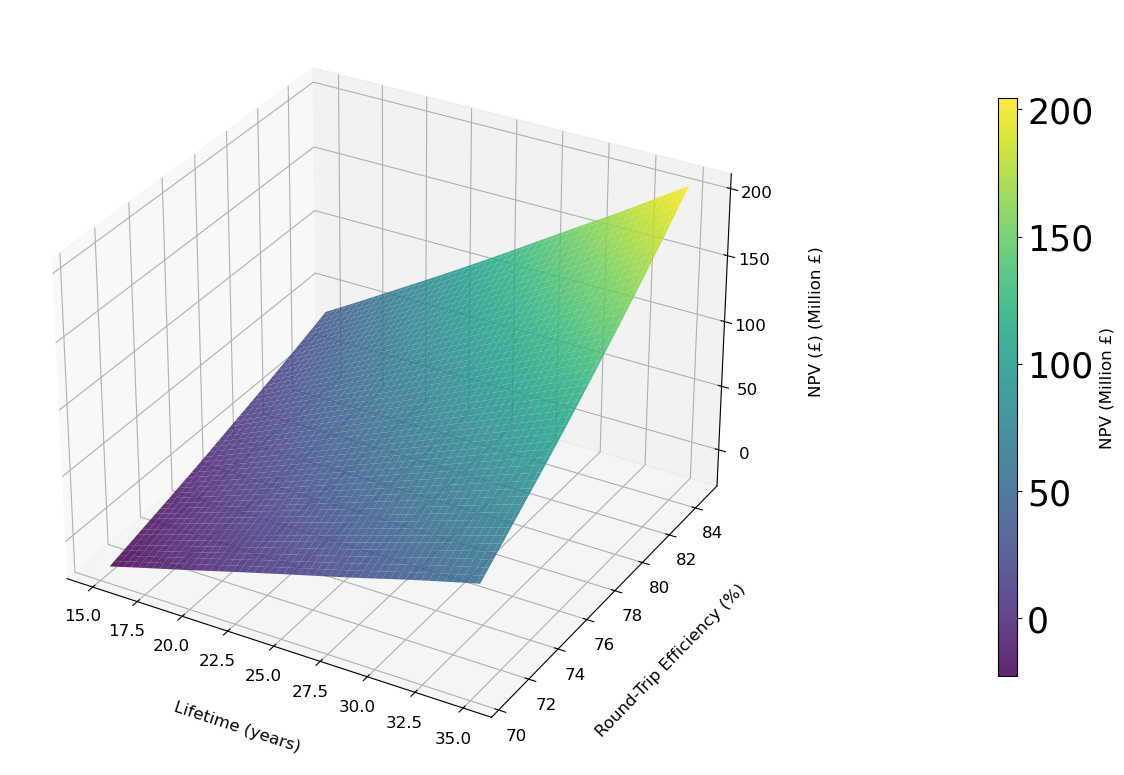

In [27]:
# Load the results from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Results_3D.xlsx'
results_df = pd.read_excel(file_path)

# Convert Total Battery Revenue to Millions of £
results_df['NPV (£)'] = results_df['NPV (£)'] / 1e6

# Calculate Round Trip Efficiency
results_df['Round Trip Efficiency'] = results_df['Round Trip Efficiency'] * 100  # Assuming it's in percentage

# Extract the data
x = results_df['Battery Lifetime (years)']
y = results_df['Round Trip Efficiency']
z = results_df['NPV (£)']

# Create grid data for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the Z values to create a surface
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Adjusting the plot size and enhancing readability
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Use a color map with good contrast and fade effect
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.85)

# Add a color bar for reference with increased distance from the plot and controlled width
cbar = plt.colorbar(surf, ax=ax, shrink=0.5, aspect=30, pad=0.2)  # Adjust aspect to control width, pad to control distance
cbar.set_label('NPV (Million £)', fontsize=12)  # Adjusted label to Million £

# Set custom font sizes
axis_label_font_size = 12  # Font size for axis labels
tick_label_font_size = 12  # Font size for tick labels

# Label the axes with controlled font sizes
ax.set_xlabel('Lifetime (years)', fontsize=axis_label_font_size, labelpad=20)
ax.set_ylabel('Round-Trip Efficiency (%)', fontsize=axis_label_font_size, labelpad=20)
ax.set_zlabel('NPV (£) (Million £)', fontsize=axis_label_font_size, rotation=90, labelpad=20)

# Rotate the Z-axis label and move it to the other side
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation(90)
ax.zaxis.label.set_ha('left')
ax.zaxis.label.set_position((1, 0.5))

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.tick_params(axis='z', which='major', labelsize=tick_label_font_size)

# Add grid lines for better readability
ax.grid(True)

# Save the plot as a high-resolution image with the adjustments
final_readable_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Final_3D.png'
plt.savefig(final_readable_plot_path, dpi=300, bbox_inches='tight')

# Show the plot (optional, if you want to display it in the notebook)
plt.show()


In [28]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Base values for parameters
base_capex_per_mw = 1004099
base_opex_per_mw_per_year = 22261
base_discount_rate = 0.07
base_price_escalation_rate = 0.10
base_max_hours = 2
base_cfd_strike_price = 83.22
base_degradation_rate = 0.0155

# Scenario definitions
scenarios = [
    {'battery_lifetime': 15, 'degradation_rate': 0.0155},
    {'battery_lifetime': 15, 'degradation_rate': 0.03},
    {'battery_lifetime': 15, 'degradation_rate': 0.045},
    {'battery_lifetime': 20, 'degradation_rate': 0.0155},
    {'battery_lifetime': 20, 'degradation_rate': 0.03},
    {'battery_lifetime': 20, 'degradation_rate': 0.045},
    {'battery_lifetime': 25, 'degradation_rate': 0.0155},
    {'battery_lifetime': 25, 'degradation_rate': 0.03},
    {'battery_lifetime': 25, 'degradation_rate': 0.045},
    {'battery_lifetime': 30, 'degradation_rate': 0.0155},
    {'battery_lifetime': 30, 'degradation_rate': 0.03},
    {'battery_lifetime': 30, 'degradation_rate': 0.045},
    {'battery_lifetime': 35, 'degradation_rate': 0.0155},
    {'battery_lifetime': 35, 'degradation_rate': 0.03},
    {'battery_lifetime': 35, 'degradation_rate': 0.045},
]

# Add the fixed parameters to each scenario
for scenario in scenarios:
    scenario.update({
        'capex_per_mw': base_capex_per_mw,
        'opex_per_mw_per_year': base_opex_per_mw_per_year,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price,
        'dch_prices_factor': 1.0,
        'dcl_prices_factor': 1.0
    })

results = []

for i, scenario in enumerate(scenarios, 1):
    print(f"Running scenario {i}...")

    # Adjust prices based on the scenario factors
    adjusted_market_prices = market_prices
    adjusted_dch_prices = dch_prices
    adjusted_dcl_prices = dcl_prices

    # Initialize the network
    network = pypsa.Network()

    # Add time steps to the network
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,  # Generator nominal power (MW)
                p_set=wind_generation_profile.values,  # Set power output directly
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                max_hours=scenario['max_hours'],  # Maximum storage time in hours
                marginal_cost=0.01,  # Storage marginal cost
                capital_cost=scenario['capex_per_mw'],  # CAPEX from scenario
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=0.92,
                efficiency_dispatch=0.92)

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
                "Backup Generator",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=adjusted_market_prices.values,
                capital_cost=1100000)

    network.add("Link",
                "wind_to_grid",
                bus0="wind_bus",
                bus1="grid_bus",
                efficiency=0.95,
                p_nom=82)

    network.add("Link",
                "grid_to_wind",
                bus0="grid_bus",
                bus1="wind_bus",
                efficiency=0.95,
                p_nom=82)

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows using p_dispatch and p_store
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]
    wind_generation = network.generators_t.p["wind_turbine"]
    backup_generation = network.generators_t.p["Backup Generator"]
    load_demand = network.loads_t.p["grid_demand"]
    soc = network.storage_units_t["state_of_charge"]["battery"]
    soc_percentage = soc / battery_capacity_mwh * 100
    wind_to_grid = network.links_t.p0.loc[:, "wind_to_grid"]
    grid_to_wind = network.links_t.p0.loc[:, "grid_to_wind"]

    # Calculate total energy
    total_battery_dispatch = battery_dispatch.sum()
    total_battery_store = battery_store.sum()
    total_wind_to_grid = wind_to_grid.sum()
    total_grid_to_wind = grid_to_wind.sum()

    # Calculate revenues
    cfd_strike_price = scenario['cfd_strike_price']

    # Calculate CFD Revenue (No Arbitrage Cost, as the wind and battery are on the same bus)
    data = pd.DataFrame({
        'Timestamp': wind_data.index,
        'Market Price (£/MWh)': adjusted_market_prices,
        'DCH Price (£/MWh)': adjusted_dch_prices,
        'DCL Price (£/MWh)': adjusted_dcl_prices,
        'Battery Dispatch (MW)': battery_dispatch,
        'Battery Store (MW)': battery_store,
        'Wind Generation (MW)': wind_generation,
        'Colocated to Grid (MWh)': wind_to_grid,
        'Grid to Colocated (MWh)': grid_to_wind, 
        'Backup Generation (MW)': backup_generation,
        'Load Demand (MW)': load_demand,
        'State of Charge (MWh)': soc,
        'State of Charge (%)': soc_percentage
    })

    data['Arbitrage Cost (£)'] = data['Grid to Colocated (MWh)'] * data['Market Price (£/MWh)']
    data['Wind to Battery Cost (£)'] = (data['Battery Store (MW)'] - data['Grid to Colocated (MWh)']) * cfd_strike_price
    
    data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price
    data['Arbitrage Revenue (£)'] = (data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']) - data['Arbitrage Cost (£)']
    data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
    data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']
 
    # Calculate the total revenue from the battery
    data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)'] - data['Wind to Battery Cost (£)']
    data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['Battery Revenue (£)']
    
    # Calculate financial metrics
    annual_battery_revenue = data['Battery Revenue (£)'].sum()
    discount_rate = scenario['discount_rate']
    battery_lifetime = scenario['battery_lifetime']
    capex_per_mw = scenario['capex_per_mw']
    opex_per_mw_per_year = scenario['opex_per_mw_per_year']
    price_escalation_rate = scenario['price_escalation_rate']

    # Total CAPEX
    total_capex = battery_size_mw * capex_per_mw
    
    # Calculate annual battery revenues with cumulative degradation and escalation
    annual_battery_revenues = []
    degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        degradation_multiplier *= (1 - scenario['degradation_rate'])  # Apply cumulative degradation
        escalated_revenue = annual_battery_revenue * degradation_multiplier * (1 + price_escalation_rate) ** year
        annual_battery_revenues.append(escalated_revenue)

    annual_opex = [
        (opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year)
        for year in range(battery_lifetime)
    ]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage

    # Payback Period Calculation
    cumulative_cash_flow = 0
    payback_period = None
    for year, cash_flow in enumerate(annual_cash_flows):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0 and payback_period is None:
            payback_period = year
    
    # Total Charging Costs
    total_arbitrage_cost = data['Arbitrage Cost (£)'].sum() * battery_lifetime
    total_wind_to_battery_cost = data['Wind to Battery Cost (£)'].sum() * battery_lifetime

    # Discounted total charging costs
    discounted_arbitrage_cost = total_arbitrage_cost / ((1 + discount_rate) ** battery_lifetime)
    discounted_wind_to_battery_cost = total_wind_to_battery_cost / ((1 + discount_rate) ** battery_lifetime)

    # Sum total discounted charging costs
    total_discounted_charging_costs = discounted_arbitrage_cost + discounted_wind_to_battery_cost

    # Total discounted costs including charging costs
    total_discounted_costs_with_charging = total_capex + total_discounted_charging_costs + sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    # Total energy dispatched over the lifetime (MWh)
    cumulative_degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        cumulative_degradation_multiplier *= (1 - scenario['degradation_rate'])

    total_energy_dispatched = total_battery_dispatch * battery_lifetime * cumulative_degradation_multiplier

    # LCOS Calculation
    lcos = total_discounted_costs_with_charging / total_energy_dispatched

    # Store results
    results.append({
        'Scenario': i,
        'Battery Size (MW)': battery_size_mw,
        'Battery Capacity (MWh)': battery_capacity_mwh,
        'Total Battery Dispatch (MWh)': total_battery_dispatch,
        'Total Battery Store (MWh)': total_battery_store,
        'Round Trip Efficiency': 0.92 * 0.92,  # Efficiency for this scenario
        'NPV (£)': npv,
        'IRR (%)': irr,
        'LCOS (£/MWh)': lcos,
        'Payback Period (years)': payback_period,
        'Battery Lifetime (years)': battery_lifetime,
        'Discount Rate': discount_rate,
        'Price Escalation Rate': price_escalation_rate,
        'Max Hours': scenario['max_hours'],
        'CAPEX (£/MW)': capex_per_mw,
        'OPEX (£/MW/year)': opex_per_mw_per_year,
        'CFD Strike Price (£/MWh)': cfd_strike_price,
        'Degradation Rate': scenario['degradation_rate'],
        'Total Battery Revenue (£)': annual_battery_revenue,
        'Total Project Revenue (£)': data['Total Project Revenue (£)'].sum()
    })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Save results to an Excel file
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Results_3D_degradation.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Scenario analysis results saved to {output_path}")


Running scenario 1...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 133.01it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-nu7czb1t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-nu7czb1t.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.52 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.52 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 2...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.01it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-mw2vj6jg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-mw2vj6jg.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.52 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.52 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 3...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.84it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ukvjoamu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ukvjoamu.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.44 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.44 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.51 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.51 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 4...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 136.40it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-oaz_vqxi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-oaz_vqxi.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.48 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.48 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.56 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.56 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 5...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.66it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-373n7ztt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-373n7ztt.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.53 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.53 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 6...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.91it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5nq5jdjn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-5nq5jdjn.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.54 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.54 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 7...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 141.28it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-bqxrz92d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-bqxrz92d.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.50 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.50 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.57 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.57 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 8...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.88it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-a7xecf06.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-a7xecf06.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.53 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.53 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 9...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.42it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-rniqgg38.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-rniqgg38.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.50 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.50 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.58 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.58 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 10...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.81it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dq3u3qcx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dq3u3qcx.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.53 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.53 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 11...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 143.35it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-zqmrq4um.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-zqmrq4um.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.52 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.52 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 12...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 145.73it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-9o0tbfd3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-9o0tbfd3.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.46 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.55 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.55 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 13...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.43it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-7wvgzz2r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-7wvgzz2r.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.52 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.52 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 14...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 144.51it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-byi295bw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-byi295bw.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     1s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     1s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     1s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     1s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     1s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     1s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     1s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     1s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     1s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     1s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     1s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     1s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     1s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     1s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.58 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.58 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.66 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.66 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 15...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 136.84it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ostehcyw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-ostehcyw.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.48 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.48 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.55 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.55 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


    Scenario  Battery Size (MW)  Battery Capacity (MWh)  \
0          1             79.998                 159.996   
1          2             79.998                 159.996   
2          3             79.998                 159.996   
3          4             79.998                 159.996   
4          5             79.998                 159.996   
5          6             79.998                 159.996   
6          7             79.998                 159.996   
7          8             79.998                 159.996   
8          9             79.998                 159.996   
9         10             79.998                 159.996   
10        11             79.998                 159.996   
11        12             79.998                 159.996   
12        13             79.998                 159.996   
13        14             79.998                 159.996   
14        15             79.998                 159.996   

    Total Battery Dispatch (MWh)  Total Battery Store (

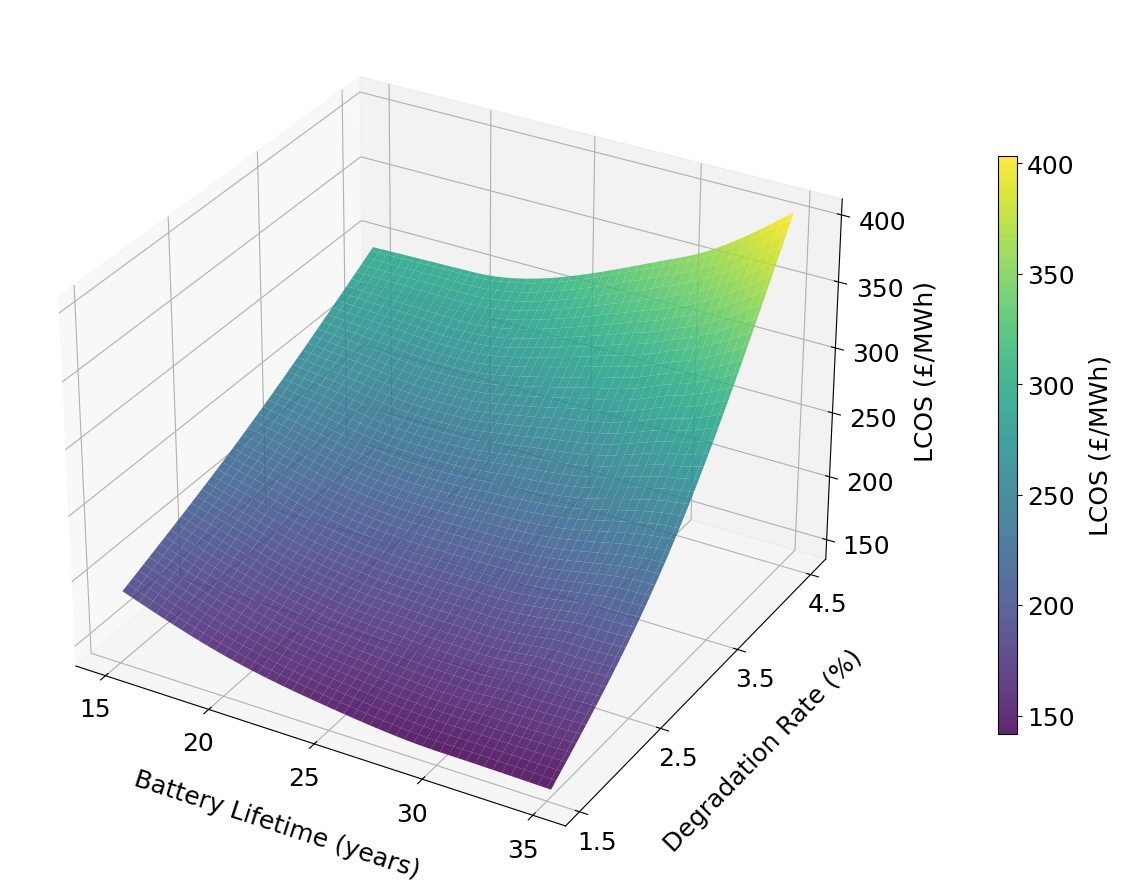

In [29]:
# Load the results from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Results_3D_degradation.xlsx'
results_df = pd.read_excel(file_path)

# Convert Total Battery Revenue to Millions of £
results_df['LCOS (£/MWh)'] = results_df['LCOS (£/MWh)'] 

# Extract the data
x = results_df['Battery Lifetime (years)']
y = results_df['Degradation Rate'] * 100
z = results_df['LCOS (£/MWh)']

# Create grid data for interpolation
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the Z values to create a surface
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Adjusting the plot size and enhancing readability
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Use a color map with good contrast and fade effect
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.85)

# Add a color bar for reference with increased distance from the plot and controlled width
cbar = plt.colorbar(surf, ax=ax, shrink=0.5, aspect=30, pad=0.1)  # Adjust aspect to control width, pad to control distance
cbar.set_label('LCOS (£/MWh)', fontsize=18, labelpad=10)  # Adjusted label to Million £
cbar.ax.tick_params(labelsize=18)  # Set the font size of the numbers on the color bar

# Set custom font sizes
axis_label_font_size = 18  # Font size for axis labels
tick_label_font_size = 18  # Font size for tick labels

# Label the axes with controlled font sizes
ax.set_xlabel('Battery Lifetime (years)', fontsize=axis_label_font_size, labelpad=20)
ax.set_ylabel('Degradation Rate (%)', fontsize=axis_label_font_size, labelpad=20)
ax.set_zlabel('LCOS (£/MWh)', fontsize=axis_label_font_size, rotation=90, labelpad=20)

# Rotate the Z-axis label and move it to the other side
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation(90)
ax.zaxis.label.set_ha('left')
ax.zaxis.label.set_position((1, 0.5))
ax.set_xticks([15, 20, 25, 30, 35])
ax.set_yticks([1.5, 2.5, 3.5, 4.5])

# Increase tick label size and add padding
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.tick_params(axis='z', which='major', labelsize=tick_label_font_size, pad=10)  # Added pad to z-axis

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.tick_params(axis='z', which='major', labelsize=tick_label_font_size)

# Add grid lines for better readability
ax.grid(True)

# Save the plot as a high-resolution image with the adjustments
final_readable_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Final_3D_degradation_LCOS.png'
plt.savefig(final_readable_plot_path, dpi=300, bbox_inches='tight', transparent=True)

# Show the plot (optional, if you want to display it in the notebook)
plt.show()


In [30]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Base values for parameters
base_capex_per_mw = 1004099
base_opex_per_mw_per_year = 22261
base_efficiency_store = 0.92
base_efficiency_dispatch = 0.92
base_battery_lifetime = 15
base_discount_rate = 0.07
base_price_escalation_rate = 0.10
base_max_hours = 2
base_cfd_strike_price = 83.22
base_degradation_rate = 0.0155 

# Scenario definitions
scenarios = [
    # Scenario 3 (Base Scenario)
    {
        'capex_per_mw': base_capex_per_mw,
        'opex_per_mw_per_year': base_opex_per_mw_per_year,
        'efficiency_store': base_efficiency_store,
        'efficiency_dispatch': base_efficiency_dispatch,
        'battery_lifetime': base_battery_lifetime,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'degradation_rate': base_degradation_rate,
        'cfd_strike_price': base_cfd_strike_price,
        'market_price_factor': 1.0,
        'dch_prices_factor': 1.0,
        'dcl_prices_factor': 1.0
    },
    # Scenario 2
    {
        'capex_per_mw': base_capex_per_mw * 0.864,
        'opex_per_mw_per_year': base_opex_per_mw_per_year * 0.853,
        'efficiency_store': base_efficiency_store,
        'efficiency_dispatch': base_efficiency_store,
        'battery_lifetime': base_battery_lifetime,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'degradation_rate': base_degradation_rate,
        'cfd_strike_price': base_cfd_strike_price,
        'market_price_factor': 1.1309,
        'dch_prices_factor': 1,
        'dcl_prices_factor': 1
    }
]

results = []

for i, scenario in enumerate(scenarios, 1):
    print(f"Running scenario {i}...")

    # Adjust prices based on the scenario factors
    adjusted_market_prices = market_prices * scenario['market_price_factor']
    adjusted_dch_prices = dch_prices * scenario['dch_prices_factor']
    adjusted_dcl_prices = dcl_prices * scenario['dcl_prices_factor']

    # Calculate round trip efficiency
    round_trip_efficiency = scenario['efficiency_store'] * scenario['efficiency_dispatch']

    # Initialize the network
    network = pypsa.Network()

    # Add time steps to the network
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,  # Generator nominal power (MW)
                p_set=wind_generation_profile.values,  # Set power output directly
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                max_hours=scenario['max_hours'],  # Maximum storage time in hours
                marginal_cost=0.01,  # Storage marginal cost
                capital_cost=scenario['capex_per_mw'], # CAPEX from scenario
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=scenario['efficiency_store'],
                efficiency_dispatch=scenario['efficiency_dispatch'])

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
                "Backup Generator",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=adjusted_market_prices.values,
                capital_cost=1100000)

    network.add("Link",
                "wind_to_grid",
                bus0="wind_bus",
                bus1="grid_bus",
                efficiency=0.95,
                p_nom=82)

    network.add("Link",
                "grid_to_wind",
                bus0="grid_bus",
                bus1="wind_bus",
                efficiency=0.95,
                p_nom=82)

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows using p_dispatch and p_store
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]
    wind_generation = network.generators_t.p["wind_turbine"]
    backup_generation = network.generators_t.p["Backup Generator"]
    load_demand = network.loads_t.p["grid_demand"]
    soc = network.storage_units_t["state_of_charge"]["battery"]
    soc_percentage = soc / battery_capacity_mwh * 100
    wind_to_grid = network.links_t.p0.loc[:, "wind_to_grid"]
    grid_to_wind = network.links_t.p0.loc[:, "grid_to_wind"]
     
    # Calculate total energy
    total_battery_dispatch = battery_dispatch.sum()
    total_battery_store = battery_store.sum()
    total_wind_to_grid = wind_to_grid.sum()
    total_grid_to_wind = grid_to_wind.sum()
    
    # Calculate revenues
    cfd_strike_price = scenario['cfd_strike_price']

    # Calculate CFD Revenue (No Arbitrage Cost, as the wind and battery are on the same bus)
    data = pd.DataFrame({
        'Timestamp': wind_data.index,
        'Market Price (£/MWh)': adjusted_market_prices,
        'DCH Price (£/MWh)': adjusted_dch_prices,
        'DCL Price (£/MWh)': adjusted_dcl_prices,
        'Battery Dispatch (MW)': battery_dispatch,
        'Battery Store (MW)': battery_store,
        'Wind Generation (MW)': wind_generation,
        'Colocated to Grid (MWh)': wind_to_grid,
        'Grid to Colocated (MWh)': grid_to_wind, 
        'Backup Generation (MW)': backup_generation,
        'Load Demand (MW)': load_demand,
        'State of Charge (MWh)': soc,
        'State of Charge (%)': soc_percentage
    })

    data['Arbitrage Cost (£)'] = data['Grid to Colocated (MWh)'] * data['Market Price (£/MWh)']
    data['Wind to Battery Cost (£)'] = (data['Battery Store (MW)'] - data['Grid to Colocated (MWh)']) * base_cfd_strike_price
    
    data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price
    data['Arbitrage Revenue (£)'] = (data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']) - data['Arbitrage Cost (£)'] 
    data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
    data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']
    data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)'] - data['Wind to Battery Cost (£)']
    data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['Battery Revenue (£)']

    # Calculate financial metrics
    annual_battery_revenue = data['Battery Revenue (£)'].sum()
    discount_rate = scenario['discount_rate']
    battery_lifetime = int(scenario['battery_lifetime'])  # Ensure battery_lifetime is an integer
    capex_per_mw = scenario['capex_per_mw']
    opex_per_mw_per_year = scenario['opex_per_mw_per_year']
    price_escalation_rate = scenario['price_escalation_rate']

    # Total CAPEX
    total_capex = battery_size_mw * capex_per_mw

    # Calculate annual battery revenues with cumulative degradation and escalation
    annual_battery_revenues = []
    degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        degradation_multiplier *= (1 - scenario['degradation_rate'])  # Apply cumulative degradation
        escalated_revenue = annual_battery_revenue * degradation_multiplier * (1 + price_escalation_rate) ** year
        annual_battery_revenues.append(escalated_revenue)

    annual_opex = [
        (opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year)
        for year in range(battery_lifetime)
    ]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage

    # Payback Period Calculation
    cumulative_cash_flow = 0
    payback_period = None
    for year, cash_flow in enumerate(annual_cash_flows):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0 and payback_period is None:
            payback_period = year
        
    # Total Charging Costs
    total_arbitrage_cost = data['Arbitrage Cost (£)'].sum() * battery_lifetime
    total_wind_to_battery_cost = data['Wind to Battery Cost (£)'].sum() * battery_lifetime

    discounted_arbitrage_cost = total_arbitrage_cost / ((1 + discount_rate) ** battery_lifetime)
    discounted_wind_to_battery_cost = total_wind_to_battery_cost / ((1 + discount_rate) ** battery_lifetime)

    total_discounted_charging_costs = discounted_arbitrage_cost + discounted_wind_to_battery_cost

    # Total discounted costs including charging costs
    total_discounted_costs_with_charging = total_capex + total_discounted_charging_costs + sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    ## Calculate cumulative degradation multiplier over the battery lifetime
    cumulative_degradation_multiplier = 1  # Start with no degradation in year 0
    for year in range(battery_lifetime):
        cumulative_degradation_multiplier *= (1 - scenario['degradation_rate'])

    # Total energy dispatched over the lifetime (MWh) using cumulative degradation multiplier
    total_energy_dispatched = total_battery_dispatch * battery_lifetime * cumulative_degradation_multiplier

    # Updated LCOS calculation with charging costs included
    lcos_with_charging = total_discounted_costs_with_charging / total_energy_dispatched

    # Store results
    results.append({
        'Scenario': i,
        'Battery Size (MW)': battery_size_mw,
        'Battery Capacity (MWh)': battery_capacity_mwh,
        'Total Battery Dispatch (MWh)': total_battery_dispatch,
        'Total Battery Store (MWh)': total_battery_store,
        'Round Trip Efficiency': round_trip_efficiency,
        'NPV (£)': npv,
        'IRR (%)': irr,
        'LCOS (£/MWh)': lcos_with_charging,
        'Payback Period (years)': payback_period,
        'Battery Lifetime (years)': battery_lifetime,
        'Discount Rate': discount_rate,
        'Price Escalation Rate': price_escalation_rate,
        'Max Hours': scenario['max_hours'],
        'CAPEX (£/MW)': capex_per_mw,
        'OPEX (£/MW/year)': opex_per_mw_per_year,
        'CFD Strike Price (£/MWh)': cfd_strike_price,
        'Market Price Factor': scenario['market_price_factor'],
        'DCH Prices Factor': scenario['dch_prices_factor'],
        'DCL Prices Factor': scenario['dcl_prices_factor'],
        'Total Battery Revenue (£)': annual_battery_revenue,
        'Total Project Revenue (£)': data['Total Project Revenue (£)'].sum(),
        'Total Discounted Charging Costs (£)': total_discounted_charging_costs,
        'Total Costs including Charging (£)': total_discounted_costs_with_charging,
        'Total Energy Dispatched (MWh)': total_energy_dispatched,
    })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Save results to an Excel file
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation/Two Buses Result/Two Streams/Sensitivity/Scenario_Analysis_Results_one_scenario.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Scenario analysis results saved to {output_path}")


Running scenario 1...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 142.82it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dtamb90w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-dtamb90w.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0xc8c25b7d


INFO:gurobipy:Model fingerprint: 0xc8c25b7d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   1.97470170e+11 -1.26912478e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   1.97394268e+11 -6.07073148e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


INFO:gurobipy:   2   1.97352773e+11  6.12054813e+10  4.58e+00 7.93e+03  2.37e+06     0s


   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


INFO:gurobipy:   3   1.97353546e+11  1.96349962e+11  5.53e-12 1.75e+00  1.18e+04     0s


   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


INFO:gurobipy:   4   1.97192048e+11  1.97017565e+11  2.84e-12 3.49e-10  2.01e+03     0s


   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


INFO:gurobipy:   5   1.97189060e+11  1.97094909e+11  2.74e-12 1.75e-10  1.08e+03     0s


   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


INFO:gurobipy:   6   1.97182211e+11  1.97141885e+11  2.19e-09 7.39e-13  4.63e+02     0s


   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


INFO:gurobipy:   7   1.97176816e+11  1.97158354e+11  3.87e-10 2.33e-10  2.12e+02     0s


   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


INFO:gurobipy:   8   1.97174062e+11  1.97164684e+11  5.23e-10 1.42e-13  1.08e+02     0s


   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


INFO:gurobipy:   9   1.97172570e+11  1.97167656e+11  1.75e-09 1.14e-13  5.63e+01     0s


  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


INFO:gurobipy:  10   1.97171482e+11  1.97168882e+11  5.07e-10 5.82e-11  2.98e+01     0s


  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


INFO:gurobipy:  11   1.97171056e+11  1.97169705e+11  4.97e-10 1.14e-13  1.55e+01     0s


  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


INFO:gurobipy:  12   1.97170660e+11  1.97170167e+11  3.98e-10 5.82e-11  5.66e+00     0s


  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


INFO:gurobipy:  13   1.97170469e+11  1.97170334e+11  1.24e-09 1.14e-13  1.56e+00     0s


  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


INFO:gurobipy:  14   1.97170418e+11  1.97170375e+11  4.77e-04 2.27e-13  5.12e-01     0s


  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


INFO:gurobipy:  15   1.97170410e+11  1.97170389e+11  4.29e-04 2.27e-13  2.43e-01     0s


  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


INFO:gurobipy:  16   1.97170404e+11  1.97170399e+11  2.36e-04 2.27e-13  6.11e-02     0s


  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


INFO:gurobipy:  17   1.97170403e+11  1.97170401e+11  1.07e-04 2.27e-13  1.98e-02     0s


  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


INFO:gurobipy:  18   1.97170402e+11  1.97170402e+11  3.05e-05 2.27e-13  3.86e-03     0s


  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


INFO:gurobipy:  19   1.97170402e+11  1.97170402e+11  2.60e-06 2.33e-10  2.00e-04     0s


  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


INFO:gurobipy:  20   1.97170402e+11  1.97170402e+11  7.84e-08 1.16e-10  8.46e-06     0s


  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


INFO:gurobipy:  21   1.97170402e+11  1.97170402e+11  6.02e-09 5.37e-08  2.07e-08     0s


  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:  22   1.97170402e+11  1.97170402e+11  5.67e-09 4.90e-08  1.42e-10     0s


INFO:gurobipy:


Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 0.45 seconds (0.86 work units)


Optimal objective 1.97170402e+11


INFO:gurobipy:Optimal objective 1.97170402e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:


       9 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       9 PPushes remaining with PInf 0.0000000e+00                 0s


       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 0s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6067093e-10      0s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3772    1.9717040e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3772 iterations and 0.52 seconds (0.94 work units)


INFO:gurobipy:Solved in 3772 iterations and 0.52 seconds (0.94 work units)


Optimal objective  1.971704020e+11


INFO:gurobipy:Optimal objective  1.971704020e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 1.97e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 2...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 146.07it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8z4s24z5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-8z4s24z5.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 157250 rows, 61154 columns, 270818 nonzeros


INFO:gurobipy:obj: 157250 rows, 61154 columns, 270818 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


INFO:gurobipy:Optimize a model with 157250 rows, 61154 columns and 270818 nonzeros


Model fingerprint: 0x565de1d8


INFO:gurobipy:Model fingerprint: 0x565de1d8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 1e+06]


INFO:gurobipy:  Objective range  [1e-02, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113575 rows and 17488 columns


INFO:gurobipy:Presolve removed 113575 rows and 17488 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:Presolved: 43675 rows, 43666 columns, 122291 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.608e+04


INFO:gurobipy: AA' NZ     : 9.608e+04


 Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.803e+05 (roughly 40 MB of memory)


 Factor Ops : 6.098e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.098e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.10025878e+11 -1.25661798e+12  1.34e+02 1.88e+05  1.13e+08     0s


INFO:gurobipy:   0   2.10025878e+11 -1.25661798e+12  1.34e+02 1.88e+05  1.13e+08     0s


   1   2.09920884e+11 -5.94547774e+11  2.05e+01 9.48e+04  2.12e+07     0s


INFO:gurobipy:   1   2.09920884e+11 -5.94547774e+11  2.05e+01 9.48e+04  2.12e+07     0s


   2   2.09873518e+11  7.37348413e+10  4.58e+00 7.94e+03  2.37e+06     0s


INFO:gurobipy:   2   2.09873518e+11  7.37348413e+10  4.58e+00 7.94e+03  2.37e+06     0s


   3   2.09873979e+11  2.08845632e+11  6.08e-12 4.74e+00  1.24e+04     0s


INFO:gurobipy:   3   2.09873979e+11  2.08845632e+11  6.08e-12 4.74e+00  1.24e+04     0s


   4   2.09730923e+11  2.09579263e+11  2.49e-12 2.33e-10  1.75e+03     0s


INFO:gurobipy:   4   2.09730923e+11  2.09579263e+11  2.49e-12 2.33e-10  1.75e+03     0s


   5   2.09728232e+11  2.09640562e+11  2.37e-12 1.31e-12  1.01e+03     0s


INFO:gurobipy:   5   2.09728232e+11  2.09640562e+11  2.37e-12 1.31e-12  1.01e+03     0s


   6   2.09720305e+11  2.09675313e+11  2.79e-09 7.11e-13  5.17e+02     0s


INFO:gurobipy:   6   2.09720305e+11  2.09675313e+11  2.79e-09 7.11e-13  5.17e+02     0s


   7   2.09715615e+11  2.09690192e+11  5.77e-10 4.55e-13  2.92e+02     0s


INFO:gurobipy:   7   2.09715615e+11  2.09690192e+11  5.77e-10 4.55e-13  2.92e+02     0s


   8   2.09711786e+11  2.09698362e+11  1.05e-09 2.27e-13  1.54e+02     0s


INFO:gurobipy:   8   2.09711786e+11  2.09698362e+11  1.05e-09 2.27e-13  1.54e+02     0s


   9   2.09709805e+11  2.09702226e+11  5.48e-10 2.27e-13  8.70e+01     0s


INFO:gurobipy:   9   2.09709805e+11  2.09702226e+11  5.48e-10 2.27e-13  8.70e+01     0s


  10   2.09708785e+11  2.09704483e+11  5.88e-10 1.14e-13  4.94e+01     0s


INFO:gurobipy:  10   2.09708785e+11  2.09704483e+11  5.88e-10 1.14e-13  4.94e+01     0s


  11   2.09707830e+11  2.09705332e+11  1.17e-09 2.27e-13  2.87e+01     0s


INFO:gurobipy:  11   2.09707830e+11  2.09705332e+11  1.17e-09 2.27e-13  2.87e+01     0s


  12   2.09707193e+11  2.09706099e+11  2.74e-10 2.33e-10  1.26e+01     0s


INFO:gurobipy:  12   2.09707193e+11  2.09706099e+11  2.74e-10 2.33e-10  1.26e+01     0s


  13   2.09706894e+11  2.09706576e+11  8.80e-10 2.27e-13  3.66e+00     0s


INFO:gurobipy:  13   2.09706894e+11  2.09706576e+11  8.80e-10 2.27e-13  3.66e+00     0s


  14   2.09706783e+11  2.09706668e+11  4.23e-10 2.27e-13  1.32e+00     0s


INFO:gurobipy:  14   2.09706783e+11  2.09706668e+11  4.23e-10 2.27e-13  1.32e+00     0s


  15   2.09706749e+11  2.09706696e+11  6.22e-10 2.27e-13  6.12e-01     0s


INFO:gurobipy:  15   2.09706749e+11  2.09706696e+11  6.22e-10 2.27e-13  6.12e-01     0s


  16   2.09706732e+11  2.09706710e+11  1.89e-04 2.27e-13  2.58e-01     0s


INFO:gurobipy:  16   2.09706732e+11  2.09706710e+11  1.89e-04 2.27e-13  2.58e-01     0s


  17   2.09706725e+11  2.09706719e+11  1.76e-04 2.33e-10  7.33e-02     0s


INFO:gurobipy:  17   2.09706725e+11  2.09706719e+11  1.76e-04 2.33e-10  7.33e-02     0s


  18   2.09706723e+11  2.09706722e+11  5.02e-05 2.27e-13  7.10e-03     0s


INFO:gurobipy:  18   2.09706723e+11  2.09706722e+11  5.02e-05 2.27e-13  7.10e-03     0s


  19   2.09706722e+11  2.09706722e+11  9.67e-06 2.27e-13  1.33e-03     0s


INFO:gurobipy:  19   2.09706722e+11  2.09706722e+11  9.67e-06 2.27e-13  1.33e-03     0s


  20   2.09706722e+11  2.09706722e+11  2.48e-06 2.27e-13  3.21e-04     0s


INFO:gurobipy:  20   2.09706722e+11  2.09706722e+11  2.48e-06 2.27e-13  3.21e-04     0s


  21   2.09706722e+11  2.09706722e+11  2.38e-07 9.31e-10  2.09e-05     0s


INFO:gurobipy:  21   2.09706722e+11  2.09706722e+11  2.38e-07 9.31e-10  2.09e-05     0s


  22   2.09706722e+11  2.09706722e+11  1.08e-08 6.00e-09  1.44e-07     0s


INFO:gurobipy:  22   2.09706722e+11  2.09706722e+11  1.08e-08 6.00e-09  1.44e-07     0s


  23   2.09706722e+11  2.09706722e+11  1.17e-09 1.86e-08  1.40e-10     0s


INFO:gurobipy:  23   2.09706722e+11  2.09706722e+11  1.17e-09 1.86e-08  1.40e-10     0s


INFO:gurobipy:


Barrier solved model in 23 iterations and 0.49 seconds (0.88 work units)


INFO:gurobipy:Barrier solved model in 23 iterations and 0.49 seconds (0.88 work units)


Optimal objective 2.09706722e+11


INFO:gurobipy:Optimal objective 2.09706722e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3760 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    3760 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


      10 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:      10 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9305729e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9305729e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3773    2.0970672e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    3773    2.0970672e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 3773 iterations and 0.56 seconds (0.95 work units)


INFO:gurobipy:Solved in 3773 iterations and 0.56 seconds (0.95 work units)


Optimal objective  2.097067225e+11


INFO:gurobipy:Optimal objective  2.097067225e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61154 primals, 157250 duals
Objective: 2.10e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


   Scenario  Battery Size (MW)  Battery Capacity (MWh)  \
0         1             79.998                 159.996   
1         2             79.998                 159.996   

   Total Battery Dispatch (MWh)  Total Battery Store (MWh)  \
0                   73735.41228               87116.507892   
1                   73742.67528               87125.088941   

   Round Trip Efficiency       NPV (£)    IRR (%)  LCOS (£/MWh)  \
0                 0.8464  3.393823e+07  11.996438    187.418505   
1                 0.8464  7.158470e+07  17.953212    175.168812   

   Payback Period (years)  ...  OPEX (£/MW/year)  CFD Strike Price (£/MWh)  \
0                       8  ...         22261.000                     83.22   
1                       7  ...         18988.633                     83.22   

   Market Price Factor  DCH Prices Factor  DCL Prices Factor  \
0               1.0000                1.0                1.0   
1               1.1309                1.0                1.0   

   Total